In [1]:
#basic package
import tqdm
import os
import numpy as np
import glob
import pandas as pd
import sys
import time
import datetime as dt
import itertools
import re
import math
from collections import Counter
import operator
from scipy import stats
from numpy import inf
import networkx as nx
from dtaidistance import dtw
import random
from scipy.stats import pearsonr, spearmanr

#save and load dictionaries/lists
import pickle

#scaling
from sklearn.preprocessing import StandardScaler, MinMaxScaler

#PCA
from sklearn import decomposition

#clustering
from sklearn.cluster import KMeans #only numerical var
from sklearn.metrics import silhouette_samples, silhouette_score
import kmodes
from kmodes.kmodes import KModes #with categorical var as well

#plot
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

In [2]:
PACKAGE_PARENT = '../'
SCRIPT_DIR = os.path.dirname(os.path.realpath(os.path.join(os.getcwd(), os.path.expanduser('__file__'))))
sys.path.append(os.path.normpath(os.path.join(SCRIPT_DIR, PACKAGE_PARENT)))
from UTILS import kmeans_clustering, ZoneVariable, time_series_henColumn_tsRow, FB_daily, corr_from_dep2feature,\
corr_from_feature2feature, correlationGraph, ZoneVariable, DataRepresentation1, sampen, chi2_distance, is_day, correct_key
import config_origins as config

C:\Users\camil\anaconda3\lib\site-packages\scipy\sparse\sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


2


# Define parameters

In [4]:
print('change the configuration file if not done yet!')
path_extracted_data = config.path_extracted_data
id_run = config.id_run
dico_pen_tr = config.dico_pen_tr
li_binmn = config.li_binmn
penalty = config.penalty
dico_window = config.dico_window
birth_date = config.birth_date
dico_night_hour = config.dico_night_hour
path_extracted_data = config.path_extracted_data
path_extracted_data_proximity = os.path.join(path_extracted_data ,'Proximity')
#create a director if not existing
if not os.path.exists(path_extracted_data_proximity):
    os.makedirs(path_extracted_data_proximity)

change the configuration file if not done yet!


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Download variables

In [6]:
#download the cleaned-movement data
df = pd.read_csv(os.path.join(path_extracted_data, id_run+'_CLEANEDDATA.csv'), sep=';', 
                 parse_dates=['Timestamp', 'date'], dayfirst=True) 
df['hour'] = df['Timestamp'].map(lambda x: x.hour)
df['time'] = df['Timestamp'].map(lambda x: dt.datetime.time(x-dt.timedelta(seconds=x.second)))
df.drop('duration', axis=1, inplace=True)
print(df.shape)
df.head(3)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(2695668, 17)


,HenID,PenID,system,Zone,model_prediction,Timestamp,date,next_record_date,previous_record_date,previous_duration,next_zone,previous_zone,previous_previous_zone,correction_is_consecutive_equal_initial_zone,is_WG_open,hour,time
0,hen_71,pen12,10 - 12,3_Zone,1.0,2020-09-29 09:07:00,2020-09-29,2020-09-29 09:08:26,NaN,NaN,3_Zone,NaN,NaN,False,False,9,09:07:00
1,hen_7,pen11,10 - 12,3_Zone,1.0,2020-09-29 09:08:12,2020-09-29,2020-09-29 09:12:16,NaN,NaN,3_Zone,NaN,NaN,False,False,9,09:08:00
2,hen_10,pen11,10 - 12,3_Zone,1.0,2020-09-29 09:19:19,2020-09-29,2020-09-29 09:20:27,NaN,NaN,3_Zone,NaN,NaN,False,False,9,09:19:00


In [13]:
#daily variables (one row per (henID, date))
#daily_ALL_Variable_Tranformed
df_daily = pd.read_csv(os.path.join(path_extracted_data, id_run+'_daily_ALL_variables.csv'), sep=';',
                     parse_dates=['level','FirstTimestamp_1_Zone', 'FirstTimestamp_2_Zone', 'FirstTimestamp_3_Zone',
                              'FirstTimestamp_4_Zone', 'FirstTimestamp_5_Zone', 
                              'Nestbox_time_of_first_staid_longer_than900sec',
                              'duration_last-firsttransition_mn'], dayfirst=True) 
print(df_daily.shape)
df_daily.head(3)

(42750, 158)


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,HenID,level,duration_1_Zone,duration_2_Zone,duration_3_Zone,duration_4_Zone,duration_5_Zone,verification_daily_total_duration,verification_daily_total_nbr_hour,dur_values,...,nbr_transition_at_h21,nbr_transition_at_h22,nbr_transition_at_h23,nbr_transition_next1hafterlightoff,nbr_h_per_day,correct_amount_of_hour,DOA,WOA,DIB,WIB
0,hen_130,2020-10-05,NaN,0.0,0.0,0.0,32400.0,32400.0,9.0,"[0.0, 0.0, 0.0, 0.0, 32400.0]",...,0.0,0.0,0.0,0.0,9,True,124,18,6,1
1,hen_130,2020-10-06,NaN,0.0,780.0,325.0,31295.0,32400.0,9.0,"[0.0, 0.0, 780.0, 325.0, 31295.0]",...,0.0,0.0,0.0,0.0,9,True,125,18,7,1
2,hen_130,2020-10-07,NaN,206.0,249.0,130.0,31815.0,32400.0,9.0,"[0.0, 206.0, 249.0, 130.0, 31815.0]",...,0.0,0.0,0.0,0.0,9,True,126,18,8,2


df_daily['DOA'] = df_daily['level'].map(lambda x: (x-dt.datetime(2020,6,3)).days) 
df_daily['weeks_in_laying_barn'] = df_daily['DOA'].map(lambda x: int((x-119)/7)+1)
#df_daily['weeks_in_laying_barn'] = df_daily['DOA'].map(lambda x: math.ceil(x/7))
#first two month seems good from the %of hens not moving plot! and sounds good too (twice longer thatn they need to start moving)
print(df_daily.shape)

#filter by date
df_daily = df_daily[df_daily['level']>dt.datetime(2020,9,29)]

#remove days that are not fully recorded
df_daily['nbr_sec_per_day'] = df_daily['level'].map(lambda x: dico_night_hour[correct_key(x,dico_night_hour)]['nbr_hour']*60*60)
df_daily['is_correct_amount_time'] = df_daily.apply(lambda x: x['nbr_sec_per_day']==x['verification_daily_total_duration'], axis=1)
df_daily[(~df_daily['is_correct_amount_time'])&(~df_daily['Total_number_transition'].isnull())][['level', 'HenID', 'Total_number_transition', 'dur_values', 'verification_daily_total_duration','nbr_sec_per_day']]
print(df_daily.shape)
display(df_daily = df_daily[~((~df_daily['is_correct_amount_time'])&(~df_daily['Total_number_transition'].isnull()))])
print(df_daily.shape)

#remove the days where the night had movement recorded but not the days
print(df_daily.shape)
#display(df_daily[df_daily.isna().any(axis=1)])
df_daily = df_daily[~df_daily['verification_daily_total_duration'].isnull()]
print(df_daily.shape)

df_daily['dur_values_normalized'].replace('[nan, nan, nan, nan, nan]','[np.nan,np.nan,np.nan,np.nan,np.nan]', inplace=True)
df_daily['dur_values_normalized'] = df_daily['dur_values_normalized'].map(lambda x: eval(x))
df_daily['duration_last-firsttransition_mn'] = df_daily['duration_last-firsttransition_mn'].astype(float)
print(df_daily.shape)
df_daily.head(3)

# Compute MLPS vectors

### on the daily-hours

In [25]:
#note that we will have more entries than needed, as the distrubances days are not removed in the raw-cleaned movements
#dataframe.
dico_pen_level_h = {}
#we have to do a loop per pen, due to memory issue
for p, df_pen in tqdm.tqdm(df.groupby('PenID')):
        
    #update results
    dico_pen_level_h[p] = {}
    
    #compute time series
    df_ts = time_series_henColumn_tsRow(df_pen, config, col_ts='Zone', ts_with_all_hen_value=False, save=False, 
                                        hen_time_series=False)
    
    #restrict to the daylight ONLY
    df_ts['is_day'] = df_ts['Timestamp'].map(lambda x: is_day(x, config.dico_night_hour))
    df_ts = df_ts[df_ts['is_day']]

    #list of all hen present in this pen
    li_hen = [v for v in df_ts.columns if 'hen_' in v]

    ################# create one list per animal #################
    #groupby date to have a list of zones per day (rows) for the hens (columns)
    df_ts = df_ts.groupby('date')[li_hen].agg(lambda x: list(x)).reset_index()
    #melt to have one row per (day, hens) to avoid looping to create the dictionary
    df_ts_ = pd.melt(df_ts, id_vars=['date'], value_vars=li_hen)
    for d, df__ in df_ts_.groupby(['date']):
        #update results: value column is the list of zone
        dico_pen_level_h[p][d] = dict(zip(df__['HenID'].tolist(), df__['value'].tolist()))   
    
#save dictionaries
pickle.dump(dico_pen_level_h, open(os.path.join(path_extracted_data, 
                                                id_run+'dico_pen_level_h_allzoneidseclevel_DAILYLEVEL.pkl'), 'wb'), pickle.HIGHEST_PROTOCOL)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
  0%|                                                                                            | 0/8 [00:00<?, ?it/s]

in this time series there is 28 hens
The initial starting date in over all is: 2020-09-29 09:20:21, and the ending date will be: 2021-05-10 08:42:27
But note that birds may have different ending and starting date which should be taken into account when computing variables
and after ending the last day at midnight : 2020-09-29 09:20:21, and the ending date will be: 2021-05-10 23:59:59
Total running time: 4.25 mn


 12%|██████████▍                                                                        | 1/8 [07:37<53:22, 457.47s/it]

in this time series there is 28 hens
The initial starting date in over all is: 2020-09-29 09:08:12, and the ending date will be: 2021-05-10 08:42:22
But note that birds may have different ending and starting date which should be taken into account when computing variables
and after ending the last day at midnight : 2020-09-29 09:08:12, and the ending date will be: 2021-05-10 23:59:59
Total running time: 3.86 mn


 25%|████████████████████▊                                                              | 2/8 [14:53<45:06, 451.01s/it]

in this time series there is 31 hens
The initial starting date in over all is: 2020-09-29 09:07:00, and the ending date will be: 2021-05-10 08:42:20
But note that birds may have different ending and starting date which should be taken into account when computing variables
and after ending the last day at midnight : 2020-09-29 09:07:00, and the ending date will be: 2021-05-10 23:59:59
Total running time: 4.22 mn


 38%|███████████████████████████████▏                                                   | 3/8 [22:34<37:49, 453.97s/it]

in this time series there is 28 hens
The initial starting date in over all is: 2020-09-29 09:32:45, and the ending date will be: 2021-05-10 08:26:44
But note that birds may have different ending and starting date which should be taken into account when computing variables
and after ending the last day at midnight : 2020-09-29 09:32:45, and the ending date will be: 2021-05-10 23:59:59
Total running time: 4.54 mn


 50%|█████████████████████████████████████████▌                                         | 4/8 [30:40<30:54, 463.64s/it]

in this time series there is 27 hens
The initial starting date in over all is: 2020-09-29 09:33:43, and the ending date will be: 2021-05-10 08:26:01
But note that birds may have different ending and starting date which should be taken into account when computing variables
and after ending the last day at midnight : 2020-09-29 09:33:43, and the ending date will be: 2021-05-10 23:59:59
Total running time: 5.08 mn


 62%|███████████████████████████████████████████████████▉                               | 5/8 [39:19<24:00, 480.20s/it]

in this time series there is 29 hens
The initial starting date in over all is: 2020-09-29 09:33:48, and the ending date will be: 2021-05-10 08:26:39
But note that birds may have different ending and starting date which should be taken into account when computing variables
and after ending the last day at midnight : 2020-09-29 09:33:48, and the ending date will be: 2021-05-10 23:59:59
Total running time: 4.48 mn


 75%|██████████████████████████████████████████████████████████████▎                    | 6/8 [48:22<16:38, 499.20s/it]

in this time series there is 29 hens
The initial starting date in over all is: 2020-09-29 09:52:12, and the ending date will be: 2021-05-10 08:40:33
But note that birds may have different ending and starting date which should be taken into account when computing variables
and after ending the last day at midnight : 2020-09-29 09:52:12, and the ending date will be: 2021-05-10 23:59:59
Total running time: 8.69 mn


 88%|██████████████████████████████████████████████████████████████████████▉          | 7/8 [1:02:34<10:04, 604.80s/it]

in this time series there is 28 hens
The initial starting date in over all is: 2020-09-29 09:36:51, and the ending date will be: 2021-05-10 08:39:39
But note that birds may have different ending and starting date which should be taken into account when computing variables
and after ending the last day at midnight : 2020-09-29 09:36:51, and the ending date will be: 2021-05-10 23:59:59
Total running time: 7.32 mn


100%|█████████████████████████████████████████████████████████████████████████████████| 8/8 [1:15:28<00:00, 566.11s/it]


# Distance across pairs of MLPS from same day - for ranging study Mike

In [ ]:
#download the MLPs vectors during day only! as we compare on same day, we can restrict to the exact daily calendar!
dico_pen_level_h = pickle.load(open(os.path.join(path_extracted_data, 
                                                 id_run+'dico_pen_level_h_allzoneidseclevel_DAILYLEVEL.pkl'), 'rb'))

In [158]:
#dico of hen as keys and pen as values
dico_h_p = dict(zip(df_daily['HenID'].tolist(), df_daily['PenID'].tolist()))
df_ = df_daily.groupby('PenID')['HenID'].agg(lambda x: list(set(x))).reset_index()
dico_penid_lihen = dict(zip(df_['PenID'].tolist(), df_['HenID'].tolist()))
dico_cla_cla = {'EPI':'other', 'MEXP':'MEXP', 'LEXP':'LEXP', 'NewAfterEpi':'other', 'LEXPLOST':'other', 'MEXPLOST':'other'}
df_daily['CLASS'] = df_daily['CLASS'].map(lambda x: dico_cla_cla[x])
dico_h_class = dict(zip(df_daily['HenID'].tolist(), df_daily['CLASS'].tolist()))

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [30]:
#first we have to add 8 random pens with equal amount of animals from all pens (lets say 2)
list(df_daily['HenID'].unique())
np.random.seed(0) #fix random seed for reproducibility
#random.sample(): randomly pick more than one element from the list without repeating elements.
dico_randompID_lihen = {}
k=1
while k<9:
    dico_randompID_lihen['pen_R'+str(k)] = []
    for p,li_hen_p in dico_penid_lihen.items():
        dico_randompID_lihen['pen_R'+str(k)].extend(random.sample(li_hen_p, 2))
    k = k+1
    
#associate to each real penID a random penID for simplicity of next code paragraph
dico_preal_prandom = {'pen10':'pen_R1', 'pen11':'pen_R2', 'pen12':'pen_R3', 'pen3':'pen_R4', 
                      'pen4':'pen_R5', 'pen5':'pen_R6', 'pen8':'pen_R7', 'pen9':'pen_R8'}

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [77]:
#start recording the time it last
START_TIME = time.perf_counter()
np.random.seed(0) #fix random seed for reproducibility
li_df = []
li_date = sorted(set(df_daily['level'].tolist()))
for d in tqdm.tqdm(li_date):
    #list of hens available that day (i.e. functioning tags)
    li_hen_d = df_daily[df_daily['level']==d]['HenID'].unique()
    #for each pen separately to ensure the correct amount of proximities among animal fram same pen and different to be computed
    #In other words, for each pen we will compute (1) the proximities between any hens in that pen and (2) the proximity of
    for p, li_hen in dico_penid_lihen.items():
        #list of avaialable hens for day "d" that belongs to that pen
        li_hen_samepen = [x for x in li_hen_d if x in li_hen]
        li_hen_d_diffpens = [x for x in li_hen_d if x in dico_randompID_lihen[dico_preal_prandom[p]]]
        for LI,type_,penID in [(li_hen_samepen, 'realpen',p),(li_hen_d_diffpens, 'randompen',dico_preal_prandom[p])]:
            for i in range(0,len(LI)):
                h1 = LI[i]
                for h2 in LI[i+1:]:
                    #compute the number of commun values in the list of zone over the day
                    #turn into numpy arrays to allow for efficien entry by entry comparison of the two vectors
                    l1 = np.array(dico_pen_level_h[dico_h_p[h1]][d][h1]) #we cant put p instead of dico_h_p[h1], as we hav ehte random pens as well
                    l2 = np.array(dico_pen_level_h[dico_h_p[h2]][d][h2])
                    if len(l1)==len(l2):
                        li_df.append({'HenID1':h1,'HenID2':h2,'date':d,'verification':(),
                                      'total_nbr_sec_involved':len(l1),'nbr_sec_withCommunZone':sum(l1==l2),
                                      'PenID1':dico_h_p[h1], 'PenID2':dico_h_p[h2], 'type_':type_,'PenID':penID})
                    else:
                        li_df.append({'HenID1':h1,'HenID2':h2,'date':d,'verification':(len(l1),len(l2)),
                                      'total_nbr_sec_involved':np.nan,'nbr_sec_withCommunZone':np.nan,
                                      'PenID1':dico_h_p[h1], 'PenID2':dico_h_p[h2],'type_':type_,'PenID':penID})
END_TIME = time.perf_counter()
print ("Total running time: %.2f mn" %((END_TIME-START_TIME)/60))
df_prox = pd.DataFrame(li_df)
df_prox['perc_time_with_communZone'] = df_prox.apply(lambda x: x['nbr_sec_withCommunZone']/x['total_nbr_sec_involved']*100, 
                                                     axis=1)
df_prox['hen_pair'] = df_prox.apply(lambda x: '-'.join(sorted([x['HenID1'],x['HenID2']])), axis=1)
df_prox['pen_pair'] = df_prox.apply(lambda x: '-'.join(sorted([x['PenID1'],x['PenID2']])), axis=1)
df_prox['CLASS1'] = df_prox['HenID1'].map(lambda x: dico_h_class[x])
df_prox['CLASS2'] = df_prox['HenID2'].map(lambda x: dico_h_class[x])
df_prox['class_pair'] = df_prox.apply(lambda x: '-'.join(sorted([x['CLASS1'],x['CLASS2']])), axis=1)
#save
df_prox.to_csv(os.path.join(path_extracted_data_proximity, 'df_prox.csv'), index=False, sep=';')
print(df_prox.shape)
df_prox.head(3)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
  0%|                                                                                          | 0/211 [00:00<?, ?it/s]C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
100%|████████████████████████████████████████████████████████████████████████████| 211/211 [10:41:37<00:00, 182.45s/it]



Total running time: 641.63 mn
Total running time: 641.63 mn
(385570, 13)


,HenID1,HenID2,date,verification,total_nbr_sec_involved,nbr_sec_withCommunZone,PenID1,PenID2,type_,PenID,perc_time_with_communZone,hen_pair,pen_pair
0,hen_131,hen_134,2020-09-30,(),28800,19,pen10,pen10,realpen,pen10,0.065972,hen_131-hen_134,pen10-pen10
1,hen_131,hen_138,2020-09-30,(),28800,20895,pen10,pen10,realpen,pen10,72.552083,hen_131-hen_138,pen10-pen10
2,hen_131,hen_139,2020-09-30,(),28800,1050,pen10,pen10,realpen,pen10,3.645833,hen_131-hen_139,pen10-pen10


(385570, 13)


,HenID1,HenID2,date,verification,total_nbr_sec_involved,nbr_sec_withCommunZone,PenID1,PenID2,type_,PenID,perc_time_with_communZone,hen_pair,pen_pair
0,hen_131,hen_134,2020-09-30,(),28800,19,pen10,pen10,realpen,pen10,0.065972,hen_131-hen_134,pen10-pen10
1,hen_131,hen_138,2020-09-30,(),28800,20895,pen10,pen10,realpen,pen10,72.552083,hen_131-hen_138,pen10-pen10
2,hen_131,hen_139,2020-09-30,(),28800,1050,pen10,pen10,realpen,pen10,3.645833,hen_131-hen_139,pen10-pen10


In [160]:
df_prox['CLASS1'] = df_prox['HenID1'].map(lambda x: dico_h_class[x])
df_prox['CLASS2'] = df_prox['HenID2'].map(lambda x: dico_h_class[x])
df_prox['class_pair'] = df_prox.apply(lambda x: '-'.join(sorted([x['CLASS1'],x['CLASS2']])), axis=1)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [161]:
df_prox.to_csv(os.path.join(path_extracted_data_proximity, 'df_prox.csv'), index=False, sep=';')

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Verify results

In [80]:
#small verification of results
#the penID of both hens are the same for type_ =real
if df_prox[(df_prox['PenID1']!=df_prox['PenID2'])&(df_prox['type_']=='realpen')].shape[0]!=0:
    print('ERROR: VIOLATED: penID of both hens are the same for type_ =real')
    sys.exit()

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [81]:
#check NA (i.e. when the two list of one sec categorical time series do not match)
if df_prox[df_prox['nbr_sec_withCommunZone'].isnull()].shape[0]!=0:
    print('ERROR: some compared MLPS did not had the same number of observations!')
    sys.exit()

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


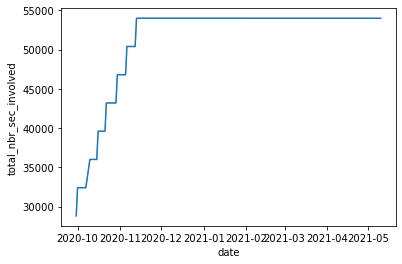

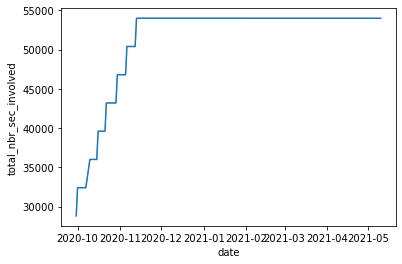

In [82]:
#check the number of secodns compared
sns.lineplot(x='date', y='total_nbr_sec_involved', data=df_prox);

In [83]:
#TODO: check properly once we have defined dates!!
#check number of observations per day per penID
df_ = df_prox.groupby(['date','PenID'])['hen_pair'].count().reset_index()
df_.groupby('date')['hen_pair'].agg(lambda x: list(x)).reset_index()

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,date,hen_pair
0,2020-09-30,"[171, 190, 171, 136, 136, 153, 153, 136, 45, 7..."
1,2020-10-01,"[171, 190, 171, 171, 136, 171, 153, 136, 66, 7..."
2,2020-10-02,"[171, 190, 171, 171, 136, 171, 153, 136, 66, 7..."
3,2020-10-03,"[171, 136, 171, 10, 10, 15, 6, 3, 6, 10, 6]"
4,2020-10-04,"[190, 190, 190, 171, 136, 171, 45, 45, 45, 28,..."
...,...,...
206,2021-05-06,"[190, 190, 171, 171, 190, 190, 190, 190, 36, 3..."
207,2021-05-07,"[190, 190, 171, 171, 190, 190, 190, 190, 36, 3..."
208,2021-05-08,"[190, 190, 171, 171, 190, 190, 190, 190, 36, 3..."
209,2021-05-09,"[190, 190, 171, 171, 190, 190, 190, 190, 36, 3..."


,date,hen_pair
0,2020-09-30,"[171, 190, 171, 136, 136, 153, 153, 136, 45, 7..."
1,2020-10-01,"[171, 190, 171, 171, 136, 171, 153, 136, 66, 7..."
2,2020-10-02,"[171, 190, 171, 171, 136, 171, 153, 136, 66, 7..."
3,2020-10-03,"[171, 136, 171, 10, 10, 15, 6, 3, 6, 10, 6]"
4,2020-10-04,"[190, 190, 190, 171, 136, 171, 45, 45, 45, 28,..."
...,...,...
206,2021-05-06,"[190, 190, 171, 171, 190, 190, 190, 190, 36, 3..."
207,2021-05-07,"[190, 190, 171, 171, 190, 190, 190, 190, 36, 3..."
208,2021-05-08,"[190, 190, 171, 171, 190, 190, 190, 190, 36, 3..."
209,2021-05-09,"[190, 190, 171, 171, 190, 190, 190, 190, 36, 3..."


# Correlations of proximity per true pen & random pen

In [14]:
df_prox = pd.read_csv(os.path.join(path_extracted_data_proximity, 'df_prox.csv'), sep=';', parse_dates=['date'], dayfirst=True) 
df_prox['DIB'] = df_prox['date'].map(lambda x: (x-dt.datetime(2020,9,29)).days)
print(df_prox.shape)
df_prox.head(3) 

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(385570, 18)


,HenID1,HenID2,date,verification,total_nbr_sec_involved,nbr_sec_withCommunZone,PenID1,PenID2,type_,PenID,perc_time_with_communZone,hen_pair,pen_pair,nbr_na,CLASS1,CLASS2,class_pair,DIB
0,hen_131,hen_134,2020-09-30,(),28800,19,pen10,pen10,realpen,pen10,0.065972,hen_131-hen_134,pen10-pen10,0,other,MEXP,MEXP-other,1
1,hen_131,hen_138,2020-09-30,(),28800,20895,pen10,pen10,realpen,pen10,72.552083,hen_131-hen_138,pen10-pen10,0,other,MEXP,MEXP-other,1
2,hen_131,hen_139,2020-09-30,(),28800,1050,pen10,pen10,realpen,pen10,3.645833,hen_131-hen_139,pen10-pen10,0,other,other,other-other,1


In [12]:
#!!    copy paste from: https://gist.github.com/zhiyzuo/d38159a7c48b575af3e3de7501462e04     !!
def pearsonr_ci(x,y,alpha=0.05):
    ''' calculate Pearson correlation along with the confidence interval using scipy and numpy
    Parameters
    ----------
    x, y : iterable object such as a list or np.array
      Input for correlation calculation
    alpha : float
      Significance level. 0.05 by default
    Returns
    -------
    r : float
      Pearson's correlation coefficient
    pval : float
      The corresponding p value
    lo, hi : float
      The lower and upper bound of confidence intervals
    '''

    r, p = stats.pearsonr(x,y)
    r_z = np.arctanh(r)
    se = 1/np.sqrt(x.size-3)
    z = stats.norm.ppf(1-alpha/2)
    lo_z, hi_z = r_z-z*se, r_z+z*se
    lo, hi = np.tanh((lo_z, hi_z))
    return r, p, lo, hi

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


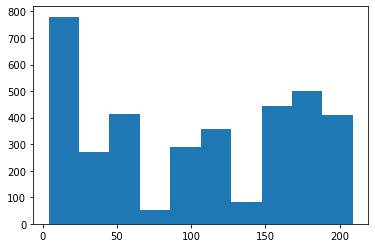

(2264, 216)


date,hen_pair,type_,class_pair,PenID,2020-09-30 00:00:00,2020-10-01 00:00:00,2020-10-02 00:00:00,2020-10-03 00:00:00,2020-10-04 00:00:00,2020-10-05 00:00:00,...,2021-05-02 00:00:00,2021-05-03 00:00:00,2021-05-04 00:00:00,2021-05-05 00:00:00,2021-05-06 00:00:00,2021-05-07 00:00:00,2021-05-08 00:00:00,2021-05-09 00:00:00,2021-05-10 00:00:00,nbr_na
0,hen_1-hen_105,realpen,other-other,pen9,20.524306,53.870370,69.669753,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,102
1,hen_1-hen_106,realpen,MEXP-other,pen9,63.468750,21.820988,0.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,103
3,hen_1-hen_113,realpen,other-other,pen9,65.052083,53.870370,81.916667,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,102
5,hen_1-hen_116,realpen,LEXP-other,pen9,18.013889,52.910494,98.299383,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,102
6,hen_1-hen_120,realpen,LEXP-other,pen9,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,107


(2524, 10)


,coeff,p_val,d1,d2,nbr_obs,L,H,verif,PenID,Pen_type
2519,0.906306,2.854286e-14,2021-05-05,2021-05-06,36,NaN,NaN,"(nan, nan)",pen_R8,RandomPens
2520,0.854826,3.236226e-11,2021-05-06,2021-05-07,36,NaN,NaN,"(nan, nan)",pen_R8,RandomPens
2521,0.733848,3.531648e-07,2021-05-07,2021-05-08,36,NaN,NaN,"(nan, nan)",pen_R8,RandomPens
2522,0.905792,3.120246e-14,2021-05-08,2021-05-09,36,NaN,NaN,"(nan, nan)",pen_R8,RandomPens
2523,0.721925,6.714509e-07,2021-05-09,2021-05-10,36,NaN,NaN,"(nan, nan)",pen_R8,RandomPens


In [17]:
#put the date into the columns, so that we can correlate date x with date x+1
df_pivot = df_prox.pivot(index=['hen_pair','type_','class_pair','PenID'], values='perc_time_with_communZone', columns='date').reset_index()
df_pivot['nbr_na'] = df_pivot.isnull().sum(axis=1)
plt.hist(df_pivot['nbr_na'])
plt.show()
df_pivot = df_pivot[df_pivot['nbr_na']<150]
print(df_pivot.shape)
display(df_pivot.head(5))

li_date = sorted(set(df_daily['level'].tolist()))
#initialize list to save results
li = []
#for pendID, df_ in df_pivot[df_pivot['class_pair'].isin(['LEXP-MEXP','MEXP-MEXP','LEXP-LEXP'])].groupby(['PenID']):
for pendID, df_ in df_pivot.groupby(['PenID']):
    li_date_ = [x for x in li_date if x in list(df_.columns)]
    for d1 in li_date_: 
        d2 = d1+dt.timedelta(days=1)
        if d2 in li_date_:
            df__ = df_.dropna(subset=[d1,d2])
            #lets for now set a need of at least 50 obs to compute a correlation
            if df__.shape[0]>30:
                coeff, p_val = spearmanr(df__[d1].tolist(), df__[d2].tolist()) #coeff, p-val
                r, p, lo, hi = np.nan, np.nan, np.nan, np.nan
                #coeff, p_val = pearsonr(df__[d1].tolist(), df__[d2].tolist()) #coeff, p-val
                #r, p, lo, hi = pearsonr_ci(np.array(df__[d1].tolist()), np.array(df__[d2].tolist()))
                #update results
                li.append({'coeff':coeff, 'p_val':p_val, 'd1':d1, 'd2':d2, 'nbr_obs':df__.shape[0],
                           'L':lo, 'H':hi,'verif':(r,p),'PenID':pendID})
df_corr_res = pd.DataFrame(li)
df_corr_res['Pen_type'] = df_corr_res['PenID'].map(lambda x: 'RandomPens' if '_R' in x else 'RealPens')
#save
df_corr_res.to_csv(os.path.join(path_extracted_data_proximity, 'df_corr_res.csv'), index=False, sep=';')
print(df_corr_res.shape)
display(df_corr_res.tail(5))

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


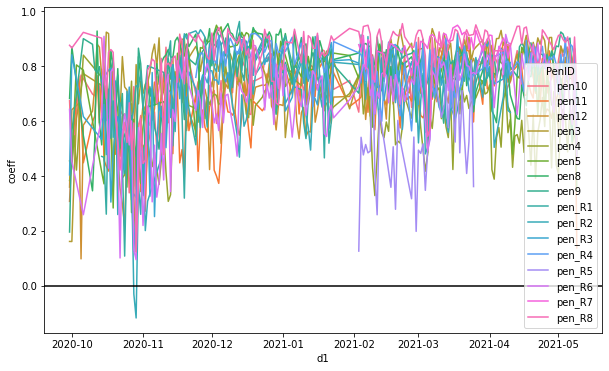

In [18]:
#Visual
#df_plt = df_corr_res[df_corr_res['nbr_obs']>=80].copy()
#future MLPs alltreatment
fig = plt.figure(figsize=(10, 6))
graph = sns.lineplot(x='d1',y='coeff',hue='PenID',data=df_corr_res);
graph.axhline(0, color='black')
plt.savefig(os.path.join(path_extracted_data_proximity, 'Proximity_correalationdayx&dayx+1.png'), dpi=300,
            format='png',bbox_inches='tight')
plt.show()

In [ ]:
#Visual
#df_plt = df_corr_res[df_corr_res['nbr_obs']>=80].copy()
#future MLPs alltreatment
fig = plt.figure(figsize=(10, 6))
graph = sns.lineplot(x='d1',y='coeff',hue='Pen_type',data=df_corr_res);
graph.axhline(0, color='black')
plt.savefig(os.path.join(path_extracted_data_proximity, 'Proximity_correalationdayx&dayx+1_pentype.png'), dpi=300,
            format='png',bbox_inches='tight')
plt.show()

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
#Visual
#df_plt = df_corr_res[df_corr_res['nbr_obs']>=80].copy()
#future MLPs alltreatment
fig = plt.figure(figsize=(10, 6))
graph = sns.lineplot(x='d1',y='coeff',hue='Pen_type',data=df_corr_res)#[df_corr_res['d1']>dt.datetime(2020,10,29)]);
graph.axhline(0, color='black')
plt.savefig(os.path.join(path_extracted_data_proximity, 'Proximity_correalationdayx&dayx+1_pentype.png'), dpi=300,
            format='png',bbox_inches='tight')
plt.show()

# Proximity per hen pair

In [ ]:
df_prox = pd.read_csv(os.path.join(path_extracted_data_proximity, 'df_prox.csv'), sep=';', parse_dates=['date'], dayfirst=True) 
df_prox['DIB'] = df_prox['date'].map(lambda x: (x-dt.datetime(2020,9,29)).days)
print(df_prox.shape)
df_prox.head(3) 

In [289]:
#df_prox[['hen_pair','PenID','date','perc_time_with_communZone']].head(3)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [290]:
li = []
for penID, df_ in df_prox.groupby(['PenID']):
    df_pr_pair = df_.pivot(index='DIB', columns='hen_pair', values='perc_time_with_communZone').reset_index()
    #display(df_pr_pair.head(3))
    for henpair in df_['hen_pair'].unique():
        df__ = df_pr_pair.dropna(subset=[henpair,'DIB'])
        #lets for now set a need of at least 50 obs to compute a correlation
        if df__.shape[0]>30:
            coeff, p_val = pearsonr(df__[henpair].tolist(), df__['DIB'].tolist()) #coeff, p-val
            r, p, lo, hi = pearsonr_ci(np.array(df__[henpair].tolist()), np.array(df__['DIB'].tolist()))
            #update results
            li.append({'coeff':coeff, 'p_val':p_val, 'L':lo, 'H':hi,'verif':(r,p), 
                       'henpair':henpair, 'PenID':penID,
                       'nbr_obs':df__.shape[0], 'startingdate':df__['DIB'].min(), 'endingdate':df__['DIB'].max()})
df_corr_res = pd.DataFrame(li)
df_corr_res['Pen_type'] = df_corr_res['PenID'].map(lambda x: 'RandomPens' if '_R' in x else 'RealPens')
#save
df_corr_res.to_csv(os.path.join(path_extracted_data_proximity, 'df_corr_res_henpair.csv'), index=False, sep=';')
print(df_corr_res.shape)
display(df_corr_res.tail(5))

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(2784, 11)
(2784, 11)


,coeff,p_val,L,H,verif,henpair,PenID,nbr_obs,startingdate,endingdate,Pen_type
2779,0.611289,3.769306e-17,0.501627,0.701616,"(0.611289160345269, 3.769305528663597e-17)",hen_13-hen_187,pen_R8,154,56,223,RandomPens
2780,0.634116,1.065631e-18,0.529012,0.720061,"(0.6341164162354297, 1.0656307732848275e-18)",hen_187-hen_48,pen_R8,154,56,223,RandomPens
2781,0.237424,2.933369e-03,0.082878,0.380819,"(0.23742425362972797, 0.0029333690968702288)",hen_167-hen_187,pen_R8,155,56,223,RandomPens
2782,-0.787455,2.272014e-13,-0.869000,-0.664269,"(-0.7874550423421671, 2.272014447622839e-13)",hen_126-hen_187,pen_R8,58,56,117,RandomPens
2783,0.350889,9.996808e-06,0.202511,0.483518,"(0.35088888698879733, 9.996807686194682e-06)",hen_106-hen_187,pen_R8,151,56,223,RandomPens


,coeff,p_val,L,H,verif,henpair,PenID,nbr_obs,startingdate,endingdate,Pen_type
2779,0.611289,3.769306e-17,0.501627,0.701616,"(0.611289160345269, 3.769305528663597e-17)",hen_13-hen_187,pen_R8,154,56,223,RandomPens
2780,0.634116,1.065631e-18,0.529012,0.720061,"(0.6341164162354297, 1.0656307732848275e-18)",hen_187-hen_48,pen_R8,154,56,223,RandomPens
2781,0.237424,2.933369e-03,0.082878,0.380819,"(0.23742425362972797, 0.0029333690968702288)",hen_167-hen_187,pen_R8,155,56,223,RandomPens
2782,-0.787455,2.272014e-13,-0.869000,-0.664269,"(-0.7874550423421671, 2.272014447622839e-13)",hen_126-hen_187,pen_R8,58,56,117,RandomPens
2783,0.350889,9.996808e-06,0.202511,0.483518,"(0.35088888698879733, 9.996807686194682e-06)",hen_106-hen_187,pen_R8,151,56,223,RandomPens


In [68]:
df_corr_res = pd.read_csv(os.path.join(path_extracted_data_proximity, 'df_corr_res_henpair.csv'), sep=';') 
print(df_corr_res.shape)
display(df_corr_res.tail(5))

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(2784, 11)


,coeff,p_val,L,H,verif,henpair,PenID,nbr_obs,startingdate,endingdate,Pen_type
2779,0.611289,3.769306e-17,0.501627,0.701616,"(0.611289160345269, 3.769305528663597e-17)",hen_13-hen_187,pen_R8,154,56,223,RandomPens
2780,0.634116,1.065631e-18,0.529012,0.720061,"(0.6341164162354297, 1.0656307732848275e-18)",hen_187-hen_48,pen_R8,154,56,223,RandomPens
2781,0.237424,2.933369e-03,0.082878,0.380819,"(0.23742425362972797, 0.0029333690968702288)",hen_167-hen_187,pen_R8,155,56,223,RandomPens
2782,-0.787455,2.272014e-13,-0.869000,-0.664269,"(-0.7874550423421671, 2.272014447622839e-13)",hen_126-hen_187,pen_R8,58,56,117,RandomPens
2783,0.350889,9.996808e-06,0.202511,0.483518,"(0.35088888698879733, 9.996807686194682e-06)",hen_106-hen_187,pen_R8,151,56,223,RandomPens


In [69]:
#plt.hist(df_corr_res['startingdate']);

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [70]:
#plt.hist(df_corr_res['nbr_obs']);

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [71]:
df_interesting = df_corr_res[(df_corr_res['nbr_obs']>30)&(df_corr_res['startingdate']<20)&(df_corr_res['p_val']<0.01)]
df_interesting.shape

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(1165, 11)

In [90]:
df_corr_res['significant_0-01'] = df_corr_res['p_val'].map(lambda x: x<0.01)
df_corr_res['type'] = df_corr_res.apply(lambda x: 'notsignificant' if x['significant_0-01']==False else str(int(np.sign(x['coeff']))),
                                        axis=1)
df_corr_res['type'].value_counts(normalize=True)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


notsignificant    0.396911
1                 0.334052
-1                0.269037
Name: type, dtype: float64

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\camil\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\camil\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-

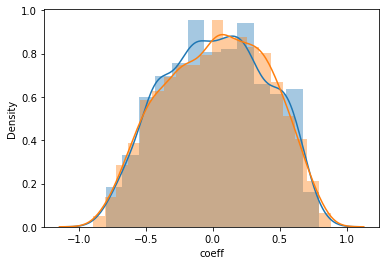

In [116]:
#Here is the density of the coefficient value per pen:
for p, df_ in df_corr_res.groupby(['Pen_type']):
    sns.distplot(df_['coeff'])
plt.savefig(os.path.join(path_extracted_data_proximity, 'Proximity_densityCoefficient_perpentype.png'), dpi=300,
            format='png',bbox_inches='tight')
plt.show()

In [146]:
df_ = df_corr_res.groupby(['PenID','Pen_type'])['type'].agg(lambda x: list(x)).reset_index()
df_['perc_type_significant_positive'] = df_['type'].map(lambda x: sum([i=='1' for i in x])/len(x)*100)
df_['perc_type_significant_negative'] = df_['type'].map(lambda x: sum([i=='-1' for i in x])/len(x)*100)
df_['perc_type_unsignificant'] = df_['type'].map(lambda x: sum([i=='notsignificant' for i in x])/len(x)*100)
df__ = df_.groupby(['Pen_type'])['perc_type_significant_positive','perc_type_significant_negative','perc_type_unsignificant'].agg(lambda x: list(x)).reset_index()
for t in ['perc_type_significant_positive','perc_type_significant_negative','perc_type_unsignificant']:
    df__['mean +/- SD'+t] = df__[t].map(lambda x: str(int(round(np.mean(x),0)))+'%  +/-'+str(int(round(np.std(x))))+'%')
df__  = df__.drop(['perc_type_significant_positive','perc_type_significant_negative','perc_type_unsignificant'], axis=1)
df__

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-146-ee9cbe2a2a8f>:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df__ = df_.groupby(['Pen_type'])['perc_type_significant_positive','perc_type_significant_negative','perc_type_unsignificant'].agg(lambda x: list(x)).reset_index()


,Pen_type,mean +/- SDperc_type_significant_positive,mean +/- SDperc_type_significant_negative,mean +/- SDperc_type_unsignificant
0,RandomPens,30% +/-10%,26% +/-9%,44% +/-12%
1,RealPens,34% +/-9%,28% +/-9%,38% +/-3%


In [147]:
df_

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,PenID,Pen_type,type,perc_type_significant_positive,perc_type_significant_negative,perc_type_unsignificant
0,pen10,RealPens,"[1, notsignificant, -1, 1, notsignificant, 1, ...",42.803030,16.287879,40.909091
1,pen11,RealPens,"[1, -1, 1, -1, notsignificant, notsignificant,...",35.227273,26.515152,38.257576
2,pen12,RealPens,"[notsignificant, notsignificant, notsignifican...",26.936027,30.976431,42.087542
3,pen3,RealPens,"[notsignificant, -1, -1, -1, 1, -1, -1, -1, no...",29.389313,30.534351,40.076336
4,pen4,RealPens,"[notsignificant, -1, 1, 1, 1, -1, 1, -1, 1, no...",52.272727,12.121212,35.606061
5,pen5,RealPens,"[1, notsignificant, 1, -1, 1, 1, 1, 1, 1, nots...",36.065574,31.967213,31.967213
6,pen8,RealPens,"[-1, -1, -1, -1, notsignificant, notsignifican...",33.846154,28.076923,38.076923
7,pen9,RealPens,"[-1, -1, -1, -1, -1, -1, -1, -1, notsignifican...",19.083969,43.893130,37.022901
8,pen_R1,RandomPens,"[notsignificant, 1, notsignificant, 1, 1, nots...",42.222222,24.444444,33.333333
9,pen_R2,RandomPens,"[notsignificant, 1, 1, 1, notsignificant, nots...",24.000000,15.000000,61.000000


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Pen_type,variable,value
0,RealPens,perc_type_significant_positive,42.803030
1,RealPens,perc_type_significant_positive,35.227273
2,RealPens,perc_type_significant_positive,26.936027
3,RealPens,perc_type_significant_positive,29.389313
4,RealPens,perc_type_significant_positive,52.272727
5,RealPens,perc_type_significant_positive,36.065574
6,RealPens,perc_type_significant_positive,33.846154
7,RealPens,perc_type_significant_positive,19.083969
8,RandomPens,perc_type_significant_positive,42.222222
9,RandomPens,perc_type_significant_positive,24.000000


<AxesSubplot:xlabel='variable', ylabel='value'>

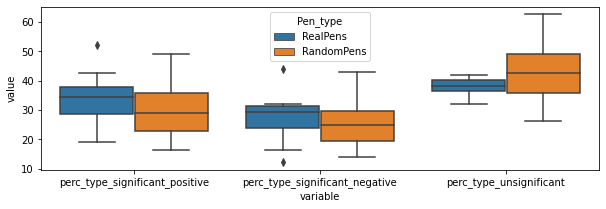

In [155]:
df___ = pd.melt(df_, id_vars='Pen_type', value_vars=['perc_type_significant_positive','perc_type_significant_negative','perc_type_unsignificant'])
display(df___)
fig = plt.figure(figsize=(10,3))
sns.boxplot(data=df___, hue='Pen_type',x='variable',y='value') 

In [112]:
print(len(df_corr_res[df_corr_res['Pen_type']=='RealPens']['henpair'].unique()))
print('real pens: ')
print(df_corr_res[df_corr_res['Pen_type']=='RealPens']['type'].value_counts(normalize=True))
print('random pens: ')
print(df_corr_res[df_corr_res['Pen_type']=='RandomPens']['type'].value_counts(normalize=True))

2117
real pens: 
notsignificant    0.38120
1                 0.34341
-1                0.27539
Name: type, dtype: float64
random pens: 
notsignificant    0.446777
1                 0.304348
-1                0.248876
Name: type, dtype: float64


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
df_corr_res.groupby(['PenID'])

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


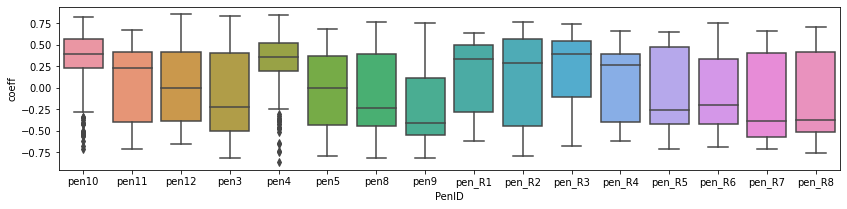

In [75]:
fig = plt.figure(figsize=(14,3))
sns.boxplot(x='PenID', y='coeff', data=df_interesting);

# Correlation & tipping point - both direction

In [20]:
li = []
for penID, df_ in tqdm.tqdm(df_prox.groupby(['PenID'])):
    if '_R' not in penID:
        li_pair = df_['hen_pair'].unique()
        df_pr_pair = df_.pivot(index='DIB', columns='hen_pair', values='perc_time_with_communZone').reset_index()
        #display(df_pr_pair.head(3))
        #lets comute for every day, all correlations for which henspair have a co-occurence value
        for d in df_pr_pair['DIB'].unique():
            df_dib1 = df_pr_pair[df_pr_pair['DIB']>=d]
            df_dib2 = df_pr_pair[df_pr_pair['DIB']<=d]
            for henpair in li_pair:
                df__1 = df_dib1.dropna(subset=[henpair,'DIB'])
                df__2 = df_dib2.dropna(subset=[henpair,'DIB'])
                dico_ = {}
                if (df__1['DIB'].min()==d):
                    coeff1 = np.nan ; coeff2 = np.nan
                    p_val1 = np.nan ; p_val2 = np.nan
                    if (df__1.shape[0]>20):
                        coeff1, p_val1 = pearsonr(df__1[henpair].tolist(), df__1['DIB'].tolist()) #coeff, p-val
                    if (df__2.shape[0]>20):
                        coeff2, p_val2 = pearsonr(df__2[henpair].tolist(), df__2['DIB'].tolist()) #coeff, p-val
                    #update results
                    li.append({'before_coeff':coeff2, 'before_p_val':p_val2,'before_nbr_obs':df__2.shape[0],
                               'after_coeff':coeff1, 'after_p_val':p_val1,'after_nbr_obs':df__1.shape[0],
                               'henpair':henpair, 'PenID':penID,
                               'Middledate':d, 'maxdate':df__1['DIB'].max(),'mindate':df__2['DIB'].min(),
                               'MiddleValue': df__1[df__1['DIB']==d][henpair].values[0]})
df_corr_tp = pd.DataFrame(li)
df_corr_tp['Pen_type'] = df_corr_tp['PenID'].map(lambda x: 'RandomPens' if '_R' in x else 'RealPens')
df_corr_tp['startingdate_WIB'] = df_corr_tp['Middledate'].map(lambda x: int((x-1)/7)+1)
df_corr_tp['MiddleValue_class'] = df_corr_tp['MiddleValue'].map(lambda x: round(x/10,0)*10)
display(df_corr_tp['MiddleValue_class'].value_counts())
df_corr_tp['before_significant'] = df_corr_tp['before_p_val'].map(lambda x: x<0.01)
df_corr_tp['after_significant'] = df_corr_tp['after_p_val'].map(lambda x: x<0.01)
#save
df_corr_tp.to_csv(os.path.join(path_extracted_data_proximity, 'df_corr_tp_henpair_TP_BA.csv'), index=False, sep=';')
print(df_corr_tp.shape)
display(df_corr_tp.tail(5))

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [31:31<00:00, 118.24s/it]


30.0     85264
40.0     74759
20.0     57246
50.0     33458
10.0     25881
60.0      9481
0.0       4512
70.0      4212
80.0      2021
100.0     1455
90.0      1071
Name: MiddleValue_class, dtype: int64

(299360, 17)


,before_coeff,before_p_val,before_nbr_obs,after_coeff,after_p_val,after_nbr_obs,henpair,PenID,Middledate,maxdate,mindate,MiddleValue,Pen_type,startingdate_WIB,MiddleValue_class,before_significant,after_significant
299355,-0.140799,0.474830,28,NaN,NaN,1,hen_233-hen_3,pen9,223,223,196,64.059259,RealPens,32,60.0,False,False
299356,0.232926,0.232938,28,NaN,NaN,1,hen_233-hen_5,pen9,223,223,196,72.300000,RealPens,32,70.0,False,False
299357,-0.552015,0.002323,28,NaN,NaN,1,hen_233-hen_90,pen9,223,223,196,11.920370,RealPens,32,10.0,True,False
299358,0.217785,0.265581,28,NaN,NaN,1,hen_233-hen_93,pen9,223,223,196,68.590741,RealPens,32,70.0,False,False
299359,0.047001,0.812269,28,NaN,NaN,1,hen_233-hen_98,pen9,223,223,196,16.435185,RealPens,32,20.0,False,False


In [23]:
df_corr_tp['before_type'] = df_corr_tp.apply(lambda x: 'X' if x['before_significant']==False else str(int(np.sign(x['before_coeff']))), 
                                             axis=1)
df_corr_tp['after_type'] = df_corr_tp.apply(lambda x: 'X' if x['after_significant']==False else str(int(np.sign(x['after_coeff']))), 
                                            axis=1)
df_corr_tp['crv_type'] = df_corr_tp.apply(lambda x: x['before_type']+x['after_type'], axis=1)
df_corr_tp['crv_type'].value_counts()

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


XX      100742
1X       47597
-1X      42404
X1       38712
X-1      27410
-11      15347
1-1      11304
11        8424
-1-1      7420
Name: crv_type, dtype: int64

In [44]:
len(set(df_corr_tp['henpair'].unique()))

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


2760

(95, 5)


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,crv_type,MiddleValue_class,henpair,nbr_obs,nbr_diff_henpair
0,-1-1,0.0,"[hen_177-hen_193, hen_140-hen_193, hen_39-hen_...",33,17
1,-1-1,10.0,"[hen_145-hen_78, hen_145-hen_78, hen_139-hen_1...",674,118
2,-1-1,20.0,"[hen_134-hen_78, hen_145-hen_78, hen_143-hen_5...",1770,228


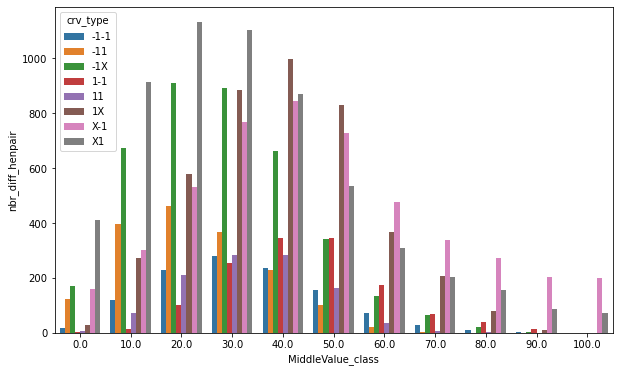

In [46]:
fig = plt.figure(figsize=(10, 6))
df_ = df_corr_tp.groupby(['crv_type','MiddleValue_class'])['henpair'].agg(lambda x: list(x)).reset_index()
df_['nbr_obs'] = df_['henpair'].map(lambda x: len(x))
df_['nbr_diff_henpair'] = df_['henpair'].map(lambda x: len(set(x)))
print(df_.shape)
display(df_.head(3))
sns.barplot(x="MiddleValue_class", y="nbr_diff_henpair", hue="crv_type", data=df_[df_['crv_type']!='XX']);

In [47]:
df_corr_tp.head(2)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,before_coeff,before_p_val,before_nbr_obs,after_coeff,after_p_val,after_nbr_obs,henpair,PenID,Middledate,maxdate,mindate,MiddleValue,Pen_type,startingdate_WIB,MiddleValue_class,before_significant,after_significant,before_type,after_type,crv_type
0,NaN,NaN,1,0.308419,0.000889,113,hen_131-hen_134,pen10,1,124,1,0.065972,RealPens,1,0.0,False,True,X,1,X1
1,NaN,NaN,1,0.009201,0.922951,113,hen_131-hen_138,pen10,1,124,1,72.552083,RealPens,1,70.0,False,False,X,X,XX


In [49]:
df_corr_tp[df_corr_tp['henpair']=='hen_131-hen_138']['after_coeff']

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,before_coeff,before_p_val,before_nbr_obs,after_coeff,after_p_val,after_nbr_obs,henpair,PenID,Middledate,maxdate,mindate,MiddleValue,Pen_type,startingdate_WIB,MiddleValue_class,before_significant,after_significant,before_type,after_type,crv_type
1,NaN,NaN,1,0.009201,0.922951,113,hen_131-hen_138,pen10,1,124,1,72.552083,RealPens,1,70.0,False,False,X,X,XX
172,NaN,NaN,2,0.072085,0.450069,112,hen_131-hen_138,pen10,2,124,1,69.645062,RealPens,1,70.0,False,False,X,X,XX
343,NaN,NaN,3,0.139231,0.145008,111,hen_131-hen_138,pen10,3,124,1,23.209877,RealPens,1,20.0,False,False,X,X,XX
514,NaN,NaN,4,0.114426,0.233922,110,hen_131-hen_138,pen10,5,124,1,43.555556,RealPens,1,40.0,False,False,X,X,XX
704,NaN,NaN,5,0.127493,0.186462,109,hen_131-hen_138,pen10,6,124,1,58.811728,RealPens,1,60.0,False,False,X,X,XX
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20445,-0.010434,0.914252,109,NaN,NaN,5,hen_131-hen_138,pen10,115,124,1,38.270370,RealPens,17,40.0,False,False,X,X,XX
20635,0.000629,0.994792,110,NaN,NaN,4,hen_131-hen_138,pen10,116,124,1,44.837037,RealPens,17,40.0,False,False,X,X,XX
20825,-0.002276,0.981085,111,NaN,NaN,3,hen_131-hen_138,pen10,117,124,1,36.514815,RealPens,17,40.0,False,False,X,X,XX
21015,-0.000208,0.998261,112,NaN,NaN,2,hen_131-hen_138,pen10,123,124,1,39.416667,RealPens,18,40.0,False,False,X,X,XX


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


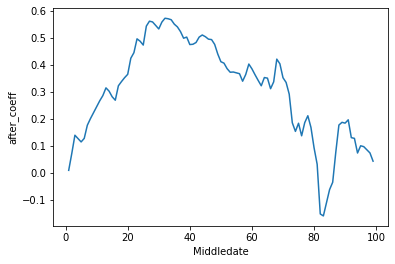

In [55]:
sns.lineplot(x='Middledate', y='after_coeff', data=df_corr_tp[df_corr_tp['henpair']=='hen_131-hen_138']);

In [97]:
df_ = df_prox[df_prox['hen_pair']=='hen_131-hen_138']
pearsonr(df_['perc_time_with_communZone'].tolist(), df_['DIB'].tolist())

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(0.009200528503300678, 0.9229506937386863)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


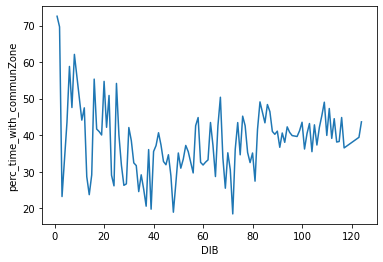

In [95]:
sns.lineplot(x='DIB', y='perc_time_with_communZone', data=df_prox[df_prox['hen_pair']=='hen_131-hen_138']);

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


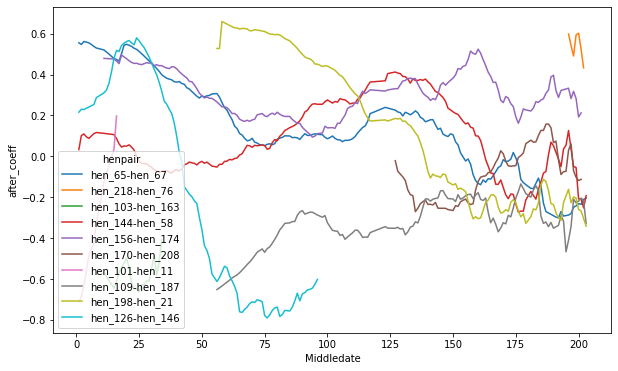

In [64]:
fig = plt.figure(figsize=(10, 6))
random.seed(0)
li = random.sample(list(df_corr_tp['henpair'].unique()), 10)
sns.lineplot(x='Middledate', y='after_coeff', data=df_corr_tp[df_corr_tp['henpair'].isin(li)], hue='henpair');

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


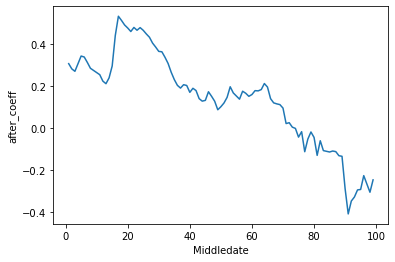

In [53]:
sns.lineplot(x='Middledate', y='after_coeff', data=df_corr_tp[df_corr_tp['henpair']=='hen_131-hen_134']);

In [79]:
df_corr_tp.head(3)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,before_coeff,before_p_val,before_nbr_obs,after_coeff,after_p_val,after_nbr_obs,henpair,PenID,Middledate,maxdate,mindate,MiddleValue,Pen_type,startingdate_WIB,MiddleValue_class,before_significant,after_significant,before_type,after_type,crv_type
0,NaN,NaN,1,0.308419,0.000889,113,hen_131-hen_134,pen10,1,124,1,0.065972,RealPens,1,0.0,False,True,X,1,X1
1,NaN,NaN,1,0.009201,0.922951,113,hen_131-hen_138,pen10,1,124,1,72.552083,RealPens,1,70.0,False,False,X,X,XX
2,NaN,NaN,1,-0.257257,0.005946,113,hen_131-hen_139,pen10,1,124,1,3.645833,RealPens,1,0.0,False,True,X,-1,X-1


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


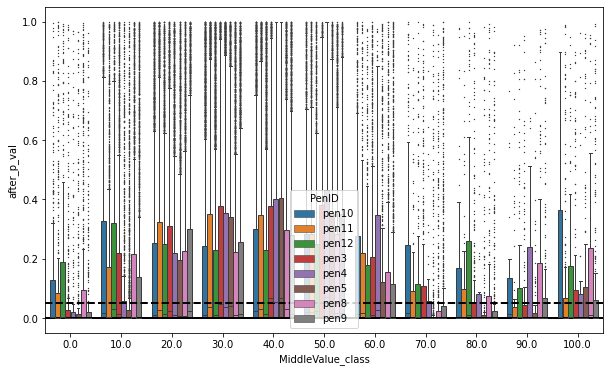

In [86]:
#plot depending on the starting point value, the p-value
fig = plt.figure(figsize=(10, 6))
sns.boxplot(x='MiddleValue_class', y='after_p_val', data=df_corr_tp[df_corr_tp['after_nbr_obs']>30], hue='PenID',
           fliersize=0.5, linewidth=1);
plt.axhline(y=0, xmin=0, xmax=100, linewidth=2, color = 'k');
plt.savefig(os.path.join(path_extracted_data_proximity, 'Proximity_MiddlePoint_pval_perpen.png'), dpi=300,
            format='png',bbox_inches='tight')
plt.axhline(y=0.05, xmin=0, xmax=100, linewidth=2, color = 'k', linestyle='dashed')
plt.show()

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


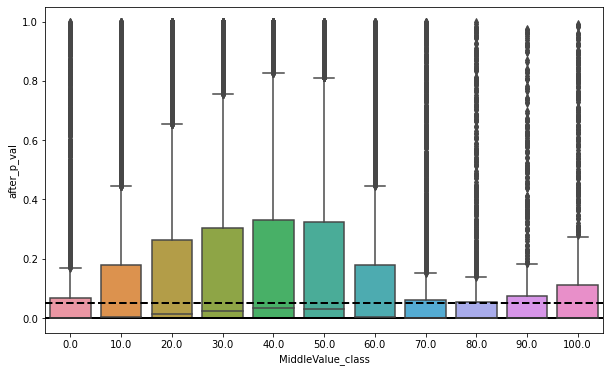

In [87]:
#plot depending on the starting point value, the p-value
fig = plt.figure(figsize=(10, 6))
sns.boxplot(x='MiddleValue_class', y='after_p_val', data=df_corr_tp[df_corr_tp['after_nbr_obs']>30]);
plt.axhline(y=0, xmin=0, xmax=100, linewidth=2, color = 'k');
plt.savefig(os.path.join(path_extracted_data_proximity, 'Proximity_MiddlePoint_pval.png'), dpi=300,
            format='png',bbox_inches='tight')
plt.axhline(y=0.05, xmin=0, xmax=100, linewidth=2, color = 'k', linestyle='dashed')
plt.show()

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


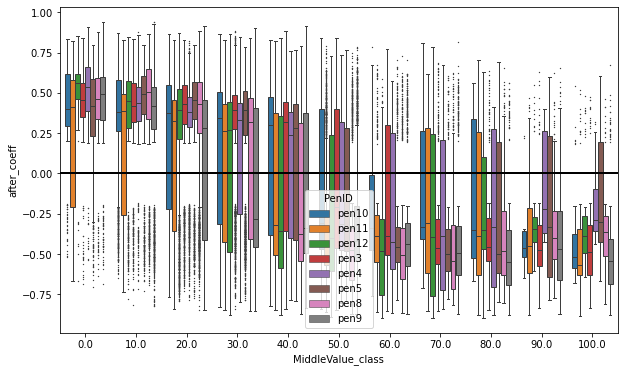

In [88]:
#plot depending on the starting point value, the coefficient, when p-value<0.01
fig = plt.figure(figsize=(10, 6))
sns.boxplot(x='MiddleValue_class', y='after_coeff', data=df_corr_tp[(df_corr_tp['after_nbr_obs']>30)&(df_corr_tp['after_significant'])],
            hue='PenID', fliersize=0.5, linewidth=1);
plt.axhline(y=0, xmin=0, xmax=100, linewidth=2, color = 'k');
plt.savefig(os.path.join(path_extracted_data_proximity, 'Proximity_MiddlePoint_coeff_perpen.png'), dpi=300,
            format='png',bbox_inches='tight')
plt.show()

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


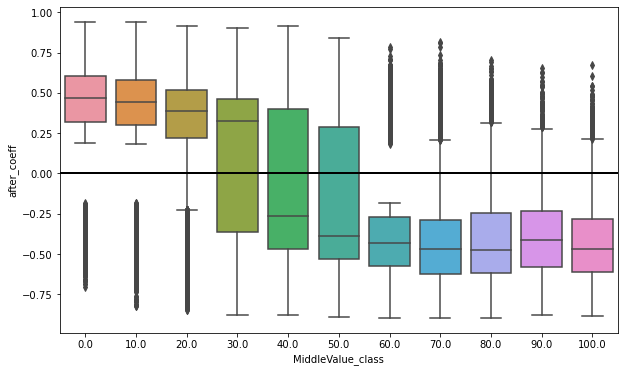

In [89]:
#plot depending on the starting point value, the coefficient, when p-value<0.01
fig = plt.figure(figsize=(10, 6))
sns.boxplot(x='MiddleValue_class', y='after_coeff', data=df_corr_tp[(df_corr_tp['after_nbr_obs']>30)&(df_corr_tp['after_significant'])]);
plt.axhline(y=0, xmin=0, xmax=100, linewidth=2, color = 'k');
plt.savefig(os.path.join(path_extracted_data_proximity, 'Proximity_MiddlePoint_coeff.png'), dpi=300,
            format='png',bbox_inches='tight')
plt.show()

# Correlation & tipping point - one direction

In [304]:
li = []
for penID, df_ in tqdm.tqdm(df_prox.groupby(['PenID'])):
    li_pair = df_['hen_pair'].unique()
    df_pr_pair = df_.pivot(index='DIB', columns='hen_pair', values='perc_time_with_communZone').reset_index()
    #display(df_pr_pair.head(3))
    #lets comute for every day, all correlations for which henspair have a co-occurence value
    for d in df_pr_pair['DIB'].unique():
        df_dib = df_pr_pair[df_pr_pair['DIB']>=d]
        for henpair in li_pair:
            df__ = df_dib.dropna(subset=[henpair,'DIB'])
            if df__['DIB'].min()==d:
                #lets for now set a need of at least 30 obs to compute a correlation
                if df__.shape[0]>30:
                    coeff, p_val = pearsonr(df__[henpair].tolist(), df__['DIB'].tolist()) #coeff, p-val
                    r, p, lo, hi = pearsonr_ci(np.array(df__[henpair].tolist()), np.array(df__['DIB'].tolist()))
                    #update results
                    li.append({'coeff':coeff, 'p_val':p_val, 'L':lo, 'H':hi,'verif':(r,p), 
                               'henpair':henpair, 'PenID':penID,
                               'nbr_obs':df__.shape[0], 'startingdate':df__['DIB'].min(), 'endingdate':df__['DIB'].max(),
                               'startingValue': df__[df__['DIB']==d][henpair].values[0]})
df_corr_tp = pd.DataFrame(li)
df_corr_tp['Pen_type'] = df_corr_tp['PenID'].map(lambda x: 'RandomPens' if '_R' in x else 'RealPens')
df_corr_tp['startingdate_WIB'] = df_corr_tp['startingdate'].map(lambda x: int((x-1)/7)+1)
df_corr_tp['startingValue_class'] = df_corr_tp['startingValue'].map(lambda x: round(x/10,0)*10)
df_corr_tp['startingValue_class'].value_counts()
#save
df_corr_tp.to_csv(os.path.join(path_extracted_data_proximity, 'df_corr_tp_henpair_TP.csv'), index=False, sep=';')
print(df_corr_tp.shape)
display(df_corr_tp.tail(5))

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
  0%|                                                                                           | 0/16 [00:00<?, ?it/s]C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
  0%|                                                                                           | 0/16 [00:00<?, ?it/s]

  0%|                                       

 58%|██████████████████████████████████████████████▍                                 | 120/207 [01:03<00:46,  1.88it/s]

 58%|██████████████████████████████████████████████▊                                 | 121/207 [01:03<00:45,  1.89it/s]

 59%|███████████████████████████████████████████████▏                                | 122/207 [01:04<00:45,  1.87it/s]

 59%|███████████████████████████████████████████████▌                                | 123/207 [01:04<00:44,  1.88it/s]

 60%|███████████████████████████████████████████████▉                                | 124/207 [01:05<00:44,  1.86it/s]

 60%|████████████████████████████████████████████████▎                               | 125/207 [01:05<00:43,  1.88it/s]

 61%|████████████████████████████████████████████████▋                               | 126/207 [01:06<00:42,  1.89it/s]

 61%|█████████████████████████████████████████████████                               | 127/207 [01:06<00:42,  1.90it/s]

 62%|███████████████████████████

 18%|██████████████▉                                                                  | 38/206 [00:21<01:39,  1.69it/s]

 19%|███████████████▎                                                                 | 39/206 [00:21<01:36,  1.73it/s]

 19%|███████████████▋                                                                 | 40/206 [00:22<01:34,  1.76it/s]

 20%|████████████████                                                                 | 41/206 [00:22<01:31,  1.81it/s]

 20%|████████████████▌                                                                | 42/206 [00:23<01:28,  1.85it/s]

 21%|████████████████▉                                                                | 43/206 [00:23<01:26,  1.88it/s]

 21%|█████████████████▎                                                               | 44/206 [00:24<01:26,  1.88it/s]

 22%|█████████████████▋                                                               | 45/206 [00:24<01:24,  1.90it/s]

 22%|██████████████████         

 81%|████████████████████████████████████████████████████████████████▍               | 166/206 [01:28<00:19,  2.02it/s]

 81%|████████████████████████████████████████████████████████████████▊               | 167/206 [01:29<00:19,  2.02it/s]

 82%|█████████████████████████████████████████████████████████████████▏              | 168/206 [01:29<00:18,  2.02it/s]

 82%|█████████████████████████████████████████████████████████████████▋              | 169/206 [01:30<00:18,  2.03it/s]

 83%|██████████████████████████████████████████████████████████████████              | 170/206 [01:30<00:17,  2.01it/s]

 83%|██████████████████████████████████████████████████████████████████▍             | 171/206 [01:31<00:17,  2.00it/s]

 83%|██████████████████████████████████████████████████████████████████▊             | 172/206 [01:31<00:16,  2.01it/s]

 84%|███████████████████████████████████████████████████████████████████▏            | 173/206 [01:32<00:16,  2.01it/s]

 84%|███████████████████████████

 41%|█████████████████████████████████▎                                               | 85/207 [00:50<01:11,  1.70it/s]

 42%|█████████████████████████████████▋                                               | 86/207 [00:50<01:11,  1.70it/s]

 42%|██████████████████████████████████                                               | 87/207 [00:51<01:09,  1.72it/s]

 43%|██████████████████████████████████▍                                              | 88/207 [00:51<01:08,  1.73it/s]

 43%|██████████████████████████████████▊                                              | 89/207 [00:52<01:07,  1.75it/s]

 43%|███████████████████████████████████▏                                             | 90/207 [00:53<01:06,  1.77it/s]

 44%|███████████████████████████████████▌                                             | 91/207 [00:53<01:05,  1.78it/s]

 44%|████████████████████████████████████                                             | 92/207 [00:54<01:04,  1.78it/s]

 45%|███████████████████████████

  1%|█▏                                                                                | 3/203 [00:01<01:46,  1.88it/s]

  2%|█▌                                                                                | 4/203 [00:02<01:47,  1.86it/s]

  2%|██                                                                                | 5/203 [00:02<01:47,  1.85it/s]

  3%|██▍                                                                               | 6/203 [00:03<01:46,  1.85it/s]

  3%|██▊                                                                               | 7/203 [00:03<01:44,  1.88it/s]

  4%|███▏                                                                              | 8/203 [00:04<01:45,  1.86it/s]

  4%|███▋                                                                              | 9/203 [00:04<01:48,  1.78it/s]

  5%|███▉                                                                             | 10/203 [00:05<01:52,  1.71it/s]

  5%|████▍                      

 65%|███████████████████████████████████████████████████▋                            | 131/203 [01:10<00:39,  1.80it/s]

 65%|████████████████████████████████████████████████████                            | 132/203 [01:11<00:41,  1.71it/s]

 66%|████████████████████████████████████████████████████▍                           | 133/203 [01:11<00:40,  1.72it/s]

 66%|████████████████████████████████████████████████████▊                           | 134/203 [01:12<00:39,  1.75it/s]

 67%|█████████████████████████████████████████████████████▏                          | 135/203 [01:12<00:38,  1.76it/s]

 67%|█████████████████████████████████████████████████████▌                          | 136/203 [01:13<00:38,  1.75it/s]

 67%|█████████████████████████████████████████████████████▉                          | 137/203 [01:14<00:37,  1.77it/s]

 68%|██████████████████████████████████████████████████████▍                         | 138/203 [01:14<00:36,  1.77it/s]

 68%|███████████████████████████

 26%|█████████████████████▏                                                           | 53/203 [00:27<01:19,  1.89it/s]

 27%|█████████████████████▌                                                           | 54/203 [00:28<01:18,  1.89it/s]

 27%|█████████████████████▉                                                           | 55/203 [00:29<01:17,  1.90it/s]

 28%|██████████████████████▎                                                          | 56/203 [00:29<01:18,  1.88it/s]

 28%|██████████████████████▋                                                          | 57/203 [00:30<01:17,  1.89it/s]

 29%|███████████████████████▏                                                         | 58/203 [00:30<01:16,  1.90it/s]

 29%|███████████████████████▌                                                         | 59/203 [00:31<01:15,  1.90it/s]

 30%|███████████████████████▉                                                         | 60/203 [00:31<01:15,  1.90it/s]

 30%|████████████████████████▎  

 89%|███████████████████████████████████████████████████████████████████████▎        | 181/203 [03:27<00:11,  1.93it/s]

 90%|███████████████████████████████████████████████████████████████████████▋        | 182/203 [03:27<00:10,  1.95it/s]

 90%|████████████████████████████████████████████████████████████████████████        | 183/203 [03:28<00:10,  1.99it/s]

 91%|████████████████████████████████████████████████████████████████████████▌       | 184/203 [03:28<00:09,  2.02it/s]

 91%|████████████████████████████████████████████████████████████████████████▉       | 185/203 [03:29<00:08,  2.03it/s]

 92%|█████████████████████████████████████████████████████████████████████████▎      | 186/203 [03:29<00:08,  2.04it/s]

 92%|█████████████████████████████████████████████████████████████████████████▋      | 187/203 [03:30<00:07,  2.06it/s]

 93%|██████████████████████████████████████████████████████████████████████████      | 188/203 [03:30<00:07,  2.07it/s]

 93%|███████████████████████████

 52%|█████████████████████████████████████████▌                                      | 103/198 [01:19<01:11,  1.32it/s]

 53%|██████████████████████████████████████████                                      | 104/198 [01:20<01:13,  1.29it/s]

 53%|██████████████████████████████████████████▍                                     | 105/198 [01:21<01:12,  1.29it/s]

 54%|██████████████████████████████████████████▊                                     | 106/198 [01:22<01:11,  1.28it/s]

 54%|███████████████████████████████████████████▏                                    | 107/198 [01:22<01:11,  1.27it/s]

 55%|███████████████████████████████████████████▋                                    | 108/198 [01:23<01:11,  1.27it/s]

 55%|████████████████████████████████████████████                                    | 109/198 [01:24<01:09,  1.28it/s]

 56%|████████████████████████████████████████████▍                                   | 110/198 [01:25<01:09,  1.27it/s]

 56%|███████████████████████████

 15%|███████████▉                                                                     | 30/204 [00:24<02:20,  1.24it/s]

 15%|████████████▎                                                                    | 31/204 [00:25<02:29,  1.16it/s]

 16%|████████████▋                                                                    | 32/204 [00:26<02:26,  1.17it/s]

 16%|█████████████                                                                    | 33/204 [00:26<02:20,  1.22it/s]

 17%|█████████████▌                                                                   | 34/204 [00:27<02:16,  1.24it/s]

 17%|█████████████▉                                                                   | 35/204 [00:28<02:12,  1.27it/s]

 18%|██████████████▎                                                                  | 36/204 [00:29<02:10,  1.29it/s]

 18%|██████████████▋                                                                  | 37/204 [00:29<02:09,  1.29it/s]

 19%|███████████████            

 77%|█████████████████████████████████████████████████████████████▉                  | 158/204 [01:59<00:32,  1.42it/s]

 78%|██████████████████████████████████████████████████████████████▎                 | 159/204 [02:00<00:31,  1.43it/s]

 78%|██████████████████████████████████████████████████████████████▋                 | 160/204 [02:01<00:30,  1.44it/s]

 79%|███████████████████████████████████████████████████████████████▏                | 161/204 [02:01<00:29,  1.45it/s]

 79%|███████████████████████████████████████████████████████████████▌                | 162/204 [02:02<00:28,  1.45it/s]

 80%|███████████████████████████████████████████████████████████████▉                | 163/204 [02:03<00:28,  1.44it/s]

 80%|████████████████████████████████████████████████████████████████▎               | 164/204 [02:03<00:28,  1.42it/s]

 81%|████████████████████████████████████████████████████████████████▋               | 165/204 [02:04<00:27,  1.41it/s]

 81%|███████████████████████████

 39%|███████████████████████████████▎                                                 | 79/204 [01:03<01:43,  1.21it/s]

 39%|███████████████████████████████▊                                                 | 80/204 [01:03<01:45,  1.18it/s]

 40%|████████████████████████████████▏                                                | 81/204 [01:04<01:46,  1.15it/s]

 40%|████████████████████████████████▌                                                | 82/204 [01:05<01:49,  1.11it/s]

 41%|████████████████████████████████▉                                                | 83/204 [01:06<01:47,  1.12it/s]

 41%|█████████████████████████████████▎                                               | 84/204 [01:07<01:43,  1.16it/s]

 42%|█████████████████████████████████▊                                               | 85/204 [01:08<01:43,  1.15it/s]

 42%|██████████████████████████████████▏                                              | 86/204 [01:09<01:41,  1.16it/s]

 43%|███████████████████████████

  0%|                                                                                          | 0/210 [00:00<?, ?it/s]

  1%|▊                                                                                 | 2/210 [00:00<00:38,  5.38it/s]

  1%|█▏                                                                                | 3/210 [00:00<00:39,  5.29it/s]

  2%|█▌                                                                                | 4/210 [00:00<00:37,  5.45it/s]

  2%|█▉                                                                                | 5/210 [00:00<00:37,  5.43it/s]

  3%|██▎                                                                               | 6/210 [00:01<00:36,  5.61it/s]

  3%|██▋                                                                               | 7/210 [00:01<00:37,  5.41it/s]

  4%|███                                                                               | 8/210 [00:01<00:38,  5.27it/s]

  4%|███▌                       

 60%|████████████████████████████████████████████████▍                               | 127/210 [00:26<00:15,  5.20it/s]

 61%|████████████████████████████████████████████████▊                               | 128/210 [00:26<00:15,  5.16it/s]

 61%|█████████████████████████████████████████████████▏                              | 129/210 [00:26<00:15,  5.14it/s]

 62%|█████████████████████████████████████████████████▌                              | 130/210 [00:26<00:15,  5.16it/s]

 62%|█████████████████████████████████████████████████▉                              | 131/210 [00:27<00:15,  5.14it/s]

 63%|██████████████████████████████████████████████████▋                             | 133/210 [00:27<00:14,  5.15it/s]

 64%|███████████████████████████████████████████████████                             | 134/210 [00:27<00:14,  5.12it/s]

 64%|███████████████████████████████████████████████████▍                            | 135/210 [00:27<00:14,  5.09it/s]

 65%|███████████████████████████

 19%|███████████████                                                                  | 39/210 [00:08<00:34,  4.93it/s]

 19%|███████████████▍                                                                 | 40/210 [00:09<00:35,  4.84it/s]

 20%|███████████████▊                                                                 | 41/210 [00:09<00:35,  4.76it/s]

 20%|████████████████▏                                                                | 42/210 [00:09<00:35,  4.74it/s]

 20%|████████████████▌                                                                | 43/210 [00:09<00:35,  4.72it/s]

 21%|████████████████▉                                                                | 44/210 [00:09<00:35,  4.70it/s]

 21%|█████████████████▎                                                               | 45/210 [00:10<00:35,  4.59it/s]

 22%|█████████████████▋                                                               | 46/210 [00:10<00:36,  4.50it/s]

 22%|██████████████████▏        

 79%|██████████████████████████████████████████████████████████████▊                 | 165/210 [00:36<00:08,  5.15it/s]

 79%|███████████████████████████████████████████████████████████████▏                | 166/210 [00:36<00:08,  5.15it/s]

 80%|███████████████████████████████████████████████████████████████▌                | 167/210 [00:36<00:08,  5.18it/s]

 80%|████████████████████████████████████████████████████████████████                | 168/210 [00:36<00:08,  5.19it/s]

 80%|████████████████████████████████████████████████████████████████▍               | 169/210 [00:36<00:07,  5.18it/s]

 81%|████████████████████████████████████████████████████████████████▊               | 170/210 [00:36<00:07,  5.21it/s]

 81%|█████████████████████████████████████████████████████████████████▏              | 171/210 [00:37<00:07,  5.20it/s]

 82%|█████████████████████████████████████████████████████████████████▌              | 172/210 [00:37<00:07,  5.23it/s]

 82%|███████████████████████████

 38%|███████████████████████████████                                                  | 80/209 [00:21<00:34,  3.69it/s]

 39%|███████████████████████████████▍                                                 | 81/209 [00:21<00:34,  3.69it/s]

 39%|███████████████████████████████▊                                                 | 82/209 [00:21<00:34,  3.65it/s]

 40%|████████████████████████████████▏                                                | 83/209 [00:21<00:34,  3.66it/s]

 40%|████████████████████████████████▌                                                | 84/209 [00:22<00:33,  3.68it/s]

 41%|████████████████████████████████▉                                                | 85/209 [00:22<00:33,  3.68it/s]

 41%|█████████████████████████████████▎                                               | 86/209 [00:22<00:32,  3.73it/s]

 42%|█████████████████████████████████▋                                               | 87/209 [00:22<00:32,  3.76it/s]

 42%|███████████████████████████

100%|███████████████████████████████████████████████████████████████████████████████▌| 208/209 [00:49<00:00,  5.51it/s]

 69%|████████████████████████████████████████████████████████▍                         | 11/16 [20:26<06:41, 80.34s/it]

  0%|                                                                                          | 0/210 [00:00<?, ?it/s]

  0%|▍                                                                                 | 1/210 [00:00<00:43,  4.84it/s]

  1%|▊                                                                                 | 2/210 [00:00<00:43,  4.81it/s]

  1%|█▏                                                                                | 3/210 [00:00<00:43,  4.80it/s]

  2%|█▌                                                                                | 4/210 [00:00<00:41,  4.98it/s]

  2%|█▉                                                                                | 5/210 [00:01<00:41,  4.99it/s]

  3%|██▎                        

 57%|█████████████████████████████████████████████▋                                  | 120/210 [00:30<00:23,  3.87it/s]

 58%|██████████████████████████████████████████████                                  | 121/210 [00:30<00:23,  3.84it/s]

 58%|██████████████████████████████████████████████▍                                 | 122/210 [00:30<00:22,  3.91it/s]

 59%|██████████████████████████████████████████████▊                                 | 123/210 [00:30<00:22,  3.92it/s]

 59%|███████████████████████████████████████████████▏                                | 124/210 [00:31<00:22,  3.89it/s]

 60%|███████████████████████████████████████████████▌                                | 125/210 [00:31<00:22,  3.83it/s]

 60%|████████████████████████████████████████████████                                | 126/210 [00:31<00:22,  3.70it/s]

 60%|████████████████████████████████████████████████▍                               | 127/210 [00:31<00:21,  3.83it/s]

 61%|███████████████████████████

 16%|████████████▊                                                                    | 33/209 [00:06<00:33,  5.21it/s]

 16%|█████████████▏                                                                   | 34/209 [00:06<00:33,  5.29it/s]

 17%|█████████████▌                                                                   | 35/209 [00:07<00:33,  5.23it/s]

 17%|█████████████▉                                                                   | 36/209 [00:07<00:32,  5.32it/s]

 18%|██████████████▎                                                                  | 37/209 [00:07<00:31,  5.38it/s]

 18%|██████████████▋                                                                  | 38/209 [00:07<00:31,  5.39it/s]

 19%|███████████████                                                                  | 39/209 [00:07<00:32,  5.29it/s]

 19%|███████████████▌                                                                 | 40/209 [00:07<00:33,  5.07it/s]

 20%|███████████████▉           

 77%|█████████████████████████████████████████████████████████████▏                  | 160/209 [00:30<00:08,  5.72it/s]

 77%|█████████████████████████████████████████████████████████████▋                  | 161/209 [00:30<00:08,  5.83it/s]

 78%|██████████████████████████████████████████████████████████████                  | 162/209 [00:30<00:08,  5.85it/s]

 78%|██████████████████████████████████████████████████████████████▍                 | 163/209 [00:30<00:08,  5.75it/s]

 78%|██████████████████████████████████████████████████████████████▊                 | 164/209 [00:31<00:07,  5.75it/s]

 79%|███████████████████████████████████████████████████████████████▏                | 165/209 [00:31<00:07,  5.74it/s]

 79%|███████████████████████████████████████████████████████████████▌                | 166/209 [00:31<00:07,  5.88it/s]

 80%|███████████████████████████████████████████████████████████████▉                | 167/209 [00:31<00:07,  5.92it/s]

 80%|███████████████████████████

 36%|█████████████████████████████▎                                                   | 76/210 [00:21<00:40,  3.32it/s]

 37%|█████████████████████████████▋                                                   | 77/210 [00:21<00:40,  3.32it/s]

 37%|██████████████████████████████                                                   | 78/210 [00:21<00:39,  3.32it/s]

 38%|██████████████████████████████▍                                                  | 79/210 [00:22<00:40,  3.25it/s]

 38%|██████████████████████████████▊                                                  | 80/210 [00:22<00:39,  3.28it/s]

 39%|███████████████████████████████▏                                                 | 81/210 [00:22<00:39,  3.29it/s]

 39%|███████████████████████████████▋                                                 | 82/210 [00:23<00:38,  3.30it/s]

 40%|████████████████████████████████                                                 | 83/210 [00:23<00:38,  3.29it/s]

 40%|███████████████████████████

 97%|█████████████████████████████████████████████████████████████████████████████▋  | 204/210 [00:58<00:01,  4.70it/s]

 98%|██████████████████████████████████████████████████████████████████████████████  | 205/210 [00:58<00:01,  4.87it/s]

 98%|██████████████████████████████████████████████████████████████████████████████▍ | 206/210 [00:59<00:00,  4.75it/s]

 99%|██████████████████████████████████████████████████████████████████████████████▊ | 207/210 [00:59<00:00,  4.83it/s]

 99%|███████████████████████████████████████████████████████████████████████████████▏| 208/210 [00:59<00:00,  4.95it/s]

100%|███████████████████████████████████████████████████████████████████████████████▌| 209/210 [00:59<00:00,  5.02it/s]

 88%|███████████████████████████████████████████████████████████████████████▊          | 14/16 [22:56<02:02, 61.15s/it]

  0%|                                                                                          | 0/210 [00:00<?, ?it/s]

  0%|▍                          

 56%|████████████████████████████████████████████▉                                   | 118/210 [00:22<00:18,  5.02it/s]

 57%|█████████████████████████████████████████████▎                                  | 119/210 [00:22<00:18,  4.84it/s]

 57%|█████████████████████████████████████████████▋                                  | 120/210 [00:22<00:18,  4.88it/s]

 58%|██████████████████████████████████████████████                                  | 121/210 [00:23<00:17,  4.99it/s]

 58%|██████████████████████████████████████████████▍                                 | 122/210 [00:23<00:17,  5.04it/s]

 59%|██████████████████████████████████████████████▊                                 | 123/210 [00:23<00:17,  4.98it/s]

 59%|███████████████████████████████████████████████▏                                | 124/210 [00:23<00:17,  5.03it/s]

 60%|███████████████████████████████████████████████▌                                | 125/210 [00:23<00:16,  5.12it/s]

 60%|███████████████████████████

 15%|███████████▉                                                                     | 31/210 [00:07<00:47,  3.79it/s]

 15%|████████████▎                                                                    | 32/210 [00:07<00:46,  3.86it/s]

 16%|████████████▋                                                                    | 33/210 [00:07<00:44,  4.00it/s]

 16%|█████████████                                                                    | 34/210 [00:07<00:43,  4.08it/s]

 17%|█████████████▌                                                                   | 35/210 [00:08<00:41,  4.18it/s]

 17%|█████████████▉                                                                   | 36/210 [00:08<00:40,  4.26it/s]

 18%|██████████████▎                                                                  | 37/210 [00:08<00:39,  4.36it/s]

 18%|██████████████▋                                                                  | 38/210 [00:08<00:38,  4.42it/s]

 19%|███████████████            

 75%|████████████████████████████████████████████████████████████▏                   | 158/210 [00:37<00:10,  4.83it/s]

 76%|████████████████████████████████████████████████████████████▌                   | 159/210 [00:37<00:10,  4.85it/s]

 76%|████████████████████████████████████████████████████████████▉                   | 160/210 [00:37<00:10,  4.88it/s]

 77%|█████████████████████████████████████████████████████████████▎                  | 161/210 [00:37<00:10,  4.75it/s]

 77%|█████████████████████████████████████████████████████████████▋                  | 162/210 [00:38<00:10,  4.71it/s]

 78%|██████████████████████████████████████████████████████████████                  | 163/210 [00:38<00:09,  4.76it/s]

 78%|██████████████████████████████████████████████████████████████▍                 | 164/210 [00:38<00:09,  4.83it/s]

 79%|██████████████████████████████████████████████████████████████▊                 | 165/210 [00:38<00:09,  4.89it/s]

 79%|███████████████████████████

(287629, 12)
(287629, 12)


,coeff,p_val,L,H,verif,henpair,PenID,nbr_obs,startingdate,endingdate,startingValue,Pen_type
287624,-0.219951,0.234465,-0.532768,0.145749,"(-0.21995052308637325, 0.23446513964450516)",hen_102-hen_187,pen_R8,31,192,223,52.598148,RandomPens
287625,-0.097199,0.602939,-0.436506,0.266313,"(-0.09719938799405316, 0.6029393358870021)",hen_13-hen_187,pen_R8,31,192,223,32.088889,RandomPens
287626,0.212747,0.250531,-0.153138,0.527334,"(0.21274679772293162, 0.25053092885413375)",hen_187-hen_48,pen_R8,31,192,223,20.775926,RandomPens
287627,-0.447972,0.010136,-0.689035,-0.117656,"(-0.44797157784682007, 0.01013619712522835)",hen_167-hen_187,pen_R8,32,192,223,33.238889,RandomPens
287628,-0.431686,0.015312,-0.681744,-0.091313,"(-0.4316855155834484, 0.015312350897410166)",hen_167-hen_187,pen_R8,31,193,223,34.809259,RandomPens


,coeff,p_val,L,H,verif,henpair,PenID,nbr_obs,startingdate,endingdate,startingValue,Pen_type
287624,-0.219951,0.234465,-0.532768,0.145749,"(-0.21995052308637325, 0.23446513964450516)",hen_102-hen_187,pen_R8,31,192,223,52.598148,RandomPens
287625,-0.097199,0.602939,-0.436506,0.266313,"(-0.09719938799405316, 0.6029393358870021)",hen_13-hen_187,pen_R8,31,192,223,32.088889,RandomPens
287626,0.212747,0.250531,-0.153138,0.527334,"(0.21274679772293162, 0.25053092885413375)",hen_187-hen_48,pen_R8,31,192,223,20.775926,RandomPens
287627,-0.447972,0.010136,-0.689035,-0.117656,"(-0.44797157784682007, 0.01013619712522835)",hen_167-hen_187,pen_R8,32,192,223,33.238889,RandomPens
287628,-0.431686,0.015312,-0.681744,-0.091313,"(-0.4316855155834484, 0.015312350897410166)",hen_167-hen_187,pen_R8,31,193,223,34.809259,RandomPens


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


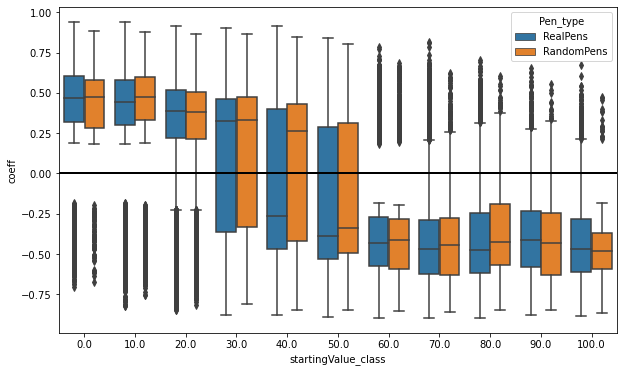

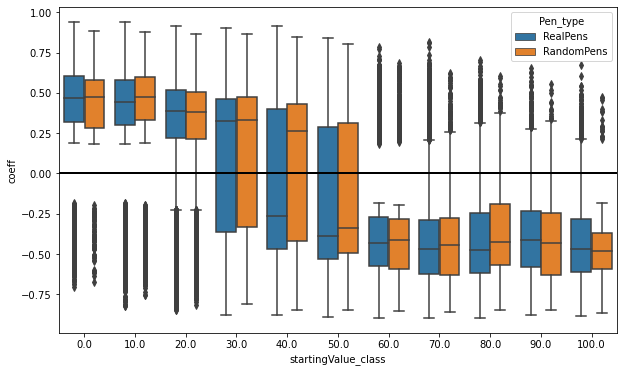

In [331]:
fig = plt.figure(figsize=(10, 6))
sns.boxplot(x='startingValue_class', y='coeff', data=df_corr_tp[(df_corr_tp['nbr_obs']>30)&(df_corr_tp['p_val']<0.01)], 
            hue='Pen_type');
plt.axhline(y=0, xmin=0, xmax=100, linewidth=2, color = 'k');
plt.savefig(os.path.join(path_extracted_data_proximity, 'Proximity_MiddlePoint.png'), dpi=300,
            format='png',bbox_inches='tight')
plt.show()

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


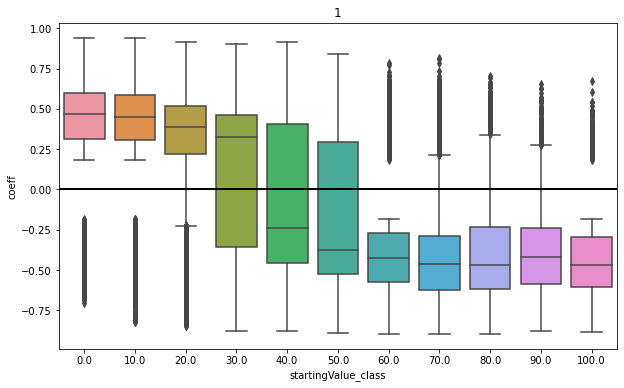

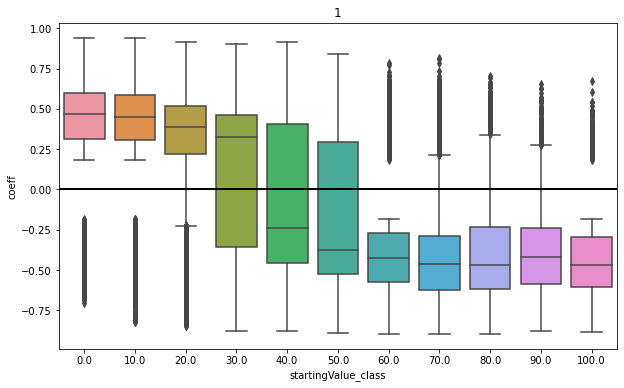

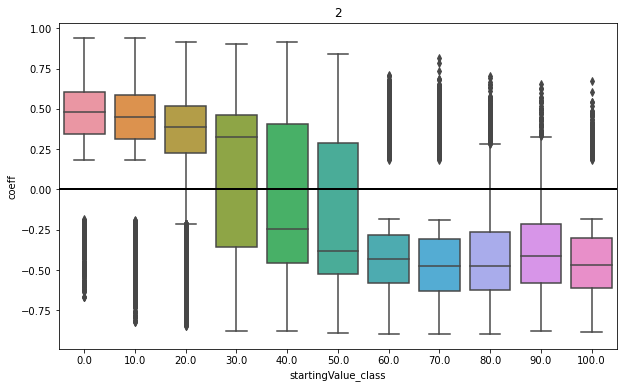

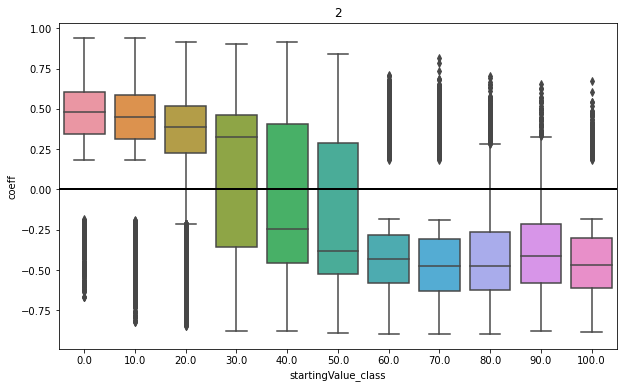

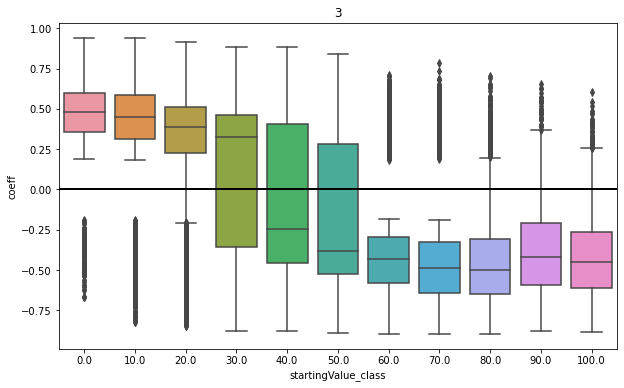

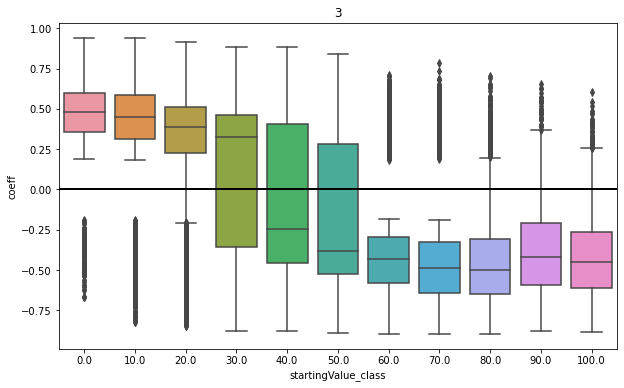

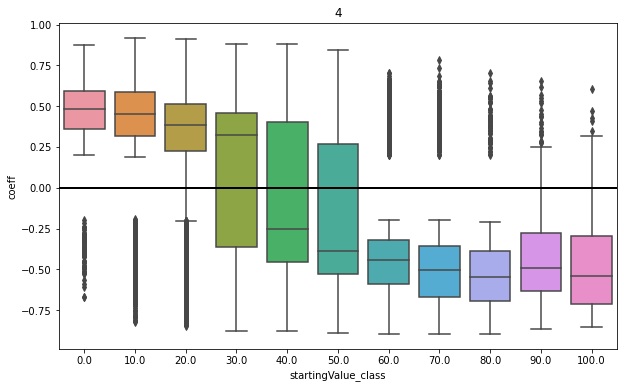

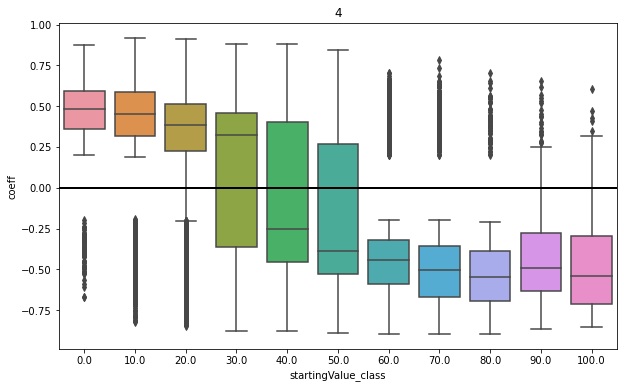

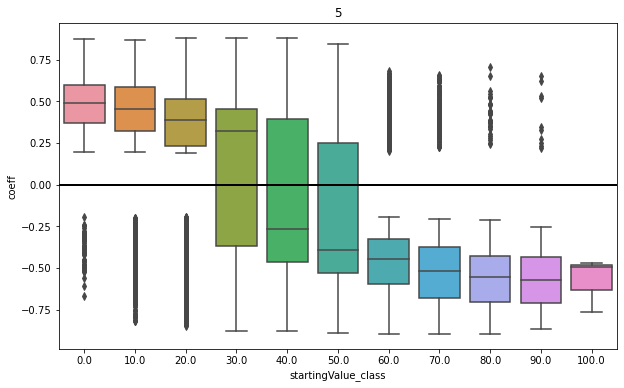

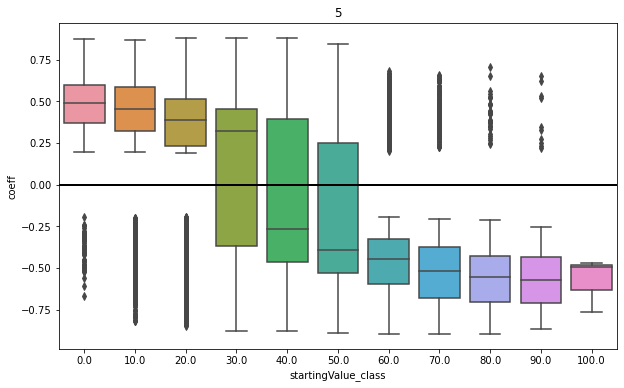

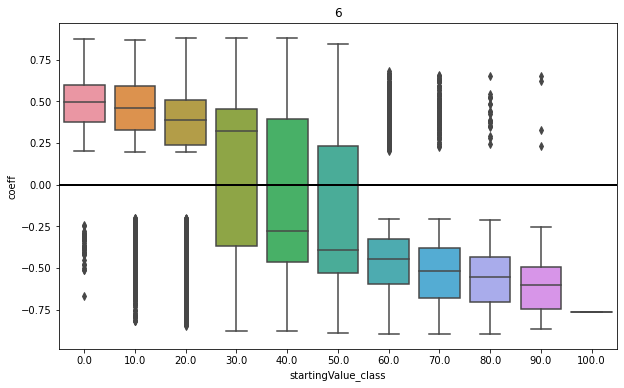

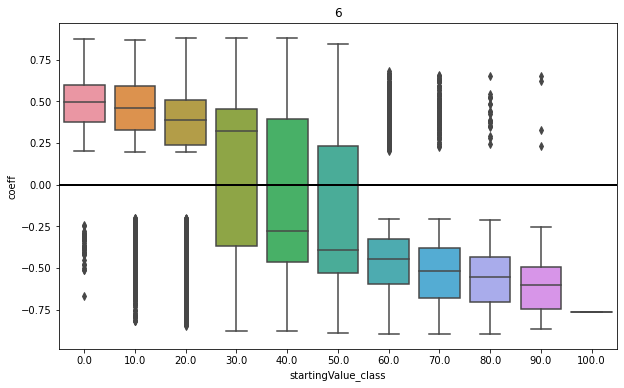

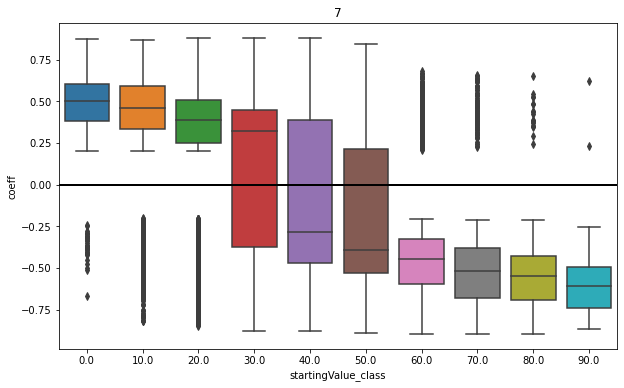

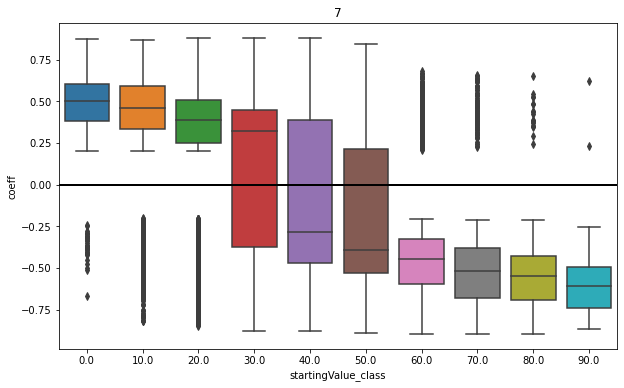

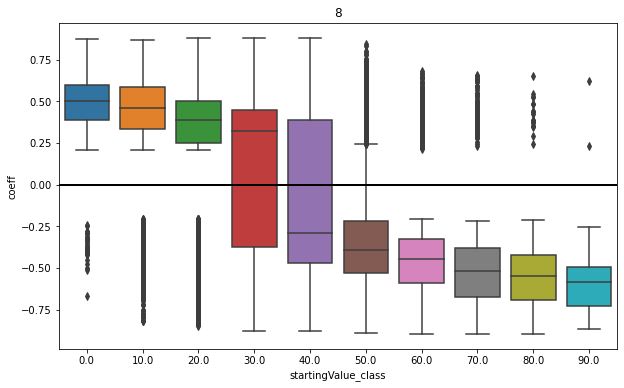

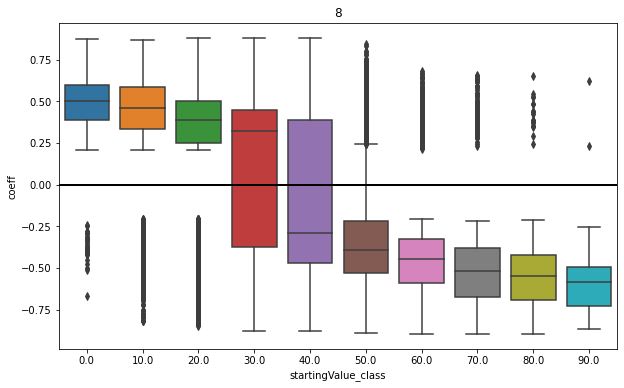

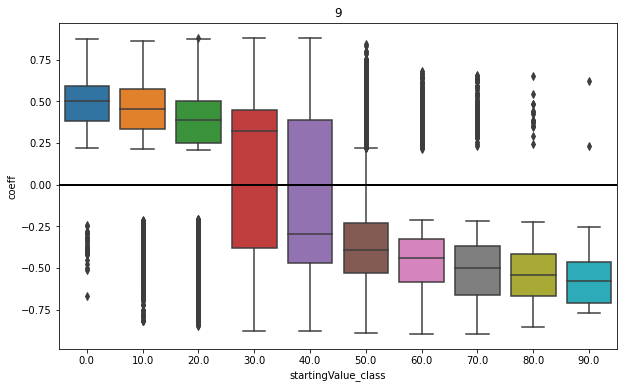

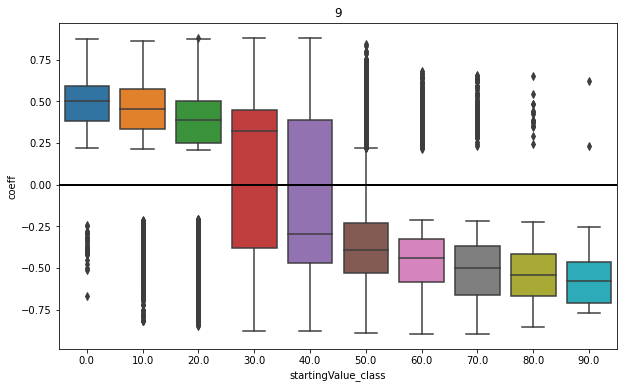

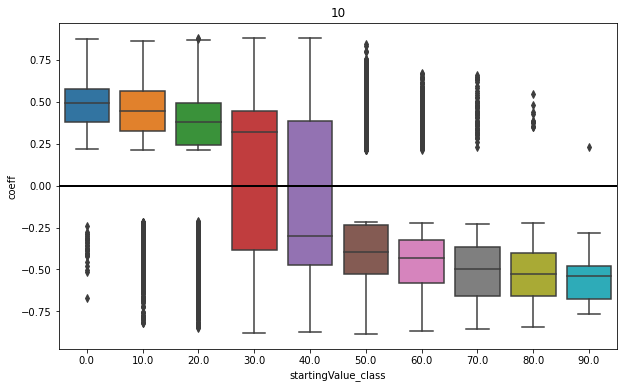

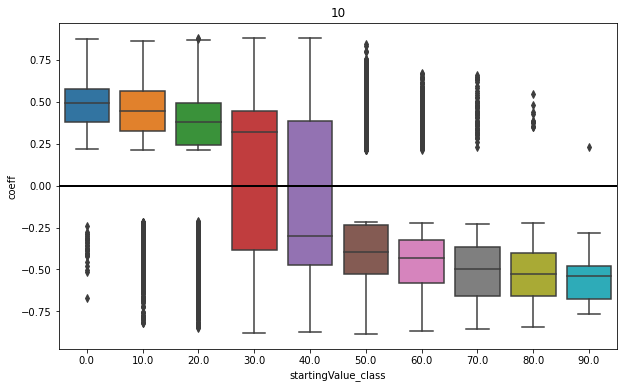

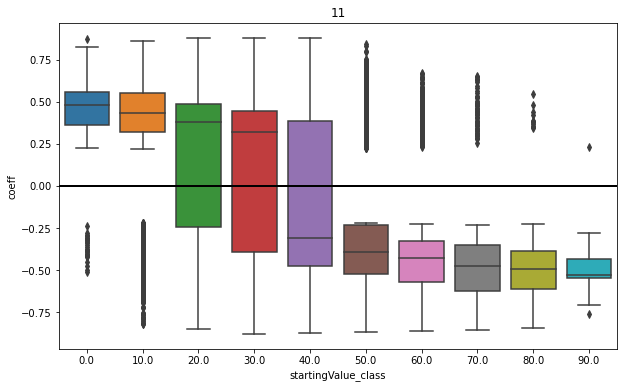

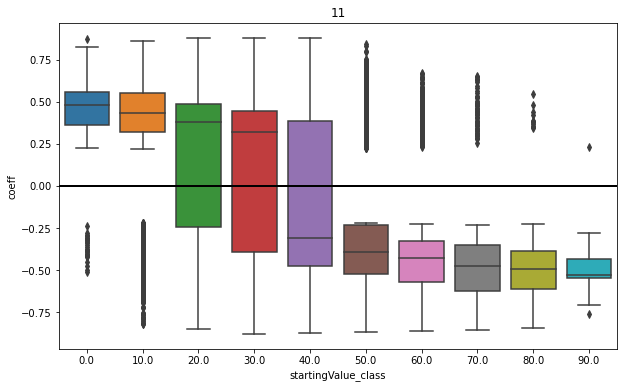

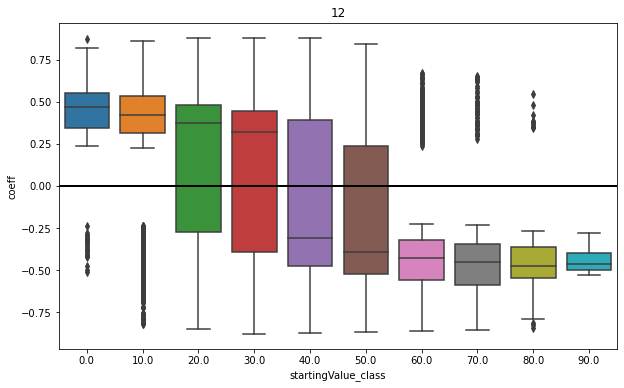

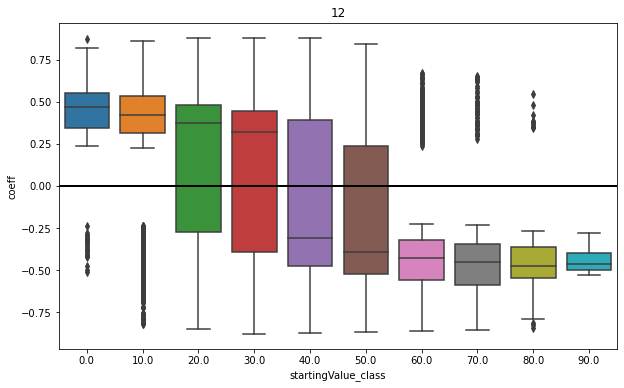

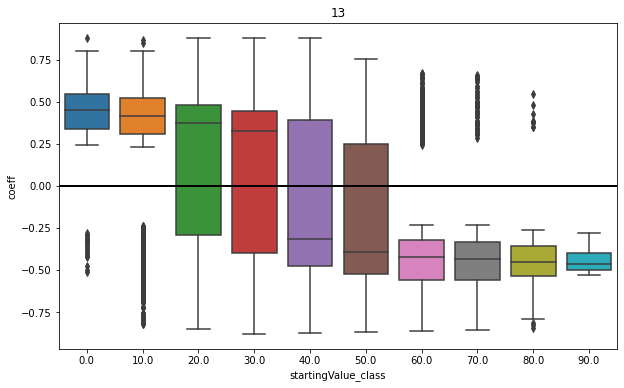

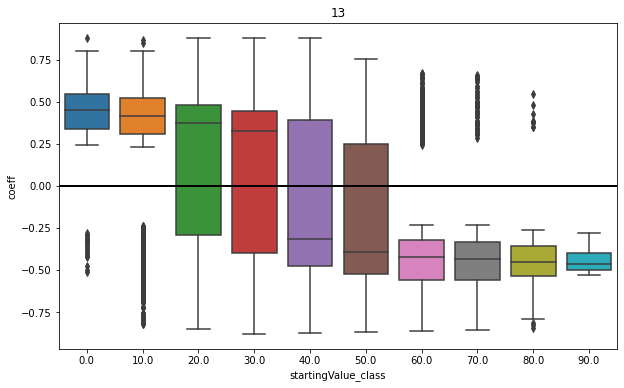

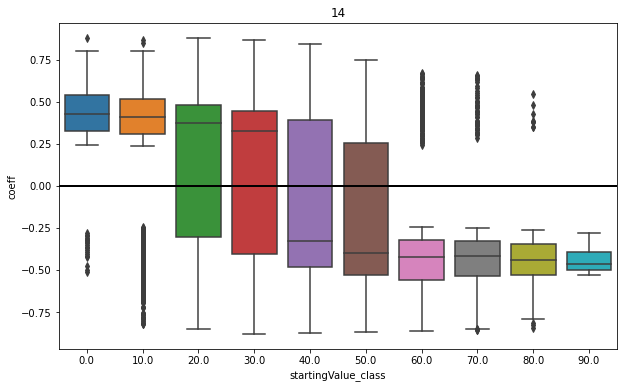

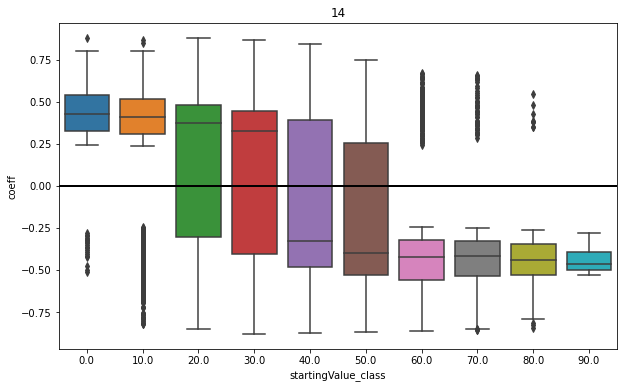

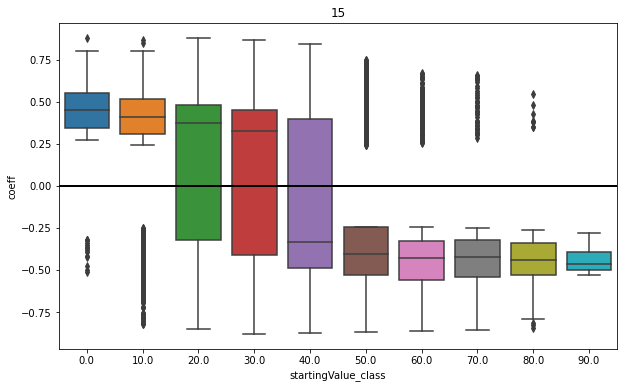

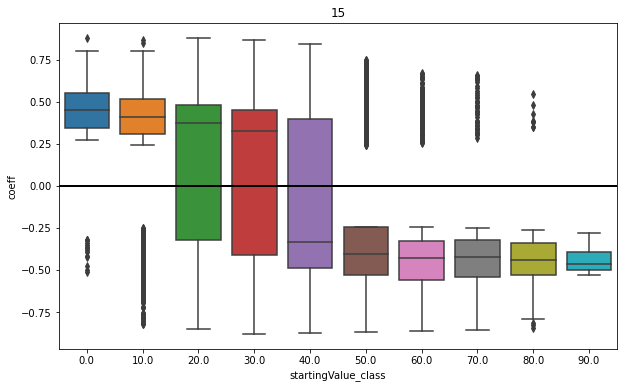

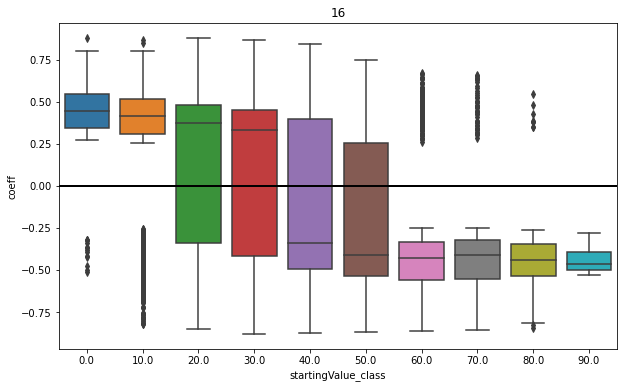

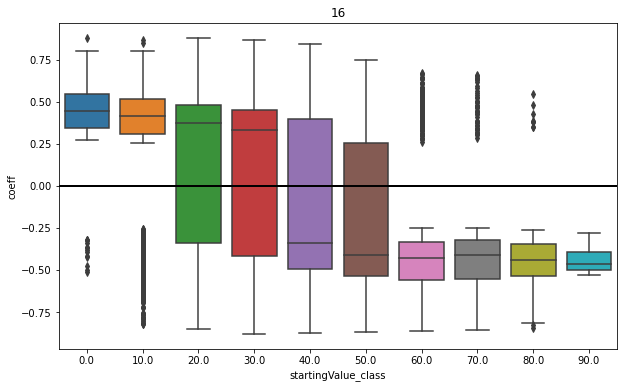

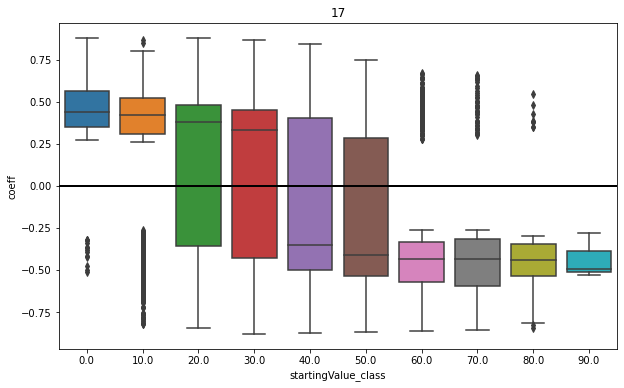

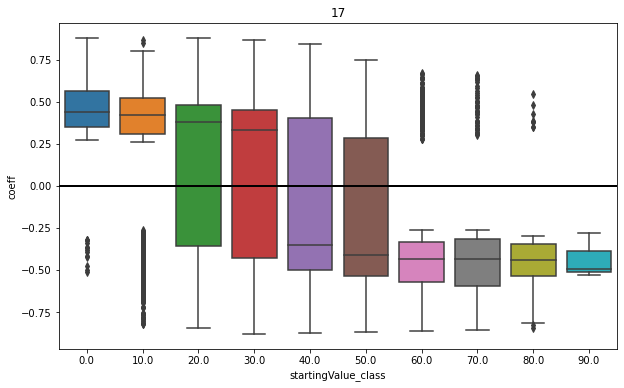

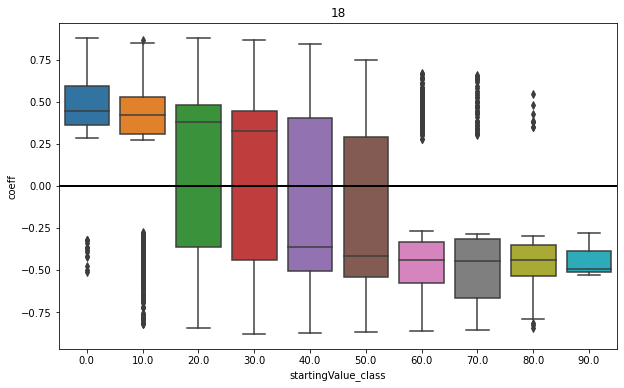

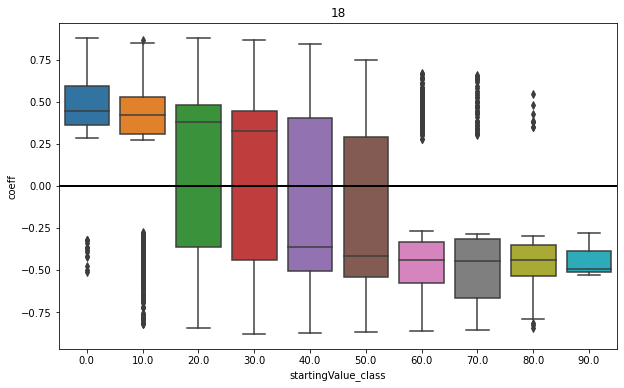

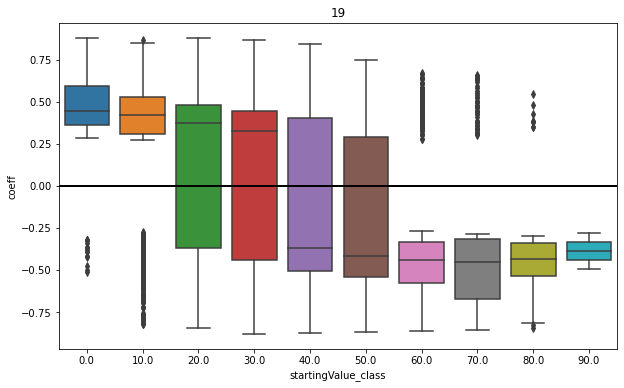

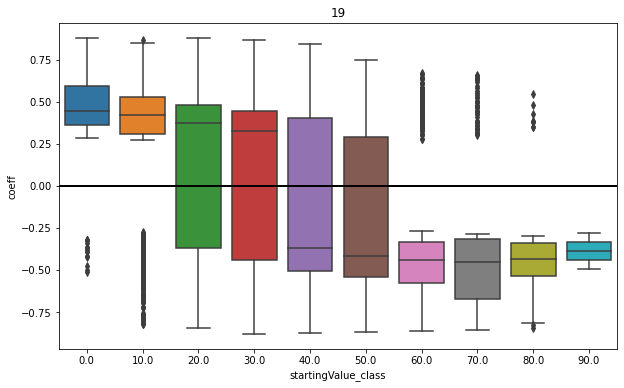

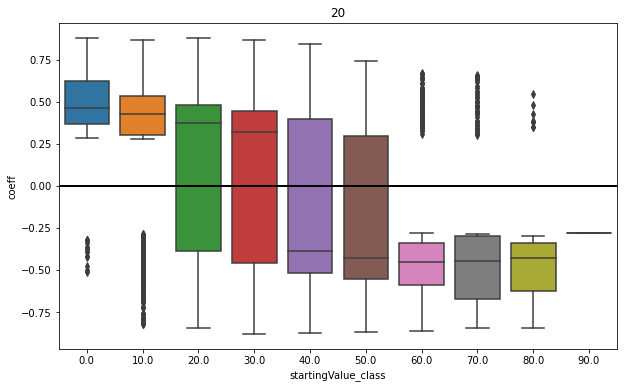

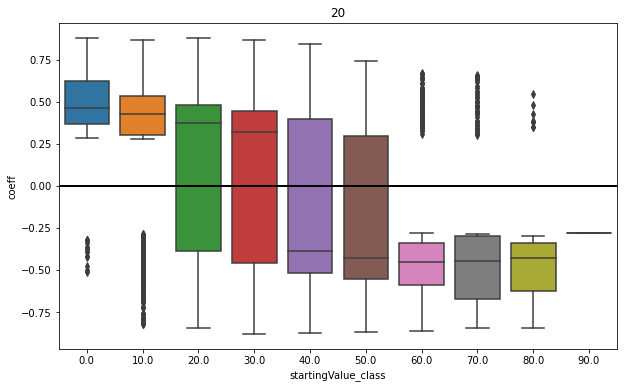

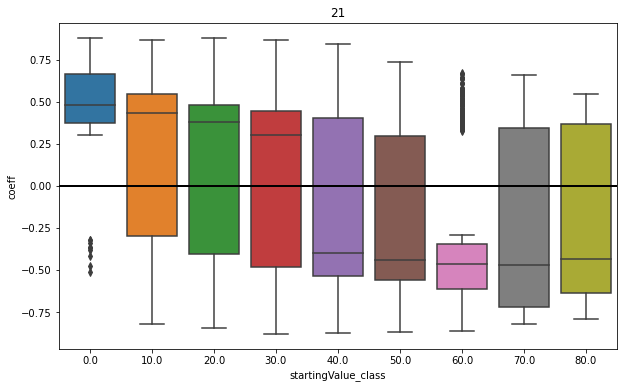

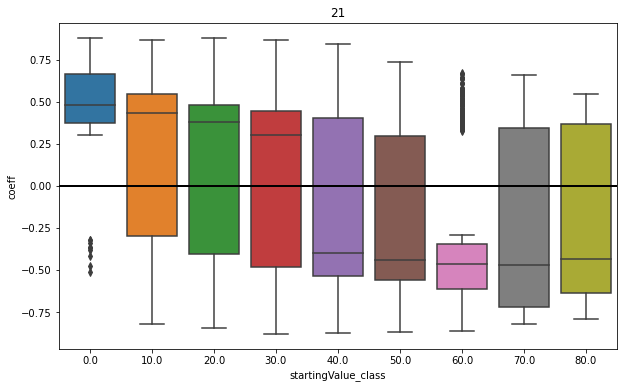

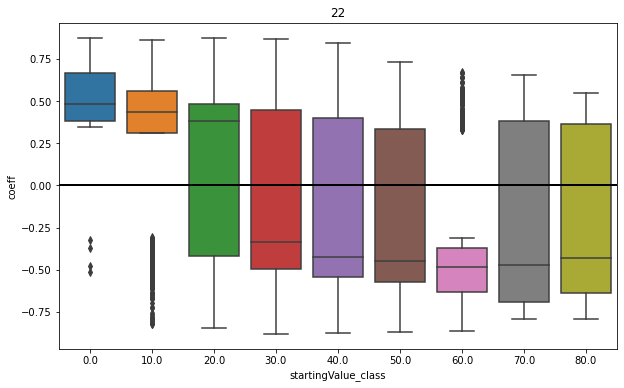

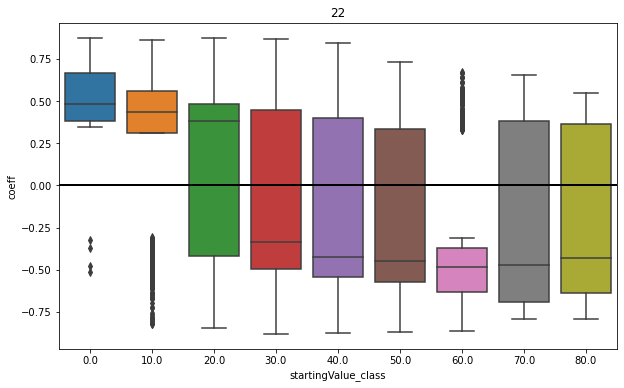

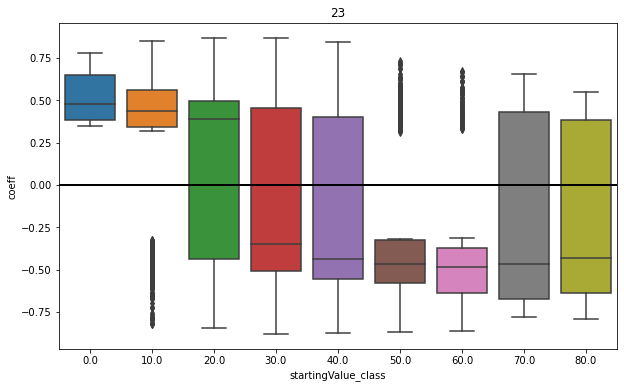

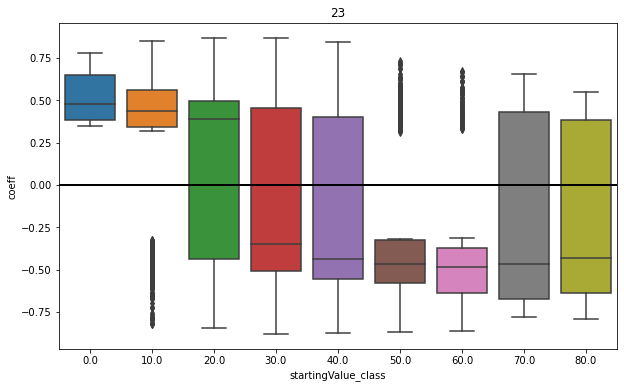

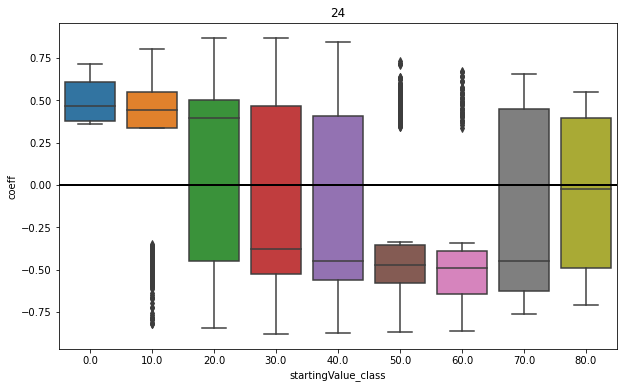

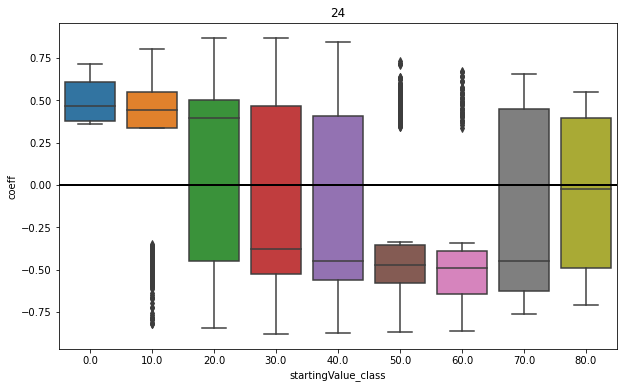

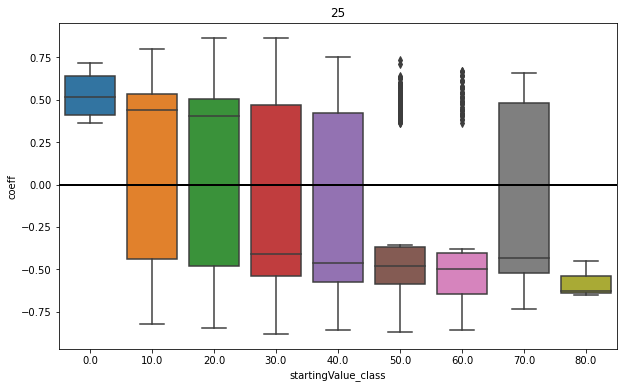

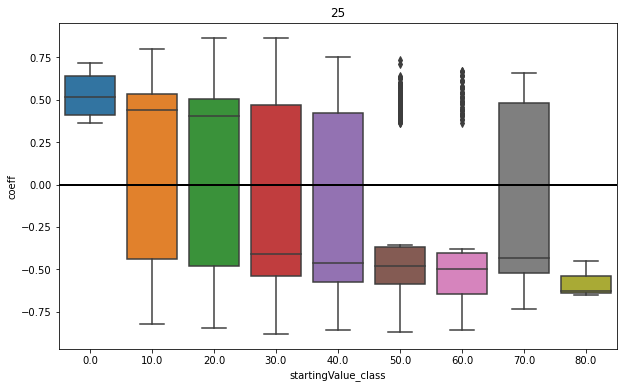

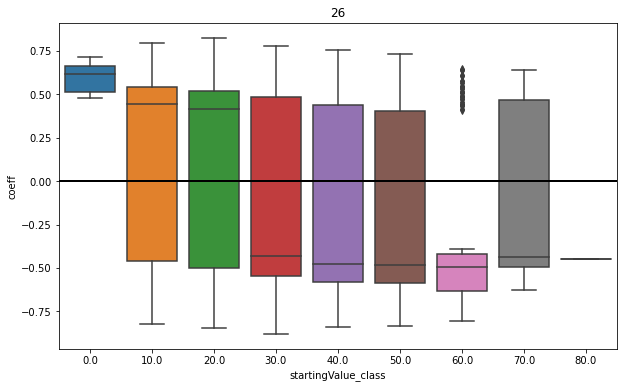

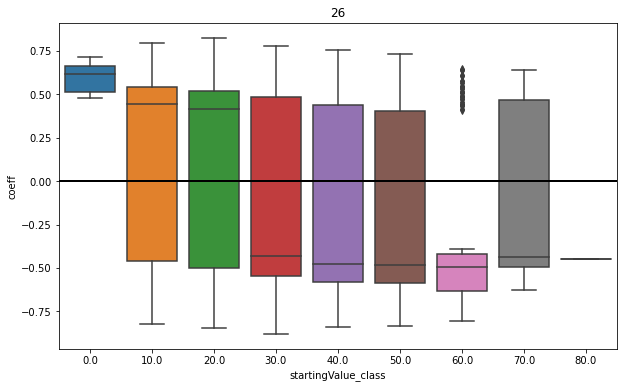

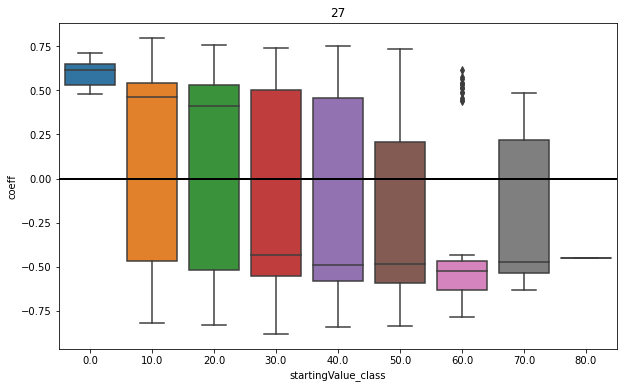

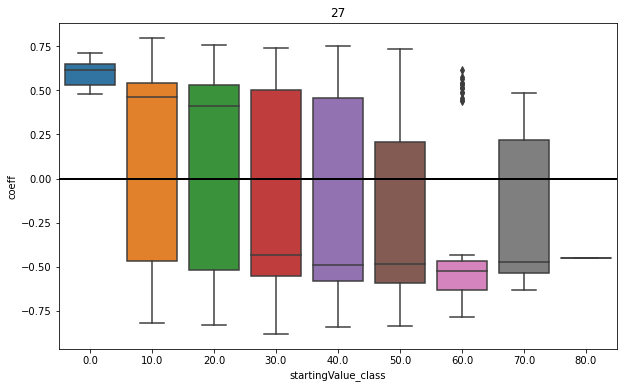

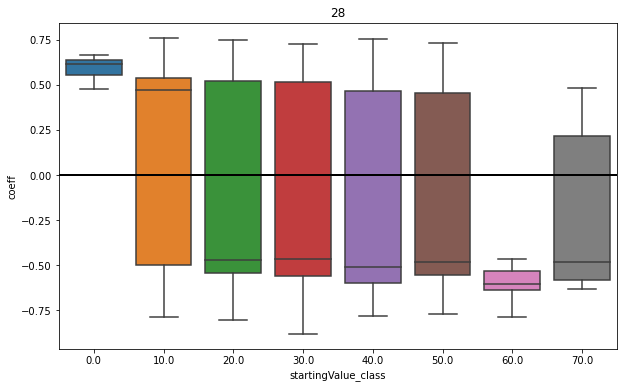

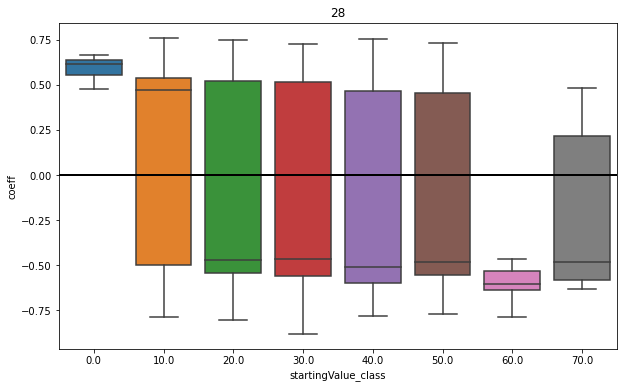

In [337]:
#per WIB TODO
for wib in df_corr_tp['startingdate_WIB'].unique():
    df_ = df_corr_tp[df_corr_tp['startingdate_WIB']>=wib]
    fig = plt.figure(figsize=(10, 6))
    sns.boxplot(x='startingValue_class', y='coeff', data=df_[(df_['nbr_obs']>30)&(df_['p_val']<0.01)]);
    plt.axhline(y=0, xmin=0, xmax=100, linewidth=2, color = 'k');
    plt.title(wib)
    plt.savefig(os.path.join(path_extracted_data_proximity, 'Proximity_MiddlePoint_wib'+str(wib)+'.png'), dpi=300,
                format='png',bbox_inches='tight')
    plt.show()

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


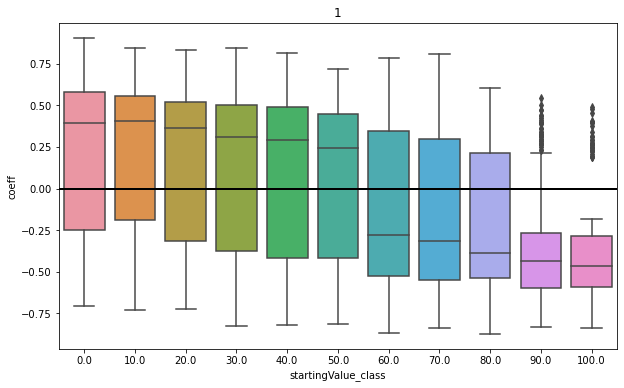

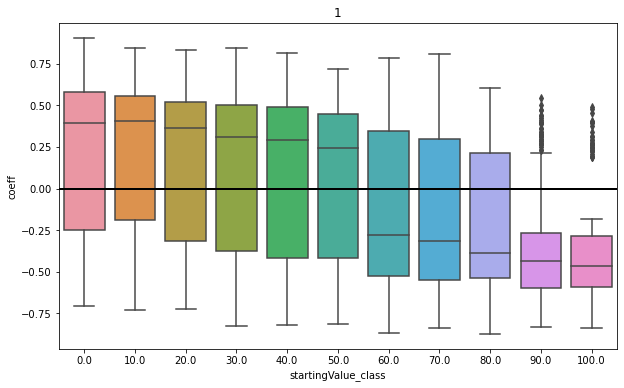

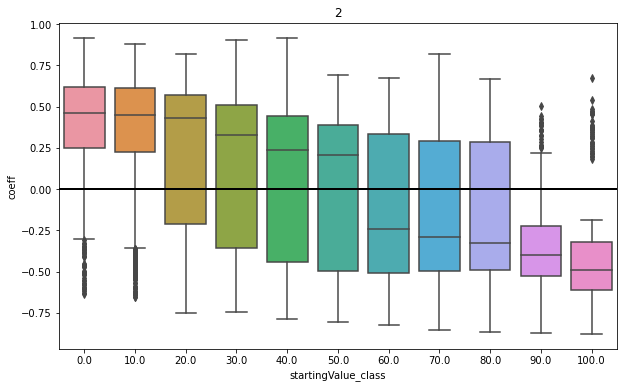

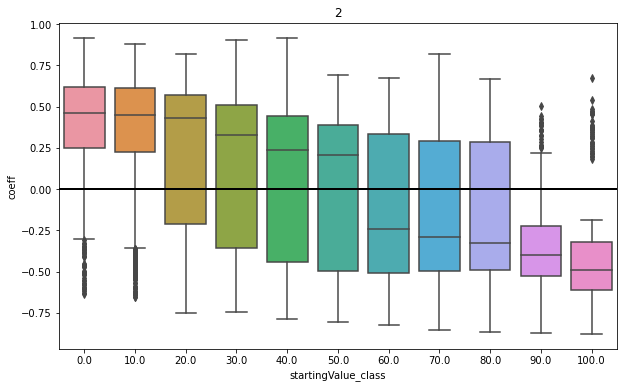

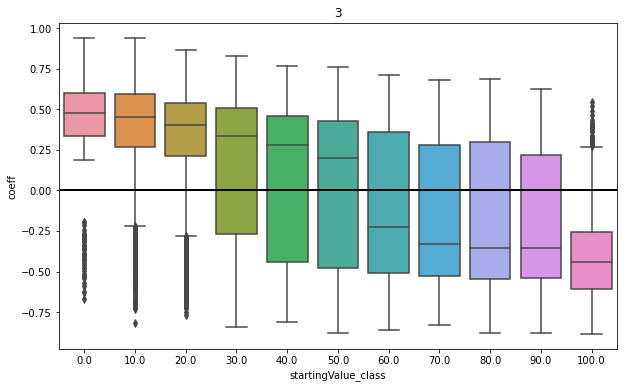

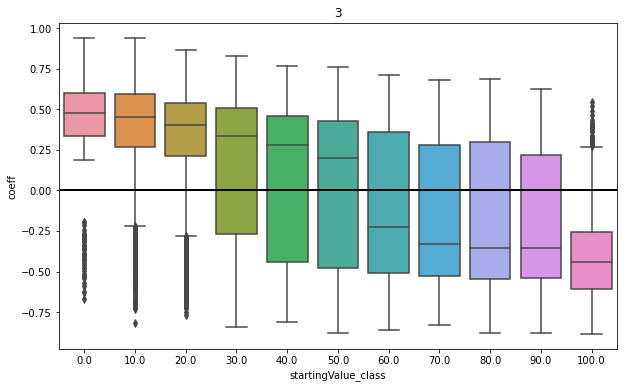

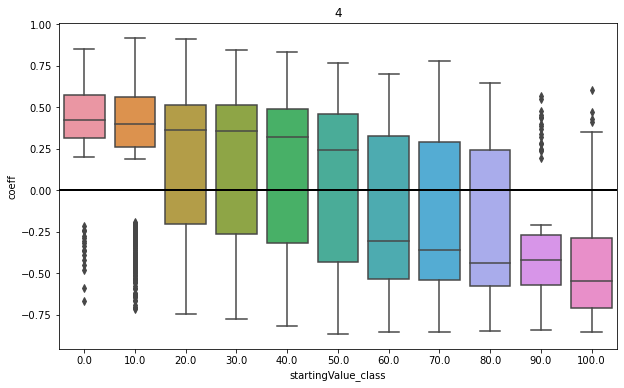

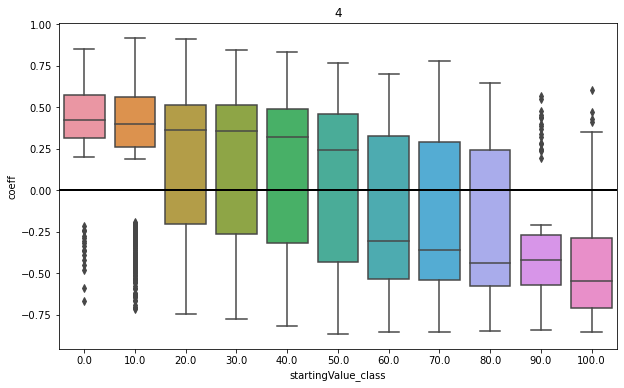

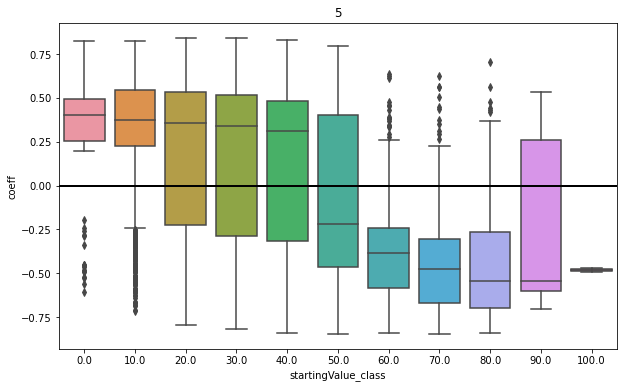

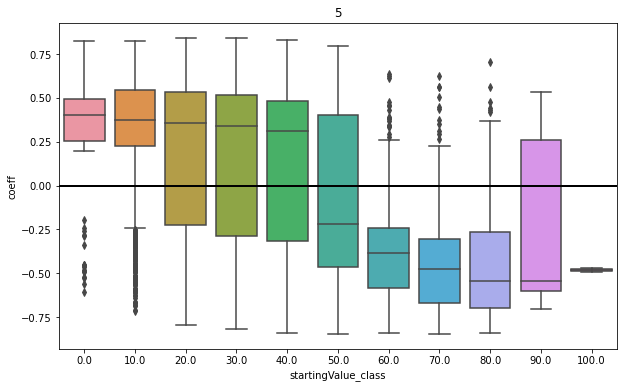

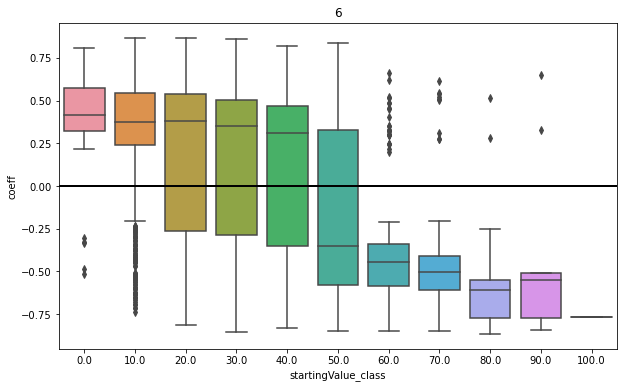

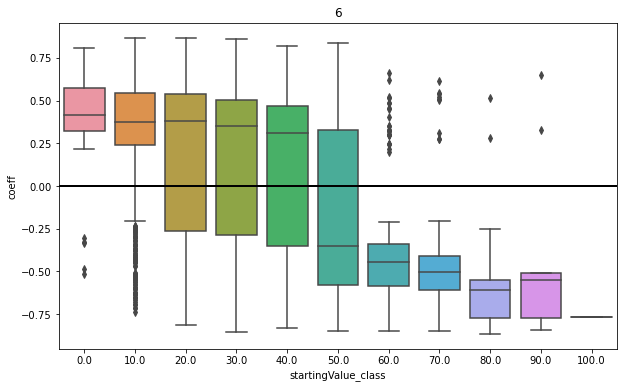

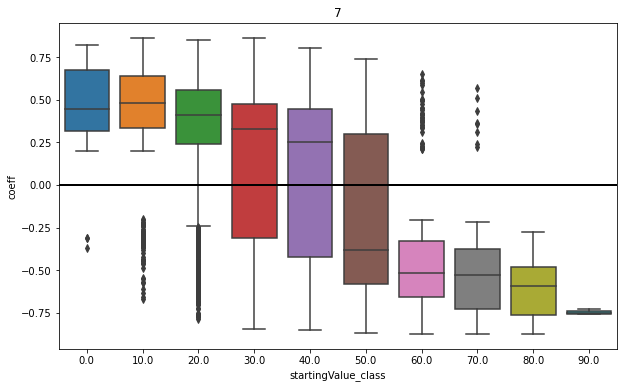

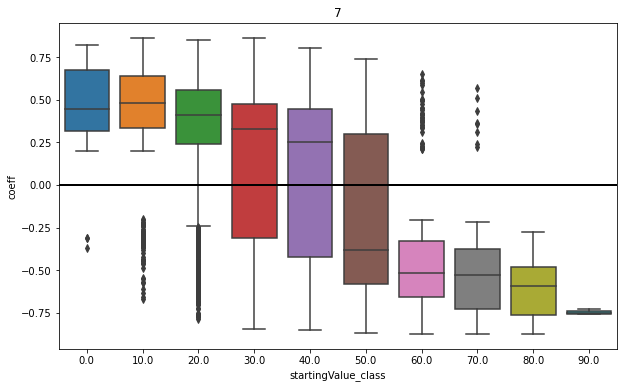

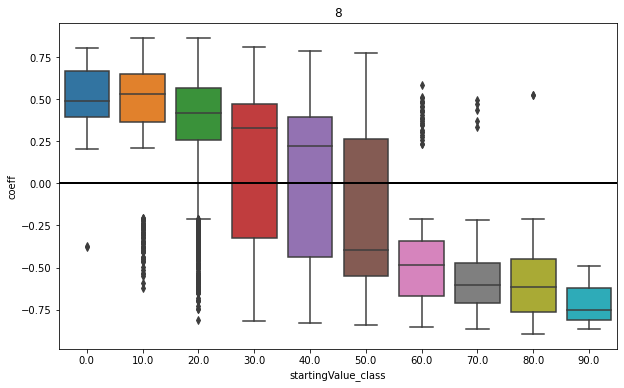

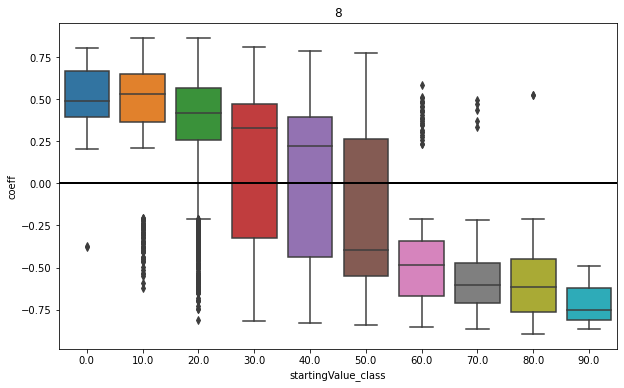

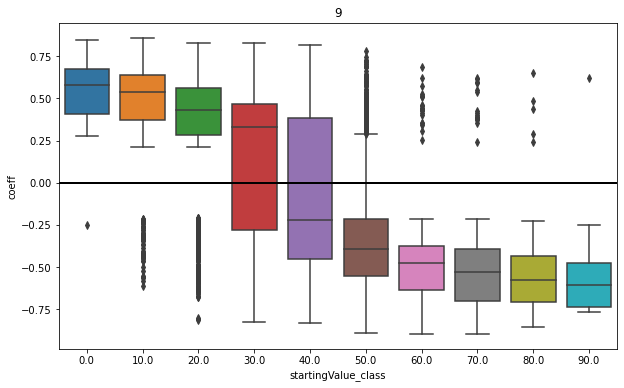

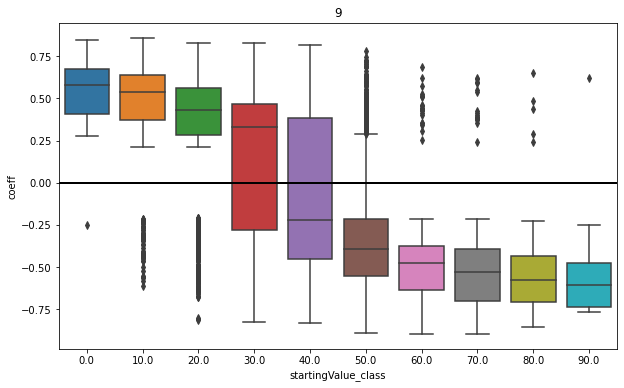

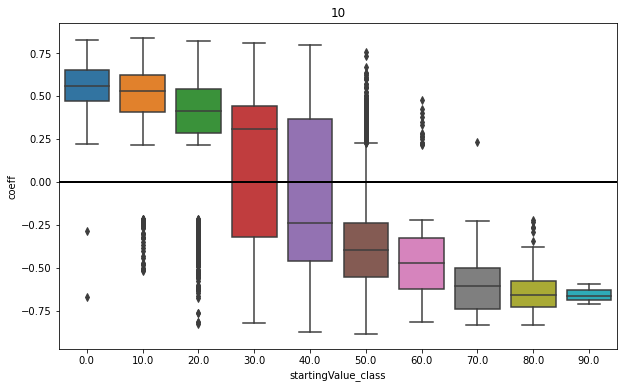

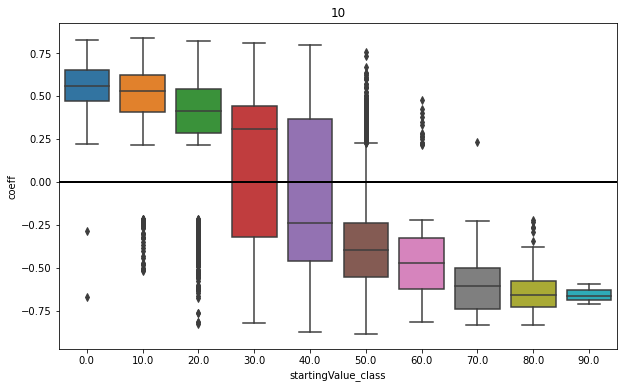

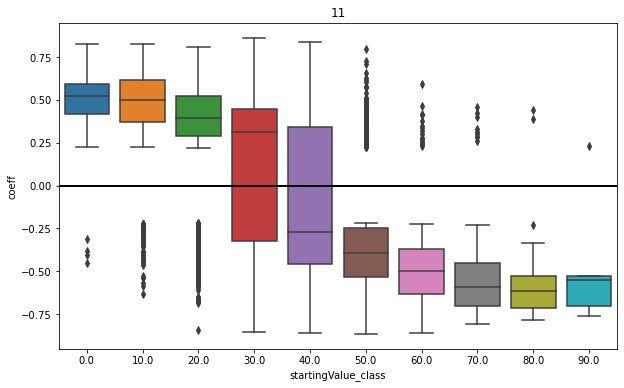

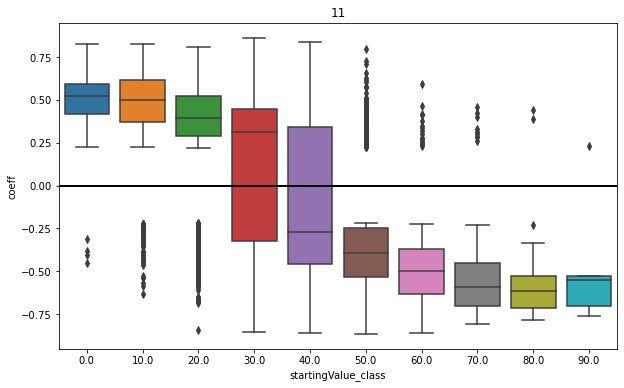

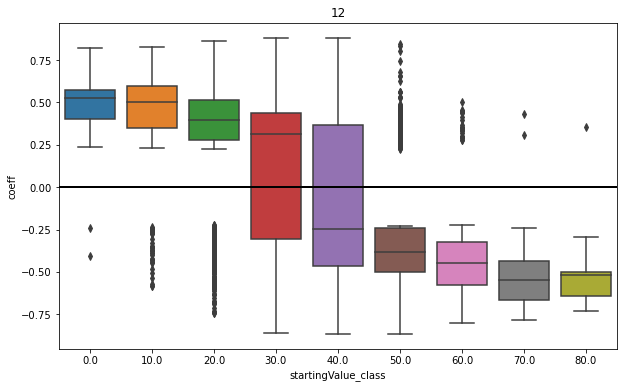

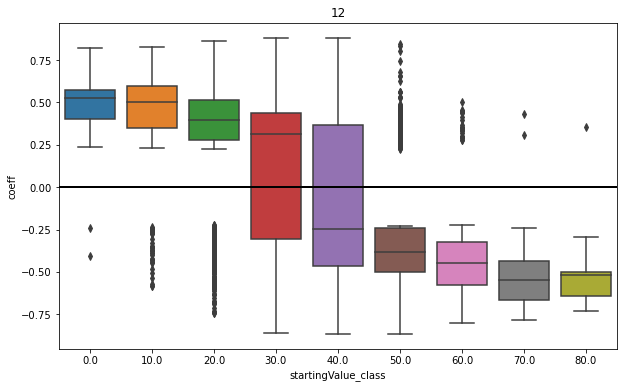

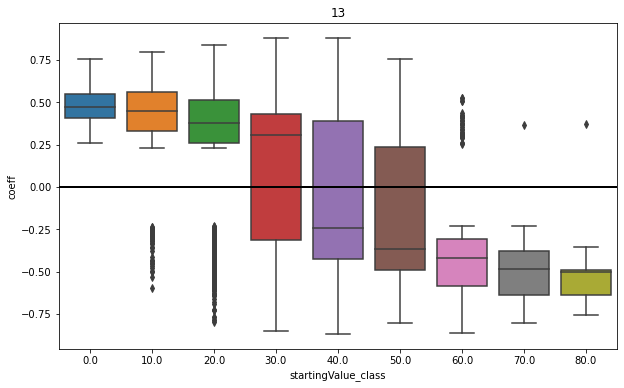

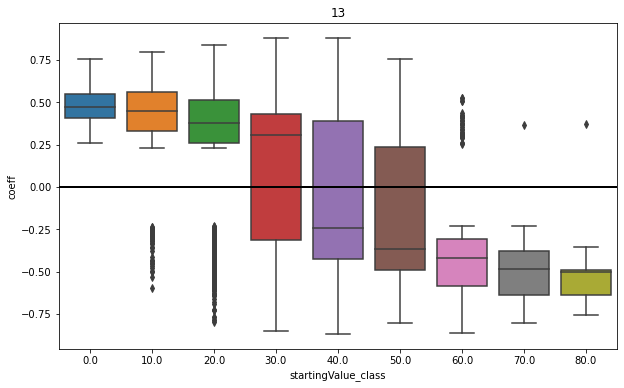

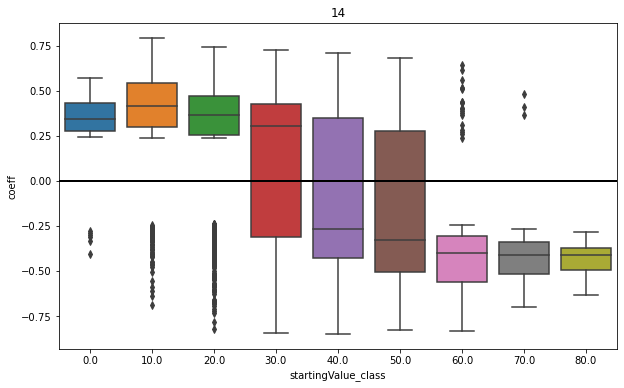

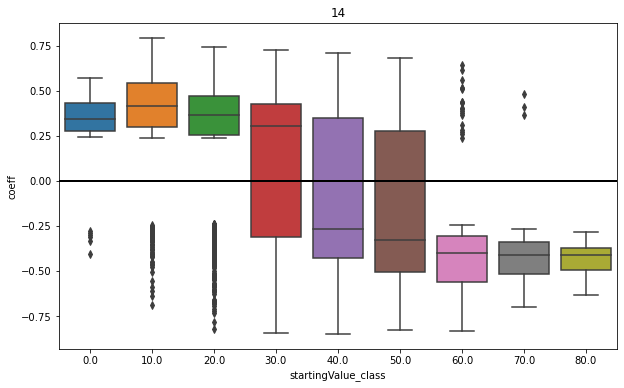

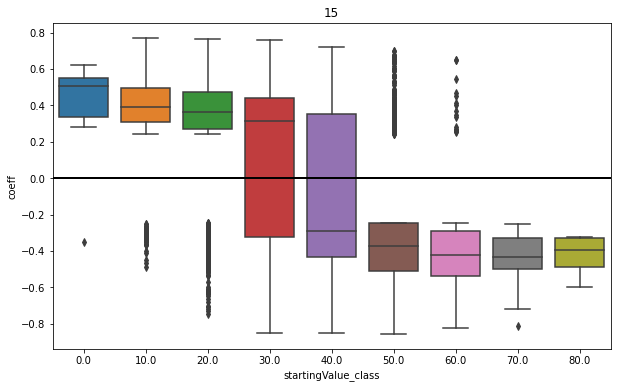

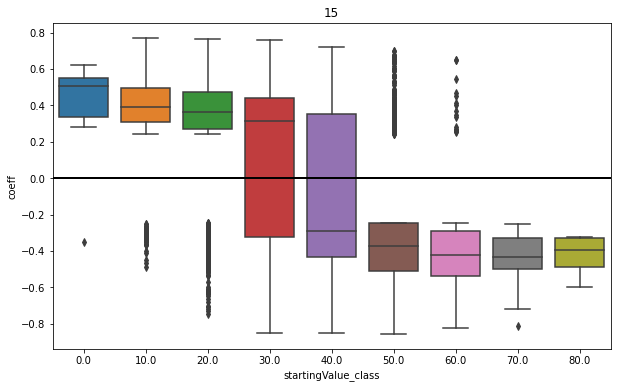

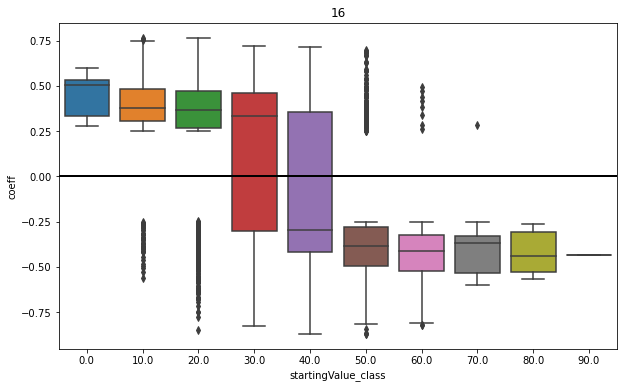

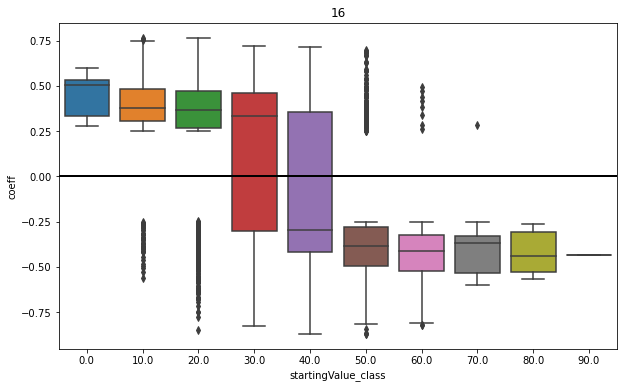

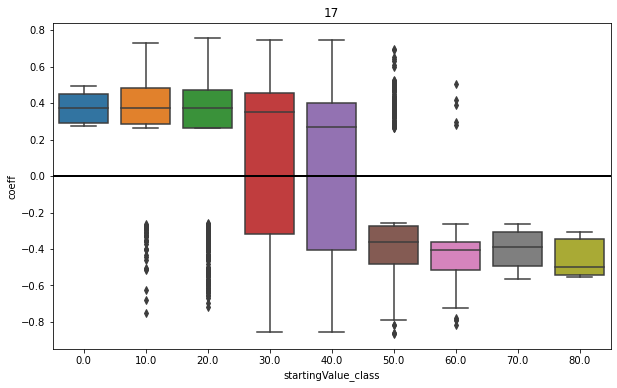

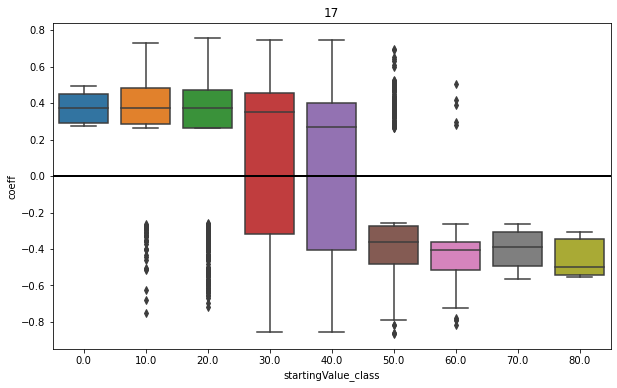

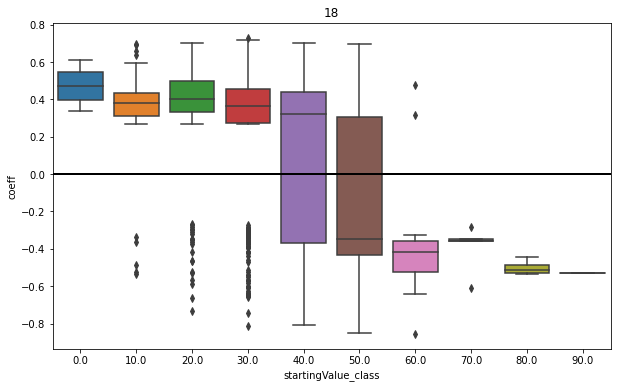

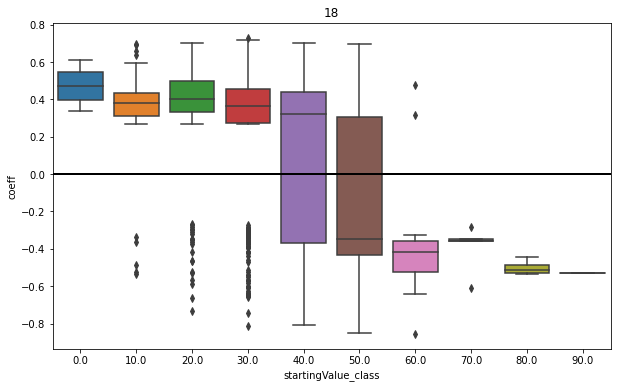

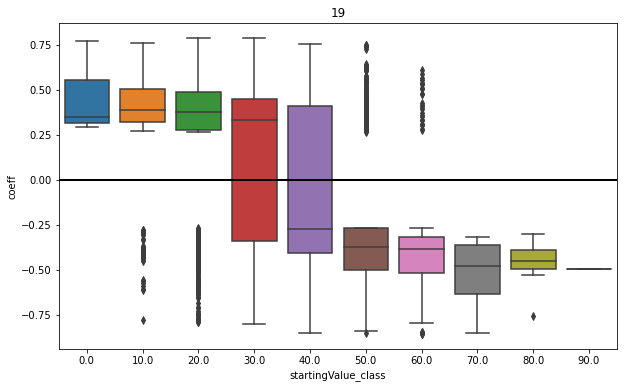

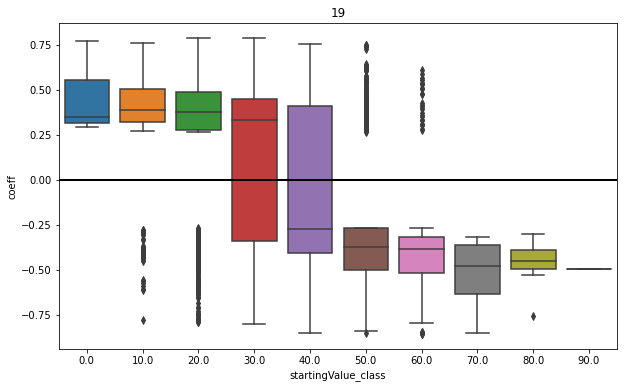

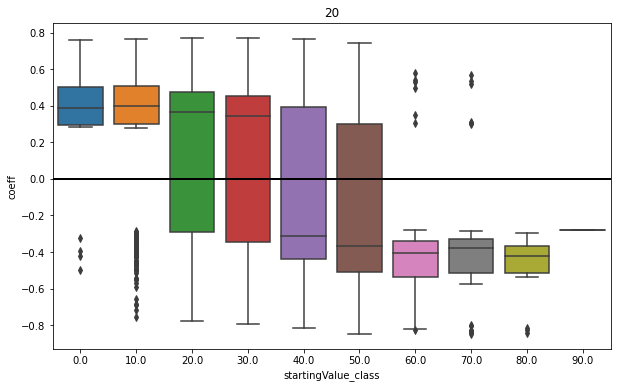

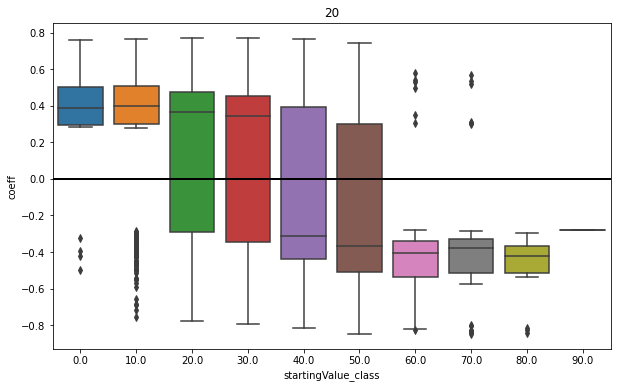

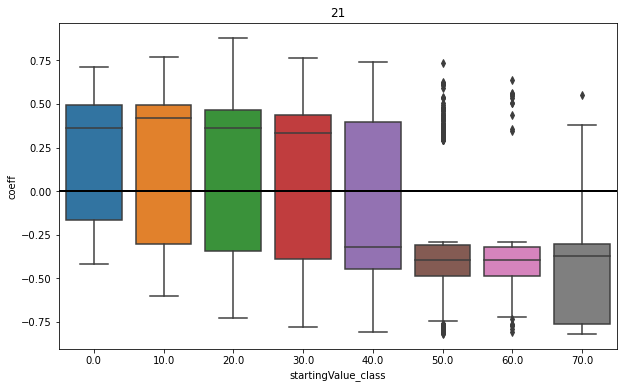

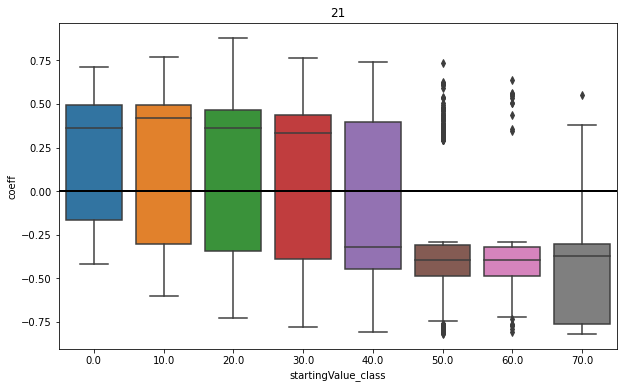

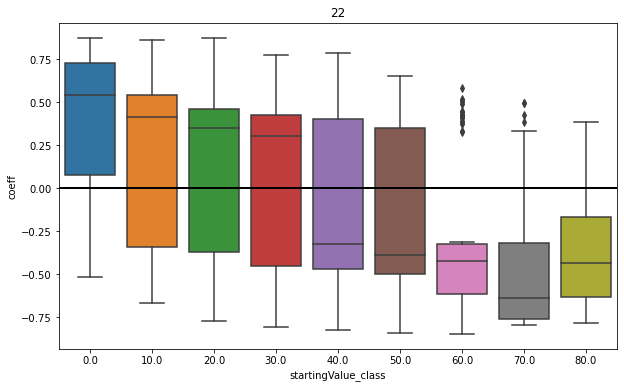

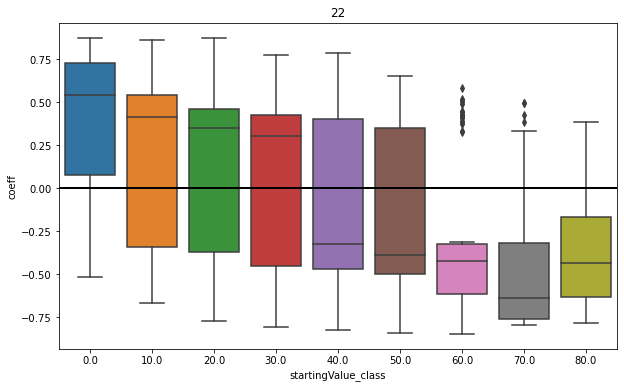

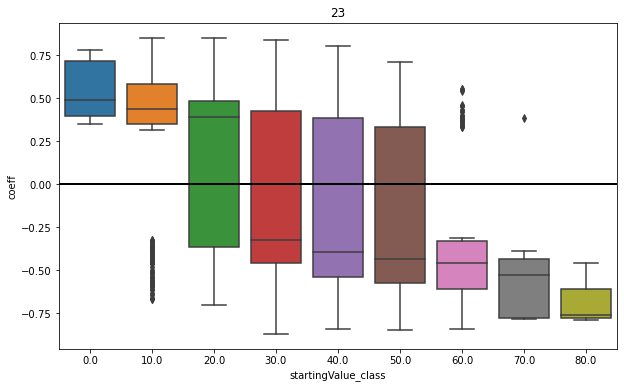

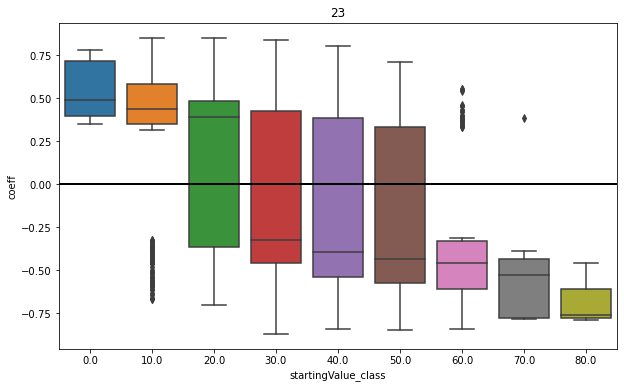

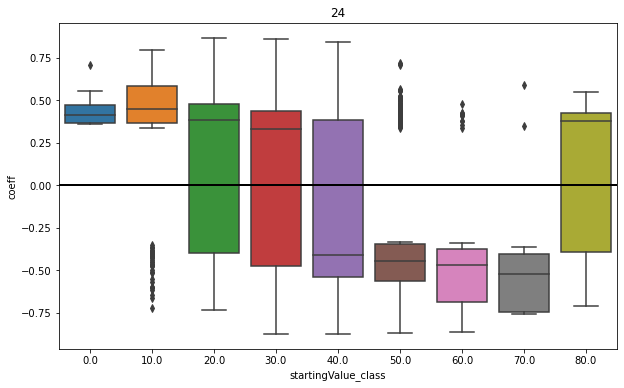

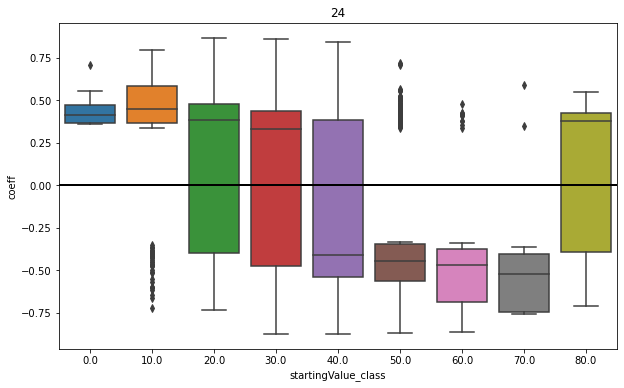

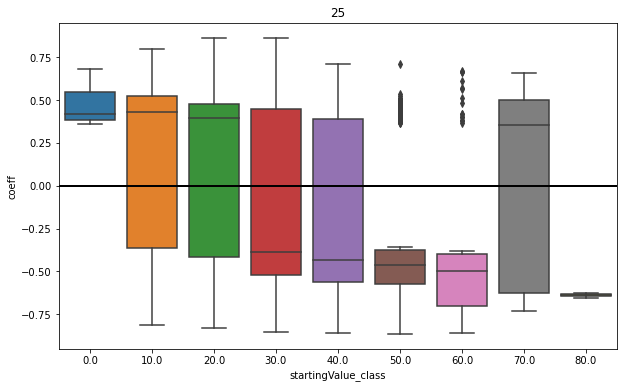

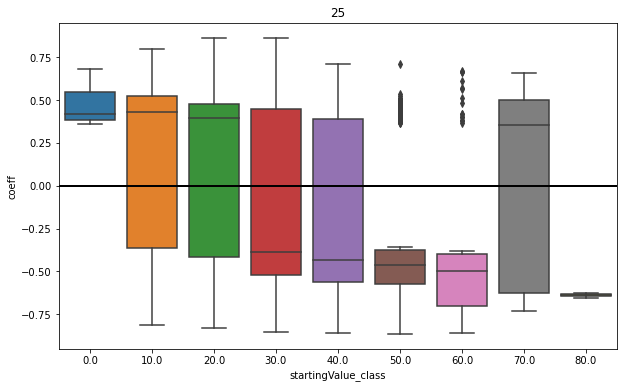

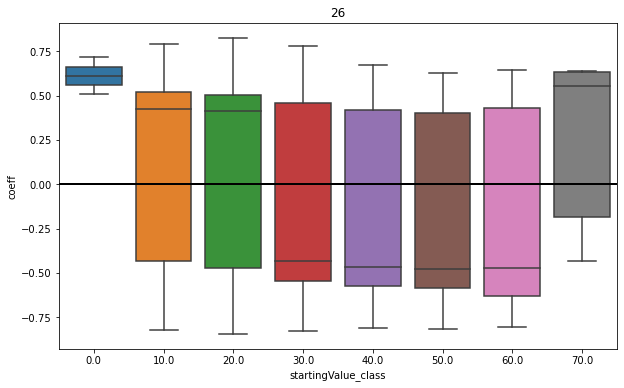

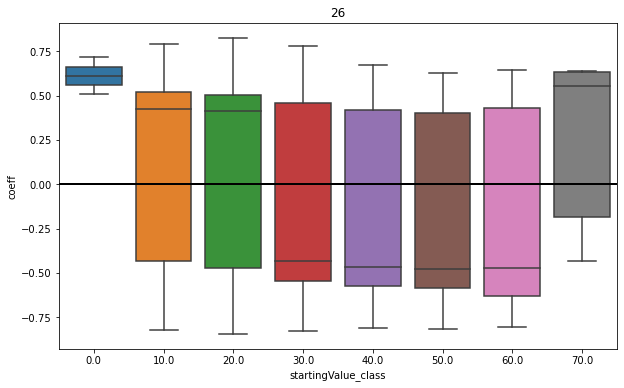

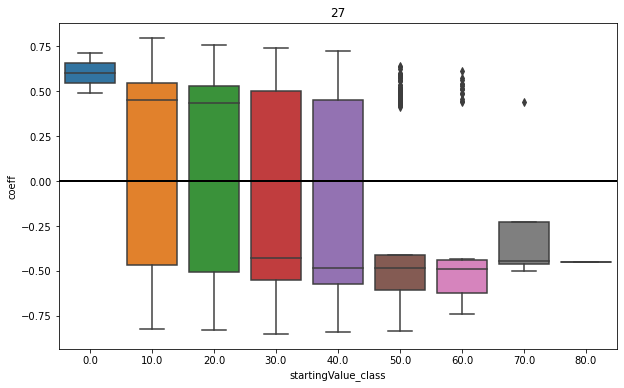

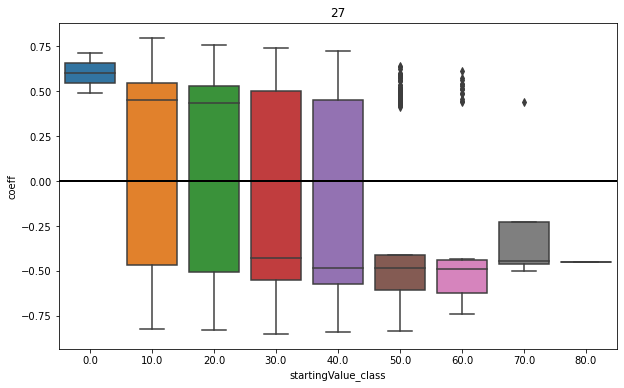

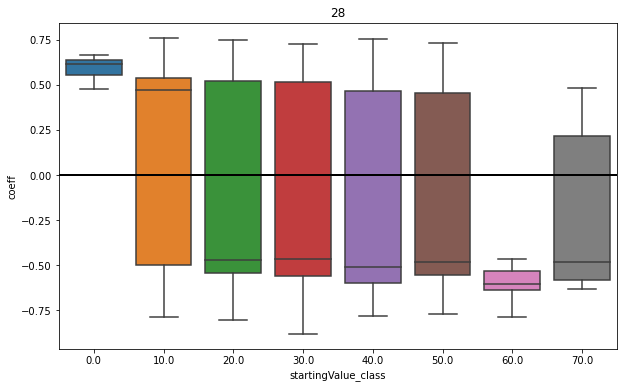

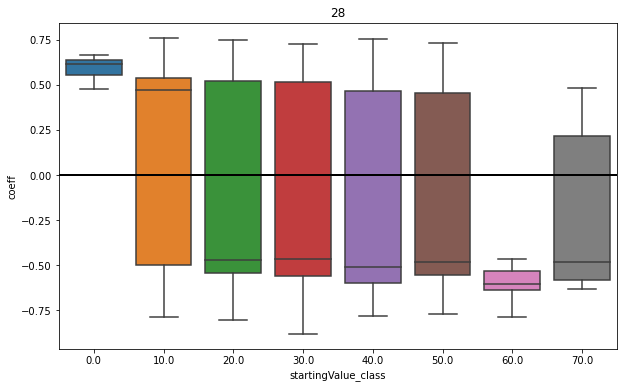

In [336]:
#per WIB
for wib, df_ in df_corr_tp.groupby(['startingdate_WIB']):
    fig = plt.figure(figsize=(10, 6))
    sns.boxplot(x='startingValue_class', y='coeff', data=df_[(df_['nbr_obs']>30)&(df_['p_val']<0.01)]);
    plt.axhline(y=0, xmin=0, xmax=100, linewidth=2, color = 'k');
    plt.title(wib)
    plt.savefig(os.path.join(path_extracted_data_proximity, 'Proximity_MiddlePoint_wib'+str(wib)+'.png'), dpi=300,
                format='png',bbox_inches='tight')
    plt.show()

# Verification

### hens with no percentage of time with commun zone

In [197]:
#select hens for verification
display(df_prox[df_prox['perc_time_with_communZone']==0].tail(5))
#->hen_112, hen_18, 2021-05-05

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,HenID1,HenID2,date,verification,total_nbr_sec_involved,nbr_sec_withCommunZone,PenID1,PenID2,type_,PenID,perc_time_with_communZone,hen_pair,pen_pair,nbr_na,CLASS1,CLASS2,class_pair
375689,hen_112,hen_18,2021-05-05,(),54000,0,pen11,pen9,randompen,pen_R6,0.0,hen_112-hen_18,pen11-pen9,0,other,other,other-other
376048,hen_18,hen_191,2021-05-05,(),54000,0,pen9,pen9,realpen,pen9,0.0,hen_18-hen_191,pen9-pen9,0,other,other,other-other
384963,hen_198,hen_21,2021-05-10,(),54000,0,pen5,pen5,realpen,pen5,0.0,hen_198-hen_21,pen5-pen5,0,other,MEXP,MEXP-other
385311,hen_45,hen_58,2021-05-10,(),54000,0,pen12,pen4,randompen,pen_R7,0.0,hen_45-hen_58,pen12-pen4,0,LEXP,other,LEXP-other
385398,hen_18,hen_191,2021-05-10,(),54000,0,pen9,pen9,realpen,pen9,0.0,hen_18-hen_191,pen9-pen9,0,other,other,other-other


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,HenID1,HenID2,date,verification,total_nbr_sec_involved,nbr_sec_withCommunZone,PenID1,PenID2,type_,PenID,perc_time_with_communZone,hen_pair,pen_pair,nbr_na,CLASS1,CLASS2,class_pair
375689,hen_112,hen_18,2021-05-05,(),54000,0,pen11,pen9,randompen,pen_R6,0.0,hen_112-hen_18,pen11-pen9,0,other,other,other-other
376048,hen_18,hen_191,2021-05-05,(),54000,0,pen9,pen9,realpen,pen9,0.0,hen_18-hen_191,pen9-pen9,0,other,other,other-other
384963,hen_198,hen_21,2021-05-10,(),54000,0,pen5,pen5,realpen,pen5,0.0,hen_198-hen_21,pen5-pen5,0,other,MEXP,MEXP-other
385311,hen_45,hen_58,2021-05-10,(),54000,0,pen12,pen4,randompen,pen_R7,0.0,hen_45-hen_58,pen12-pen4,0,LEXP,other,LEXP-other
385398,hen_18,hen_191,2021-05-10,(),54000,0,pen9,pen9,realpen,pen9,0.0,hen_18-hen_191,pen9-pen9,0,other,other,other-other


In [196]:
#plt.hist(df_prox['perc_time_with_communZone']);

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [203]:
df[(df['HenID']=='hen_112')&(df['date']==dt.datetime(2021,5,5))] #hen_112 never went in zone 5 during the day

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,HenID,PenID,system,Zone,model_prediction,Timestamp,date,next_record_date,previous_record_date,previous_duration,next_zone,previous_zone,previous_previous_zone,correction_is_consecutive_equal_initial_zone,is_WG_open,hour,time
2009092,hen_112,pen11,10 - 12,3_Zone,1,2021-05-05 02:05:40,2021-05-05,2021-05-05 02:06:18.000000,2021-05-05 00:48:25.000000,0 days 01:17:15,3_Zone,4_Zone,4_Zone,False,False,2,02:05:00
2009108,hen_112,pen11,10 - 12,2_Zone,1,2021-05-05 02:06:29,2021-05-05,2021-05-05 03:23:09.000000,2021-05-05 02:06:18.000000,0 days 00:00:11,3_Zone,3_Zone,3_Zone,False,False,2,02:06:00
2009724,hen_112,pen11,10 - 12,3_Zone,1,2021-05-05 03:23:09,2021-05-05,2021-05-05 03:24:14.000000,2021-05-05 02:06:29.000000,0 days 01:16:40,3_Zone,2_Zone,3_Zone,False,False,3,03:23:00
2009780,hen_112,pen11,10 - 12,4_Zone,1,2021-05-05 03:33:08,2021-05-05,2021-05-05 04:29:09.000000,2021-05-05 03:31:53.000000,0 days 00:01:15,3_Zone,3_Zone,3_Zone,False,False,3,03:33:00
2010183,hen_112,pen11,10 - 12,3_Zone,1,2021-05-05 04:29:09,2021-05-05,2021-05-05 04:29:18.000000,2021-05-05 03:33:08.000000,0 days 00:56:01,3_Zone,4_Zone,3_Zone,False,False,4,04:29:00
2010452,hen_112,pen11,10 - 12,2_Zone,1,2021-05-05 05:12:24,2021-05-05,2021-05-05 05:52:23.000000,2021-05-05 05:11:44.000000,0 days 00:00:40,3_Zone,3_Zone,3_Zone,False,False,5,05:12:00
2010713,hen_112,pen11,10 - 12,3_Zone,1,2021-05-05 05:52:23,2021-05-05,2021-05-05 05:53:36.000000,2021-05-05 05:12:24.000000,0 days 00:39:59,3_Zone,2_Zone,3_Zone,False,False,5,05:52:00
2010899,hen_112,pen11,10 - 12,2_Zone,1,2021-05-05 06:15:16,2021-05-05,2021-05-05 07:00:47.000000,2021-05-05 06:14:41.000000,0 days 00:00:35,3_Zone,3_Zone,3_Zone,False,False,6,06:15:00
2011198,hen_112,pen11,10 - 12,3_Zone,1,2021-05-05 07:00:47,2021-05-05,2021-05-05 07:00:51.000000,2021-05-05 06:15:16.000000,0 days 00:45:31,3_Zone,2_Zone,3_Zone,False,False,7,07:00:00
2011431,hen_112,pen11,10 - 12,2_Zone,1,2021-05-05 07:41:12,2021-05-05,2021-05-05 07:57:14.000000,2021-05-05 07:40:44.000000,0 days 00:00:28,3_Zone,3_Zone,3_Zone,False,False,7,07:41:00


,HenID,PenID,system,Zone,model_prediction,Timestamp,date,next_record_date,previous_record_date,previous_duration,next_zone,previous_zone,previous_previous_zone,correction_is_consecutive_equal_initial_zone,is_WG_open,hour,time
2009092,hen_112,pen11,10 - 12,3_Zone,1,2021-05-05 02:05:40,2021-05-05,2021-05-05 02:06:18.000000,2021-05-05 00:48:25.000000,0 days 01:17:15,3_Zone,4_Zone,4_Zone,False,False,2,02:05:00
2009108,hen_112,pen11,10 - 12,2_Zone,1,2021-05-05 02:06:29,2021-05-05,2021-05-05 03:23:09.000000,2021-05-05 02:06:18.000000,0 days 00:00:11,3_Zone,3_Zone,3_Zone,False,False,2,02:06:00
2009724,hen_112,pen11,10 - 12,3_Zone,1,2021-05-05 03:23:09,2021-05-05,2021-05-05 03:24:14.000000,2021-05-05 02:06:29.000000,0 days 01:16:40,3_Zone,2_Zone,3_Zone,False,False,3,03:23:00
2009780,hen_112,pen11,10 - 12,4_Zone,1,2021-05-05 03:33:08,2021-05-05,2021-05-05 04:29:09.000000,2021-05-05 03:31:53.000000,0 days 00:01:15,3_Zone,3_Zone,3_Zone,False,False,3,03:33:00
2010183,hen_112,pen11,10 - 12,3_Zone,1,2021-05-05 04:29:09,2021-05-05,2021-05-05 04:29:18.000000,2021-05-05 03:33:08.000000,0 days 00:56:01,3_Zone,4_Zone,3_Zone,False,False,4,04:29:00
2010452,hen_112,pen11,10 - 12,2_Zone,1,2021-05-05 05:12:24,2021-05-05,2021-05-05 05:52:23.000000,2021-05-05 05:11:44.000000,0 days 00:00:40,3_Zone,3_Zone,3_Zone,False,False,5,05:12:00
2010713,hen_112,pen11,10 - 12,3_Zone,1,2021-05-05 05:52:23,2021-05-05,2021-05-05 05:53:36.000000,2021-05-05 05:12:24.000000,0 days 00:39:59,3_Zone,2_Zone,3_Zone,False,False,5,05:52:00
2010899,hen_112,pen11,10 - 12,2_Zone,1,2021-05-05 06:15:16,2021-05-05,2021-05-05 07:00:47.000000,2021-05-05 06:14:41.000000,0 days 00:00:35,3_Zone,3_Zone,3_Zone,False,False,6,06:15:00
2011198,hen_112,pen11,10 - 12,3_Zone,1,2021-05-05 07:00:47,2021-05-05,2021-05-05 07:00:51.000000,2021-05-05 06:15:16.000000,0 days 00:45:31,3_Zone,2_Zone,3_Zone,False,False,7,07:00:00
2011431,hen_112,pen11,10 - 12,2_Zone,1,2021-05-05 07:41:12,2021-05-05,2021-05-05 07:57:14.000000,2021-05-05 07:40:44.000000,0 days 00:00:28,3_Zone,3_Zone,3_Zone,False,False,7,07:41:00


In [202]:
df[(df['HenID']=='hen_18')&(df['date']==dt.datetime(2021,5,5))] #hen_18 staid all day in zone 5 --> CORRECT

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,HenID,PenID,system,Zone,model_prediction,Timestamp,date,next_record_date,previous_record_date,previous_duration,next_zone,previous_zone,previous_previous_zone,correction_is_consecutive_equal_initial_zone,is_WG_open,hour,time
2011125,hen_18,pen9,8 - 9,4_Zone,1,2021-05-05 06:52:09,2021-05-05,2021-05-05 07:31:45.000000,2021-05-04 14:16:37.000000,0 days 16:35:32,5_Zone,5_Zone,4_Zone,False,False,6,06:52:00
2011375,hen_18,pen9,8 - 9,5_Zone,1,2021-05-05 07:31:45,2021-05-05,2021-05-06 07:07:42.000000,2021-05-05 06:52:09.000000,0 days 00:39:36,5_Zone,4_Zone,5_Zone,False,False,7,07:31:00


,HenID,PenID,system,Zone,model_prediction,Timestamp,date,next_record_date,previous_record_date,previous_duration,next_zone,previous_zone,previous_previous_zone,correction_is_consecutive_equal_initial_zone,is_WG_open,hour,time
2011125,hen_18,pen9,8 - 9,4_Zone,1,2021-05-05 06:52:09,2021-05-05,2021-05-05 07:31:45.000000,2021-05-04 14:16:37.000000,0 days 16:35:32,5_Zone,5_Zone,4_Zone,False,False,6,06:52:00
2011375,hen_18,pen9,8 - 9,5_Zone,1,2021-05-05 07:31:45,2021-05-05,2021-05-06 07:07:42.000000,2021-05-05 06:52:09.000000,0 days 00:39:36,5_Zone,4_Zone,5_Zone,False,False,7,07:31:00


### hens with some percentage of time with commun zone

In [205]:
#select hens for verification
display(df_prox[df_prox['perc_time_with_communZone']!=0].head(5))
#-> hen_131, hen_134, 2020-09-30: 19 sec in commun
#-> hen_131 hen_138, 2020-09-30: 20895 sec in commun (72%)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,HenID1,HenID2,date,verification,total_nbr_sec_involved,nbr_sec_withCommunZone,PenID1,PenID2,type_,PenID,perc_time_with_communZone,hen_pair,pen_pair,nbr_na,CLASS1,CLASS2,class_pair
0,hen_131,hen_134,2020-09-30,(),28800,19,pen10,pen10,realpen,pen10,0.065972,hen_131-hen_134,pen10-pen10,0,other,MEXP,MEXP-other
1,hen_131,hen_138,2020-09-30,(),28800,20895,pen10,pen10,realpen,pen10,72.552083,hen_131-hen_138,pen10-pen10,0,other,MEXP,MEXP-other
2,hen_131,hen_139,2020-09-30,(),28800,1050,pen10,pen10,realpen,pen10,3.645833,hen_131-hen_139,pen10-pen10,0,other,other,other-other
3,hen_131,hen_140,2020-09-30,(),28800,8316,pen10,pen10,realpen,pen10,28.875000,hen_131-hen_140,pen10-pen10,0,other,LEXP,LEXP-other
4,hen_131,hen_141,2020-09-30,(),28800,17049,pen10,pen10,realpen,pen10,59.197917,hen_131-hen_141,pen10-pen10,0,other,other,other-other


,HenID1,HenID2,date,verification,total_nbr_sec_involved,nbr_sec_withCommunZone,PenID1,PenID2,type_,PenID,perc_time_with_communZone,hen_pair,pen_pair,nbr_na,CLASS1,CLASS2,class_pair
0,hen_131,hen_134,2020-09-30,(),28800,19,pen10,pen10,realpen,pen10,0.065972,hen_131-hen_134,pen10-pen10,0,other,MEXP,MEXP-other
1,hen_131,hen_138,2020-09-30,(),28800,20895,pen10,pen10,realpen,pen10,72.552083,hen_131-hen_138,pen10-pen10,0,other,MEXP,MEXP-other
2,hen_131,hen_139,2020-09-30,(),28800,1050,pen10,pen10,realpen,pen10,3.645833,hen_131-hen_139,pen10-pen10,0,other,other,other-other
3,hen_131,hen_140,2020-09-30,(),28800,8316,pen10,pen10,realpen,pen10,28.875000,hen_131-hen_140,pen10-pen10,0,other,LEXP,LEXP-other
4,hen_131,hen_141,2020-09-30,(),28800,17049,pen10,pen10,realpen,pen10,59.197917,hen_131-hen_141,pen10-pen10,0,other,other,other-other


In [209]:
df[(df['HenID']=='hen_131')&(df['date']==dt.datetime(2020,9,30))] #hen_131 staid all day in zone 5

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,HenID,PenID,system,Zone,model_prediction,Timestamp,date,next_record_date,previous_record_date,previous_duration,next_zone,previous_zone,previous_previous_zone,correction_is_consecutive_equal_initial_zone,is_WG_open,hour,time
1125,hen_131,pen10,10 - 12,5_Zone,1,2020-09-30 03:59:00,2020-09-30,2020-09-30 04:06:36.000,2020-09-30 03:35:04.000,0 days 00:23:56,5_Zone,3_Zone,3_Zone,False,False,3,03:59:00
1126,hen_131,pen10,10 - 12,3_Zone,1,2020-09-30 04:21:17,2020-09-30,2020-09-30 06:46:55.000,2020-09-30 04:09:42.000,0 days 00:11:35,5_Zone,5_Zone,5_Zone,False,False,4,04:21:00
1131,hen_131,pen10,10 - 12,5_Zone,1,2020-09-30 06:46:55,2020-09-30,2020-09-30 06:56:04.000,2020-09-30 04:21:17.000,0 days 02:25:38,5_Zone,3_Zone,5_Zone,False,False,6,06:46:00
1134,hen_131,pen10,10 - 12,3_Zone,1,2020-09-30 07:13:20,2020-09-30,2020-09-30 07:35:59.000,2020-09-30 06:59:08.000,0 days 00:14:12,5_Zone,5_Zone,5_Zone,False,False,7,07:13:00
1139,hen_131,pen10,10 - 12,5_Zone,1,2020-09-30 07:35:59,2020-09-30,2020-09-30 07:40:34.000,2020-09-30 07:13:20.000,0 days 00:22:39,3_Zone,3_Zone,5_Zone,False,False,7,07:35:00
1140,hen_131,pen10,10 - 12,3_Zone,1,2020-09-30 07:40:34,2020-09-30,2020-09-30 08:00:00.000,2020-09-30 07:35:59.000,0 days 00:04:35,5_Zone,5_Zone,3_Zone,False,False,7,07:40:00
1144,hen_131,pen10,10 - 12,5_Zone,1,2020-09-30 08:00:00,2020-09-30,2020-09-30 08:14:57.000,2020-09-30 07:40:34.000,0 days 00:19:26,3_Zone,3_Zone,5_Zone,False,False,8,08:00:00
1146,hen_131,pen10,10 - 12,3_Zone,1,2020-09-30 08:14:57,2020-09-30,2020-09-30 08:37:56.000,2020-09-30 08:00:00.000,0 days 00:14:57,5_Zone,5_Zone,3_Zone,False,False,8,08:14:00
1149,hen_131,pen10,10 - 12,5_Zone,1,2020-09-30 08:37:56,2020-09-30,2020-09-30 08:47:14.000,2020-09-30 08:14:57.000,0 days 00:22:59,3_Zone,3_Zone,5_Zone,False,False,8,08:37:00
1150,hen_131,pen10,10 - 12,3_Zone,1,2020-09-30 08:47:14,2020-09-30,2020-09-30 08:55:31.000,2020-09-30 08:37:56.000,0 days 00:09:18,3_Zone,5_Zone,3_Zone,False,False,8,08:47:00


,HenID,PenID,system,Zone,model_prediction,Timestamp,date,next_record_date,previous_record_date,previous_duration,next_zone,previous_zone,previous_previous_zone,correction_is_consecutive_equal_initial_zone,is_WG_open,hour,time
1125,hen_131,pen10,10 - 12,5_Zone,1,2020-09-30 03:59:00,2020-09-30,2020-09-30 04:06:36.000,2020-09-30 03:35:04.000,0 days 00:23:56,5_Zone,3_Zone,3_Zone,False,False,3,03:59:00
1126,hen_131,pen10,10 - 12,3_Zone,1,2020-09-30 04:21:17,2020-09-30,2020-09-30 06:46:55.000,2020-09-30 04:09:42.000,0 days 00:11:35,5_Zone,5_Zone,5_Zone,False,False,4,04:21:00
1131,hen_131,pen10,10 - 12,5_Zone,1,2020-09-30 06:46:55,2020-09-30,2020-09-30 06:56:04.000,2020-09-30 04:21:17.000,0 days 02:25:38,5_Zone,3_Zone,5_Zone,False,False,6,06:46:00
1134,hen_131,pen10,10 - 12,3_Zone,1,2020-09-30 07:13:20,2020-09-30,2020-09-30 07:35:59.000,2020-09-30 06:59:08.000,0 days 00:14:12,5_Zone,5_Zone,5_Zone,False,False,7,07:13:00
1139,hen_131,pen10,10 - 12,5_Zone,1,2020-09-30 07:35:59,2020-09-30,2020-09-30 07:40:34.000,2020-09-30 07:13:20.000,0 days 00:22:39,3_Zone,3_Zone,5_Zone,False,False,7,07:35:00
1140,hen_131,pen10,10 - 12,3_Zone,1,2020-09-30 07:40:34,2020-09-30,2020-09-30 08:00:00.000,2020-09-30 07:35:59.000,0 days 00:04:35,5_Zone,5_Zone,3_Zone,False,False,7,07:40:00
1144,hen_131,pen10,10 - 12,5_Zone,1,2020-09-30 08:00:00,2020-09-30,2020-09-30 08:14:57.000,2020-09-30 07:40:34.000,0 days 00:19:26,3_Zone,3_Zone,5_Zone,False,False,8,08:00:00
1146,hen_131,pen10,10 - 12,3_Zone,1,2020-09-30 08:14:57,2020-09-30,2020-09-30 08:37:56.000,2020-09-30 08:00:00.000,0 days 00:14:57,5_Zone,5_Zone,3_Zone,False,False,8,08:14:00
1149,hen_131,pen10,10 - 12,5_Zone,1,2020-09-30 08:37:56,2020-09-30,2020-09-30 08:47:14.000,2020-09-30 08:14:57.000,0 days 00:22:59,3_Zone,3_Zone,5_Zone,False,False,8,08:37:00
1150,hen_131,pen10,10 - 12,3_Zone,1,2020-09-30 08:47:14,2020-09-30,2020-09-30 08:55:31.000,2020-09-30 08:37:56.000,0 days 00:09:18,3_Zone,5_Zone,3_Zone,False,False,8,08:47:00


In [212]:
df[(df['HenID']=='hen_134')&((df['date']==dt.datetime(2020,9,30))|(df['date']==dt.datetime(2020,9,29)))] 
#that day starts at 9h!!
#hen 131 spend from 9h17 until 13h02 in zone 2!
#hen_134 was in zone 5 until 10h15 and then switch between zone 3 and zone 4,  and 19 sec in zone 2 --> CORRECT

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,HenID,PenID,system,Zone,model_prediction,Timestamp,date,next_record_date,previous_record_date,previous_duration,next_zone,previous_zone,previous_previous_zone,correction_is_consecutive_equal_initial_zone,is_WG_open,hour,time
186,hen_134,pen10,10 - 12,2_Zone,1,2020-09-29 11:18:05,2020-09-29,2020-09-29 12:27:43.000,NaN,NaN,3_Zone,NaN,NaN,False,False,11,11:18:00
306,hen_134,pen10,10 - 12,3_Zone,1,2020-09-29 12:27:43,2020-09-29,2020-09-29 12:56:09.000,2020-09-29 11:18:05.000,0 days 01:09:38,3_Zone,2_Zone,NaN,False,False,12,12:27:00
367,hen_134,pen10,10 - 12,5_Zone,1,2020-09-29 13:10:40,2020-09-29,2020-09-29 13:15:46.000,2020-09-29 13:01:09.000,0 days 00:09:31,3_Zone,3_Zone,3_Zone,False,False,13,13:10:00
376,hen_134,pen10,10 - 12,3_Zone,1,2020-09-29 13:15:46,2020-09-29,2020-09-29 13:19:00.000,2020-09-29 13:10:40.000,0 days 00:05:06,4_Zone,5_Zone,3_Zone,False,False,13,13:15:00
381,hen_134,pen10,10 - 12,4_Zone,1,2020-09-29 13:19:00,2020-09-29,2020-09-29 13:26:40.000,2020-09-29 13:15:46.000,0 days 00:03:14,5_Zone,3_Zone,5_Zone,False,False,13,13:19:00
390,hen_134,pen10,10 - 12,5_Zone,1,2020-09-29 13:26:40,2020-09-29,2020-09-30 10:15:37.000,2020-09-29 13:19:00.000,0 days 00:07:40,3_Zone,4_Zone,3_Zone,False,False,13,13:26:00
1469,hen_134,pen10,10 - 12,3_Zone,1,2020-09-30 10:15:37,2020-09-30,2020-09-30 10:18:30.000,2020-09-29 13:26:40.000,0 days 20:48:57,3_Zone,5_Zone,4_Zone,False,False,10,10:15:00
1528,hen_134,pen10,10 - 12,4_Zone,1,2020-09-30 10:30:01,2020-09-30,2020-09-30 10:38:51.000,2020-09-30 10:23:02.000,0 days 00:06:59,3_Zone,3_Zone,3_Zone,False,False,10,10:30:00
1561,hen_134,pen10,10 - 12,3_Zone,1,2020-09-30 10:38:51,2020-09-30,2020-09-30 10:45:37.000,2020-09-30 10:30:01.000,0 days 00:08:50,3_Zone,4_Zone,3_Zone,False,False,10,10:38:00
1604,hen_134,pen10,10 - 12,4_Zone,1,2020-09-30 10:50:41,2020-09-30,2020-09-30 10:54:36.000,2020-09-30 10:46:06.000,0 days 00:04:35,3_Zone,3_Zone,3_Zone,False,False,10,10:50:00


,HenID,PenID,system,Zone,model_prediction,Timestamp,date,next_record_date,previous_record_date,previous_duration,next_zone,previous_zone,previous_previous_zone,correction_is_consecutive_equal_initial_zone,is_WG_open,hour,time
186,hen_134,pen10,10 - 12,2_Zone,1,2020-09-29 11:18:05,2020-09-29,2020-09-29 12:27:43.000,NaN,NaN,3_Zone,NaN,NaN,False,False,11,11:18:00
306,hen_134,pen10,10 - 12,3_Zone,1,2020-09-29 12:27:43,2020-09-29,2020-09-29 12:56:09.000,2020-09-29 11:18:05.000,0 days 01:09:38,3_Zone,2_Zone,NaN,False,False,12,12:27:00
367,hen_134,pen10,10 - 12,5_Zone,1,2020-09-29 13:10:40,2020-09-29,2020-09-29 13:15:46.000,2020-09-29 13:01:09.000,0 days 00:09:31,3_Zone,3_Zone,3_Zone,False,False,13,13:10:00
376,hen_134,pen10,10 - 12,3_Zone,1,2020-09-29 13:15:46,2020-09-29,2020-09-29 13:19:00.000,2020-09-29 13:10:40.000,0 days 00:05:06,4_Zone,5_Zone,3_Zone,False,False,13,13:15:00
381,hen_134,pen10,10 - 12,4_Zone,1,2020-09-29 13:19:00,2020-09-29,2020-09-29 13:26:40.000,2020-09-29 13:15:46.000,0 days 00:03:14,5_Zone,3_Zone,5_Zone,False,False,13,13:19:00
390,hen_134,pen10,10 - 12,5_Zone,1,2020-09-29 13:26:40,2020-09-29,2020-09-30 10:15:37.000,2020-09-29 13:19:00.000,0 days 00:07:40,3_Zone,4_Zone,3_Zone,False,False,13,13:26:00
1469,hen_134,pen10,10 - 12,3_Zone,1,2020-09-30 10:15:37,2020-09-30,2020-09-30 10:18:30.000,2020-09-29 13:26:40.000,0 days 20:48:57,3_Zone,5_Zone,4_Zone,False,False,10,10:15:00
1528,hen_134,pen10,10 - 12,4_Zone,1,2020-09-30 10:30:01,2020-09-30,2020-09-30 10:38:51.000,2020-09-30 10:23:02.000,0 days 00:06:59,3_Zone,3_Zone,3_Zone,False,False,10,10:30:00
1561,hen_134,pen10,10 - 12,3_Zone,1,2020-09-30 10:38:51,2020-09-30,2020-09-30 10:45:37.000,2020-09-30 10:30:01.000,0 days 00:08:50,3_Zone,4_Zone,3_Zone,False,False,10,10:38:00
1604,hen_134,pen10,10 - 12,4_Zone,1,2020-09-30 10:50:41,2020-09-30,2020-09-30 10:54:36.000,2020-09-30 10:46:06.000,0 days 00:04:35,3_Zone,3_Zone,3_Zone,False,False,10,10:50:00


In [211]:
df[(df['HenID']=='hen_138')&(df['date']==dt.datetime(2020,9,30))] #hen_131 staid all day in zone 5
#zone 2-3 afternoon as hen 131! seems CORRECT

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,HenID,PenID,system,Zone,model_prediction,Timestamp,date,next_record_date,previous_record_date,previous_duration,next_zone,previous_zone,previous_previous_zone,correction_is_consecutive_equal_initial_zone,is_WG_open,hour,time
1249,hen_138,pen10,10 - 12,2_Zone,1,2020-09-30 09:14:37,2020-09-30,2020-09-30 10:09:46.000,2020-09-30 09:11:58.000,0 days 00:02:39,3_Zone,3_Zone,3_Zone,False,False,9,09:14:00
1444,hen_138,pen10,10 - 12,3_Zone,1,2020-09-30 10:09:46,2020-09-30,2020-09-30 10:11:42.000,2020-09-30 09:14:37.000,0 days 00:55:09,2_Zone,2_Zone,3_Zone,False,False,10,10:09:00
1453,hen_138,pen10,10 - 12,2_Zone,1,2020-09-30 10:11:42,2020-09-30,2020-09-30 10:48:35.000,2020-09-30 10:09:46.000,0 days 00:01:56,3_Zone,3_Zone,2_Zone,False,False,10,10:11:00
1600,hen_138,pen10,10 - 12,3_Zone,1,2020-09-30 10:48:35,2020-09-30,2020-09-30 10:48:36.000,2020-09-30 10:11:42.000,0 days 00:36:53,3_Zone,2_Zone,3_Zone,False,False,10,10:48:00
1620,hen_138,pen10,10 - 12,2_Zone,1,2020-09-30 10:54:08,2020-09-30,2020-09-30 12:14:57.000,2020-09-30 10:50:29.000,0 days 00:03:39,3_Zone,3_Zone,3_Zone,False,False,10,10:54:00
1888,hen_138,pen10,10 - 12,3_Zone,1,2020-09-30 12:14:57,2020-09-30,2020-09-30 12:24:07.000,2020-09-30 10:54:08.000,0 days 01:20:49,3_Zone,2_Zone,3_Zone,False,False,12,12:14:00
1947,hen_138,pen10,10 - 12,2_Zone,1,2020-09-30 12:37:45,2020-09-30,2020-09-30 12:37:45.500,2020-09-30 12:25:03.000,0 days 00:12:42,2_Zone,3_Zone,3_Zone,False,False,12,12:37:00
2240,hen_138,pen10,10 - 12,3_Zone,1,2020-09-30 14:10:11,2020-09-30,2020-09-30 14:11:15.000,2020-09-30 13:27:08.000,0 days 00:43:03,2_Zone,2_Zone,2_Zone,False,False,14,14:10:00
2242,hen_138,pen10,10 - 12,2_Zone,1,2020-09-30 14:11:15,2020-09-30,2020-09-30 14:50:49.000,2020-09-30 14:10:11.000,0 days 00:01:04,3_Zone,3_Zone,2_Zone,False,False,14,14:11:00
2372,hen_138,pen10,10 - 12,3_Zone,1,2020-09-30 14:50:49,2020-09-30,2020-09-30 14:51:17.000,2020-09-30 14:11:15.000,0 days 00:39:34,3_Zone,2_Zone,3_Zone,False,False,14,14:50:00


,HenID,PenID,system,Zone,model_prediction,Timestamp,date,next_record_date,previous_record_date,previous_duration,next_zone,previous_zone,previous_previous_zone,correction_is_consecutive_equal_initial_zone,is_WG_open,hour,time
1249,hen_138,pen10,10 - 12,2_Zone,1,2020-09-30 09:14:37,2020-09-30,2020-09-30 10:09:46.000,2020-09-30 09:11:58.000,0 days 00:02:39,3_Zone,3_Zone,3_Zone,False,False,9,09:14:00
1444,hen_138,pen10,10 - 12,3_Zone,1,2020-09-30 10:09:46,2020-09-30,2020-09-30 10:11:42.000,2020-09-30 09:14:37.000,0 days 00:55:09,2_Zone,2_Zone,3_Zone,False,False,10,10:09:00
1453,hen_138,pen10,10 - 12,2_Zone,1,2020-09-30 10:11:42,2020-09-30,2020-09-30 10:48:35.000,2020-09-30 10:09:46.000,0 days 00:01:56,3_Zone,3_Zone,2_Zone,False,False,10,10:11:00
1600,hen_138,pen10,10 - 12,3_Zone,1,2020-09-30 10:48:35,2020-09-30,2020-09-30 10:48:36.000,2020-09-30 10:11:42.000,0 days 00:36:53,3_Zone,2_Zone,3_Zone,False,False,10,10:48:00
1620,hen_138,pen10,10 - 12,2_Zone,1,2020-09-30 10:54:08,2020-09-30,2020-09-30 12:14:57.000,2020-09-30 10:50:29.000,0 days 00:03:39,3_Zone,3_Zone,3_Zone,False,False,10,10:54:00
1888,hen_138,pen10,10 - 12,3_Zone,1,2020-09-30 12:14:57,2020-09-30,2020-09-30 12:24:07.000,2020-09-30 10:54:08.000,0 days 01:20:49,3_Zone,2_Zone,3_Zone,False,False,12,12:14:00
1947,hen_138,pen10,10 - 12,2_Zone,1,2020-09-30 12:37:45,2020-09-30,2020-09-30 12:37:45.500,2020-09-30 12:25:03.000,0 days 00:12:42,2_Zone,3_Zone,3_Zone,False,False,12,12:37:00
2240,hen_138,pen10,10 - 12,3_Zone,1,2020-09-30 14:10:11,2020-09-30,2020-09-30 14:11:15.000,2020-09-30 13:27:08.000,0 days 00:43:03,2_Zone,2_Zone,2_Zone,False,False,14,14:10:00
2242,hen_138,pen10,10 - 12,2_Zone,1,2020-09-30 14:11:15,2020-09-30,2020-09-30 14:50:49.000,2020-09-30 14:10:11.000,0 days 00:01:04,3_Zone,3_Zone,2_Zone,False,False,14,14:11:00
2372,hen_138,pen10,10 - 12,3_Zone,1,2020-09-30 14:50:49,2020-09-30,2020-09-30 14:51:17.000,2020-09-30 14:11:15.000,0 days 00:39:34,3_Zone,2_Zone,3_Zone,False,False,14,14:50:00


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


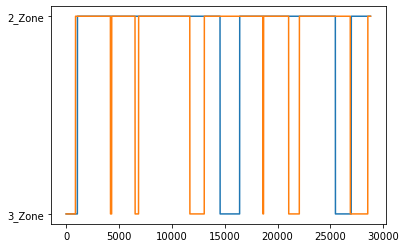

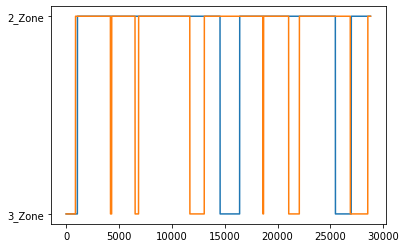

In [233]:
plt.plot(dico_pen_level_h['pen10'][dt.datetime(2020,9,30)]['hen_131']);
plt.plot(dico_pen_level_h['pen10'][dt.datetime(2020,9,30)]['hen_138']);

### verify one randon hen mvt to its vector

In [230]:
df[(df['HenID']=='hen_12')&((df['date']==dt.datetime(2020,10,14))|(df['date']==dt.datetime(2020,10,13)))] #hen_131 staid all day in zone 5
#8h-18h on the 2020,10,14

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,HenID,PenID,system,Zone,model_prediction,Timestamp,date,next_record_date,previous_record_date,previous_duration,next_zone,previous_zone,previous_previous_zone,correction_is_consecutive_equal_initial_zone,is_WG_open,hour,time
33189,hen_12,pen5,3 - 5,4_Zone,1,2020-10-13 08:11:05,2020-10-13,2020-10-13 08:17:59.000,2020-10-12 17:19:14.000,0 days 14:51:51,3_Zone,5_Zone,4_Zone,False,False,8,08:11:00
33261,hen_12,pen5,3 - 5,3_Zone,1,2020-10-13 08:17:59,2020-10-13,2020-10-13 08:18:44.000,2020-10-13 08:11:05.000,0 days 00:06:54,3_Zone,4_Zone,5_Zone,False,False,8,08:17:00
33279,hen_12,pen5,3 - 5,2_Zone,1,2020-10-13 08:20:34,2020-10-13,2020-10-13 09:40:44.000,2020-10-13 08:19:40.000,0 days 00:00:54,3_Zone,3_Zone,3_Zone,False,False,8,08:20:00
33818,hen_12,pen5,3 - 5,3_Zone,1,2020-10-13 09:40:44,2020-10-13,2020-10-13 09:42:29.000,2020-10-13 08:20:34.000,0 days 01:20:10,3_Zone,2_Zone,3_Zone,False,False,9,09:40:00
33913,hen_12,pen5,3 - 5,4_Zone,1,2020-10-13 09:55:51,2020-10-13,2020-10-13 09:57:19.000,2020-10-13 09:51:57.000,0 days 00:03:54,3_Zone,3_Zone,3_Zone,False,False,9,09:55:00
33921,hen_12,pen5,3 - 5,3_Zone,1,2020-10-13 09:57:19,2020-10-13,2020-10-13 10:01:04.000,2020-10-13 09:55:51.000,0 days 00:01:28,3_Zone,4_Zone,3_Zone,False,False,9,09:57:00
33966,hen_12,pen5,3 - 5,2_Zone,1,2020-10-13 10:04:32,2020-10-13,2020-10-13 11:07:14.000,2020-10-13 10:01:37.000,0 days 00:02:55,3_Zone,3_Zone,3_Zone,False,False,10,10:04:00
34302,hen_12,pen5,3 - 5,3_Zone,1,2020-10-13 11:07:14,2020-10-13,2020-10-13 11:12:08.000,2020-10-13 10:04:32.000,0 days 01:02:42,3_Zone,2_Zone,3_Zone,False,False,11,11:07:00
34435,hen_12,pen5,3 - 5,2_Zone,1,2020-10-13 11:30:49,2020-10-13,2020-10-13 12:29:52.000,2020-10-13 11:27:28.000,0 days 00:03:21,3_Zone,3_Zone,3_Zone,False,False,11,11:30:00
34787,hen_12,pen5,3 - 5,3_Zone,1,2020-10-13 12:29:52,2020-10-13,2020-10-13 12:31:48.000,2020-10-13 11:30:49.000,0 days 00:59:03,3_Zone,2_Zone,3_Zone,False,False,12,12:29:00


,HenID,PenID,system,Zone,model_prediction,Timestamp,date,next_record_date,previous_record_date,previous_duration,next_zone,previous_zone,previous_previous_zone,correction_is_consecutive_equal_initial_zone,is_WG_open,hour,time
33189,hen_12,pen5,3 - 5,4_Zone,1,2020-10-13 08:11:05,2020-10-13,2020-10-13 08:17:59.000,2020-10-12 17:19:14.000,0 days 14:51:51,3_Zone,5_Zone,4_Zone,False,False,8,08:11:00
33261,hen_12,pen5,3 - 5,3_Zone,1,2020-10-13 08:17:59,2020-10-13,2020-10-13 08:18:44.000,2020-10-13 08:11:05.000,0 days 00:06:54,3_Zone,4_Zone,5_Zone,False,False,8,08:17:00
33279,hen_12,pen5,3 - 5,2_Zone,1,2020-10-13 08:20:34,2020-10-13,2020-10-13 09:40:44.000,2020-10-13 08:19:40.000,0 days 00:00:54,3_Zone,3_Zone,3_Zone,False,False,8,08:20:00
33818,hen_12,pen5,3 - 5,3_Zone,1,2020-10-13 09:40:44,2020-10-13,2020-10-13 09:42:29.000,2020-10-13 08:20:34.000,0 days 01:20:10,3_Zone,2_Zone,3_Zone,False,False,9,09:40:00
33913,hen_12,pen5,3 - 5,4_Zone,1,2020-10-13 09:55:51,2020-10-13,2020-10-13 09:57:19.000,2020-10-13 09:51:57.000,0 days 00:03:54,3_Zone,3_Zone,3_Zone,False,False,9,09:55:00
33921,hen_12,pen5,3 - 5,3_Zone,1,2020-10-13 09:57:19,2020-10-13,2020-10-13 10:01:04.000,2020-10-13 09:55:51.000,0 days 00:01:28,3_Zone,4_Zone,3_Zone,False,False,9,09:57:00
33966,hen_12,pen5,3 - 5,2_Zone,1,2020-10-13 10:04:32,2020-10-13,2020-10-13 11:07:14.000,2020-10-13 10:01:37.000,0 days 00:02:55,3_Zone,3_Zone,3_Zone,False,False,10,10:04:00
34302,hen_12,pen5,3 - 5,3_Zone,1,2020-10-13 11:07:14,2020-10-13,2020-10-13 11:12:08.000,2020-10-13 10:04:32.000,0 days 01:02:42,3_Zone,2_Zone,3_Zone,False,False,11,11:07:00
34435,hen_12,pen5,3 - 5,2_Zone,1,2020-10-13 11:30:49,2020-10-13,2020-10-13 12:29:52.000,2020-10-13 11:27:28.000,0 days 00:03:21,3_Zone,3_Zone,3_Zone,False,False,11,11:30:00
34787,hen_12,pen5,3 - 5,3_Zone,1,2020-10-13 12:29:52,2020-10-13,2020-10-13 12:31:48.000,2020-10-13 11:30:49.000,0 days 00:59:03,3_Zone,2_Zone,3_Zone,False,False,12,12:29:00


10.0
10.0


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


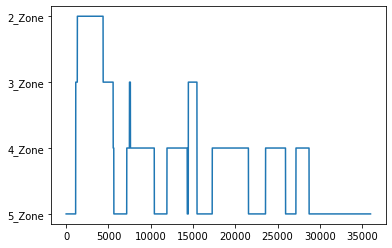

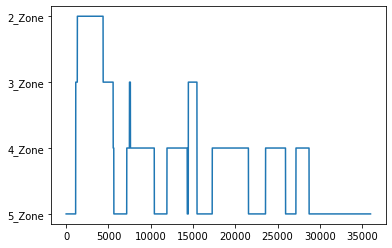

In [231]:
#mlp vectors
print(len(dico_pen_level_h['pen5'][dt.datetime(2020,10,14)]['hen_12'])/60/60) #10h correct
plt.plot(dico_pen_level_h['pen5'][dt.datetime(2020,10,14)]['hen_12']);
#--> looks CORRECT